# ABC with the OpenCL RAMP model

Multi-paramter calibration of the RAMP model using Approximate Bayesian Computation.

Calibrates on the individual hazard multipliers:
 - current_risk_beta
 - presymptomatic
 - asymptomatic
 - symptomatic
 
For a full list of parameters used in the model, see the default parameters file '[default.yml](../../model_parameters/default.yml)'.

## Import modules

Note about libraries:

 - Use [pyabc](https://pyabc.readthedocs.io/) (listed in [pythonMCMC](https://gabriel-p.github.io/pythonMCMC/)).

Note about installing. It is annoying. I did: 
```
conda install mpi4py
pip install pyabc
```
but also had to follow the first proposed solution [here](https://github.com/ipython/ipyparallel/issues/349) (reinstall setuptools and numpy).

Then I got a really annoying error about "`ValueError: Cell is empty`" which happened to be a pickle problem and was resolved by installing older versions: `cloudpickle==1.4.1 distributed==2.17.0` as per [this post](https://stackoverflow.com/questions/63497235/airflow-scheduler-crashes-when-a-dag-is-run)

 - Also adapted Josie's notebook: https://github.com/Urban-Analytics/uncertainty/blob/master/hm_abc_simple_example.ipynb

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Set this to False to recalculate all results (good on HPC or whatever). 
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = False

# Useful for connecting to this kernel
#%connect_info

In [ ]:
sys.path

## Setup

### Get default params for all runs

Read the parameters file

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [ ]:
os.getcwd()

In [2]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

/Users/fbenitez/opt/anaconda3/envs/ramp-ua/lib/python3.7/site-packages/RAMP_UA-1.4.0.dev0-py3.7.egg/microsim/opencl/ramp/params.py:55: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "


In [3]:
PARAMETERS_FILE

'../../model_parameters/default.yml'

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. You need to initilaise the model at least once to create the snapshot. The following says 'run in opencl mode and stop once initialisation has finished':

```
python microsim/main.py -ocl -init
```

In [17]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

### Observation Data

Read the real observations (number of hospital admissions in Devon) that will be used to calibrate the model. See the [README](./observation_data/README.md) for information about how these observations were obtained. They aren't the raw cases, it's actually a model that was fitted to the lagged cases. They need to be made cumulative as this is how they will be compared to the model.

In [18]:
# New per day:
gam_cases = pd.read_csv(os.path.join("../../", "gam_cases.csv"), header=0, names=["Day", "Cases"], )

# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )

assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

Total cases: 16371


### Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model

In [19]:
ITERATIONS = 100  # Number of iterations to run for
NUM_SEED_DAYS = 10  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP=False # I dont know the impact of having this parameter, but as it is bolean I set it as False.

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(
    iterations = ITERATIONS, 
    repetitions = REPETITIONS, 
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS, 
    parameters_file = PARAMETERS_FILE, 
    opencl_dir = OPENCL_DIR,
    use_healthier_pop = USE_HEALTHIER_POP,
    snapshot_filepath = SNAPSHOT_FILEPATH
)

Running models:   0%|          | 0/10 [00:00<?, ?it/s]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17224.


Running models:  10%|█         | 1/10 [00:15<02:16, 15.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70841.


Running models:  20%|██        | 2/10 [00:27<01:48, 13.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33181.


Running models:  30%|███       | 3/10 [00:38<01:27, 12.54s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98227.


Running models:  40%|████      | 4/10 [00:50<01:12, 12.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30946.


Running models:  50%|█████     | 5/10 [01:01<00:59, 11.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37346.


Running models:  60%|██████    | 6/10 [01:13<00:47, 11.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22451.


Running models:  70%|███████   | 7/10 [01:25<00:35, 11.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98331.


Running models:  80%|████████  | 8/10 [01:36<00:23, 11.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3471.


Running models:  90%|█████████ | 9/10 [01:48<00:11, 11.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73623.


Running models: 100%|██████████| 10/10 [02:00<00:00, 12.00s/it]

.. finished, took 120.03s)
Ran Model with {}
fitness: 49937.56298218807


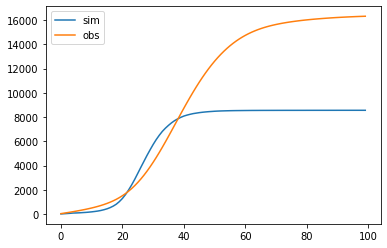

In [20]:
OpenCLRunner.update(repetitions=10)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim")
ax.plot(x, obs0, label="obs")
ax.legend()

### Plot output summary data

#### Total counts of disease status

In [21]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations
    
    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)
        
        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "Cases"], 
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")
        
    
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

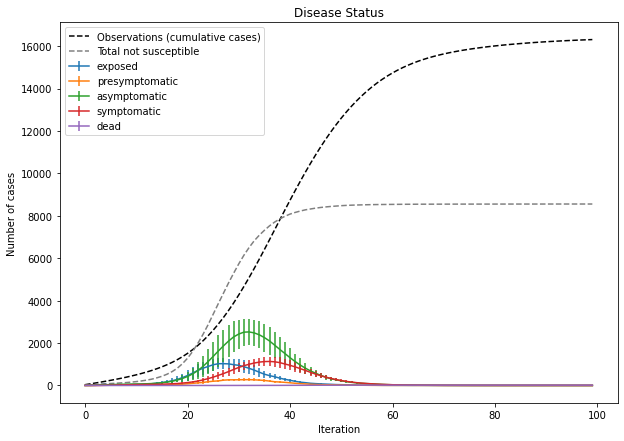

In [22]:
plot_summaries(summaries=summaries0, observations=OBSERVATIONS, plot_type="error_bars")

In [ ]:
#plot_summaries(summaries=summaries0, plot_type="lines")

#### Disease statuses by age

In [23]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

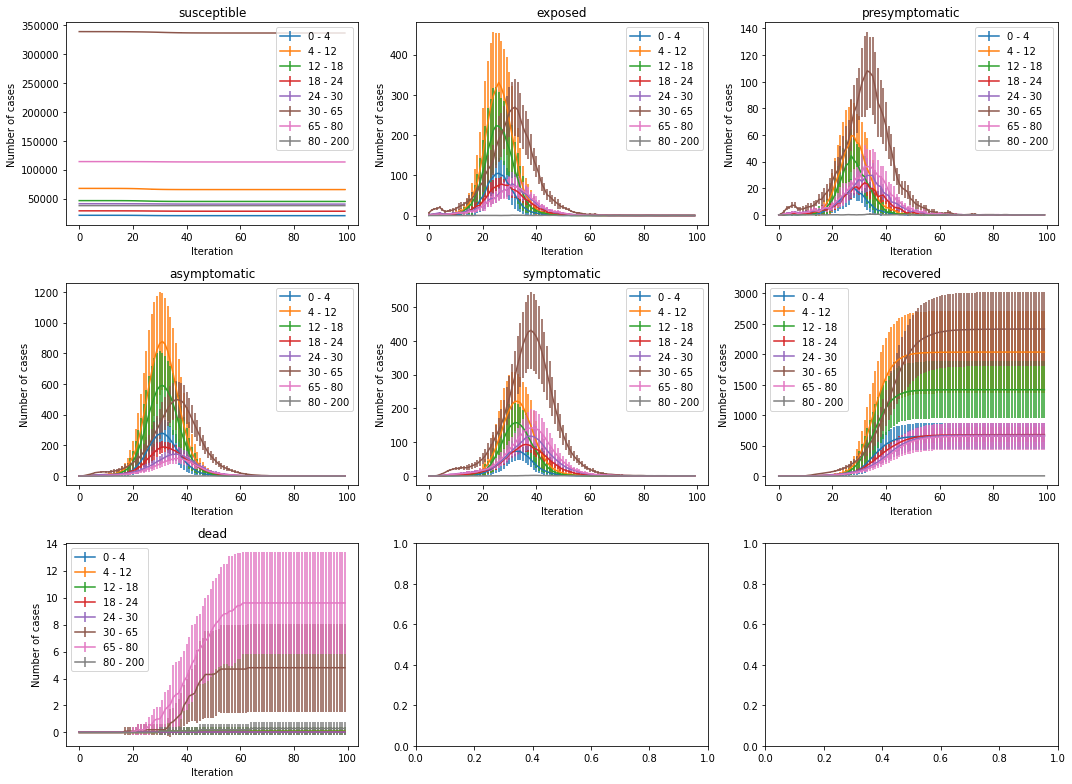

In [24]:
plot_disease_status_by_age(summaries0)

### Plot MSOA geodata

#### Load MSOA shapes

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


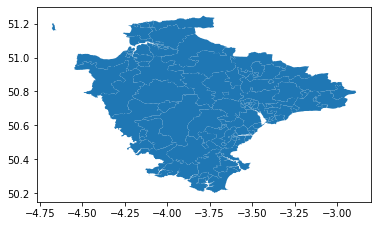

In [25]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes

data_dir = ("../../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

### Plot disease status by MSOA for a given timestep and status

In [26]:
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep, ax=None):
    """
    """
    # Summary can be a single summary, or a list of a few summaries (will need an average)
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True, ax=ax)

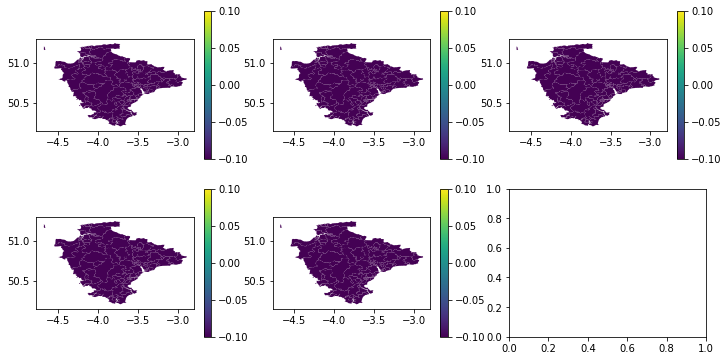

In [29]:
disease_status = "exposed"

fig, axes = plt.subplots(nrows=2, ncols=int(REPETITIONS/2) if (REPETITIONS % 2) == 0 else int(REPETITIONS/2)+1, 
                         figsize=(12,6))

for i in range(REPETITIONS):
    ax = axes.flat[i]
    plot_msoa_choropleth(devon_msoa_shapes,  summaries0[i], 
                         disease_status, 99, ax=ax )
#plot_msoa_choropleth(devon_msoa_shapes, summaries0[0], disease_status, 99)

## Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/) (listed in [pythonMCMC](https://gabriel-p.github.io/pythonMCMC/)).

In [30]:
# Also need a new distance function that extracts the data from dataframes.
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

### Calculating Error: Fitness Function

To calibrate the model we need a fitness function that tells us, for a given result, how similar it is to the observations. The 'observations' (in the [gam_cases.csv](../../gam_cases.csv)) are the number of new infections per day. The model equivalent of this is to look at the number of non-susceptible people per day (i.e. add up all the _non-susceptible_ disease statuses).

Ultimately two arrays showing the cumulative infections per day need to be compared. There are lots of ways to do this. For now, just take the **Euclidean distance (L2 norm)** between the observed number of cases and the simulated number of cases.

This is implemented in `opencl_runner.OpenCLRunner.fit_l2` (see [opencl_runner.py](../opencl_runner.py)).

Note that the model is seeded using the first few days of cases, so at the beginning of a run the simulated data will be identical to the observations. This doesn't matter though because the relative difference between different parameter combinations will be the same regardless.

### Priors

Define the priors. This time make them all normal distributions, but will decorate them later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

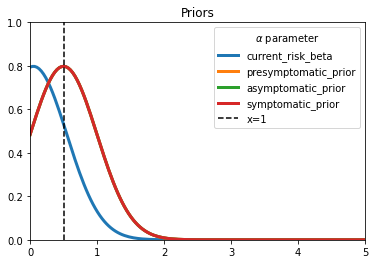

In [31]:
current_risk_beta_rv = pyabc.RV("norm", 0.05, 0.5)
presymptomatic_rv = pyabc.RV("norm", 0.5, 0.5)
asymptomatic_rv = pyabc.RV("norm", 0.5, 0.5)
symptomatic_rv = pyabc.RV("norm", 0.5, 0.5)

# Note, could create the distribution here (currently done below), then plot the priors directly using, e.g. 
#   y= p riors['current_risk_beta_prior'].pdf(x)
# but for some reason decorating them with the LowerBoundDecorator breaks the call to pdf()

x = np.linspace(-0 ,5, 150)
lines = plt.plot(x, pyabc.Distribution(param=current_risk_beta_rv).pdf({"param": x}),
                 label = "current_risk_beta", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=presymptomatic_rv).pdf({"param": x}),
                 label = "presymptomatic_prior", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=asymptomatic_rv).pdf({"param": x}),
                 label = "asymptomatic_prior", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=symptomatic_rv).pdf({"param": x}),
                 label = "symptomatic_prior", lw = 3)

plt.autoscale(tight=True)

plt.axvline(x=0.5, ls='--', color="black", label="x=1")
plt.title("Priors")
plt.ylim(0,1)
plt.legend(title=r"$\alpha$ parameter");

In [32]:
# Decorate the RVs so that they wont go below 0 and create the prior distribution 

priors = pyabc.Distribution(
    current_risk_beta = pyabc.LowerBoundDecorator(current_risk_beta_rv, 0.0),
    presymptomatic = pyabc.LowerBoundDecorator(presymptomatic_rv, 0.0),
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0),
    symptomatic = pyabc.LowerBoundDecorator(symptomatic_rv, 0.0)
    )

#current_risk_beta_prior = pyabc.LowerBoundDecorator(current_risk_beta_prior, 0.0)
#presymptomatic_prior = pyabc.LowerBoundDecorator(presymptomatic_prior, 0.0)
#asymptomatic_prior = pyabc.LowerBoundDecorator(asymptomatic_prior, 0.0)
#symptomatic_prior = pyabc.LowerBoundDecorator(symptomatic_prior, 0.0)

### Initialise the ABC algorithm.

In [33]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    )

Define observations

In [37]:
# 'Real' cumulative cases: 
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

Where to store results


In [38]:
db_path = ("sqlite:///" + os.path.join(".", "abc-2.db"))

In [39]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

ABC.History INFO: Start <ABCSMC id=2, start_time=2022-07-21 18:25:26>


### Run ABC

In [40]:
history = None
fname = "./abc-1.pkl"

if LOAD_PICKLES:
    with open( fname, "rb" ) as f:
        history = pickle.load(f)
else:
    #history = abc.run(minimum_epsilon=.1, max_nr_populations=10)
    history = abc.run(max_nr_populations=5) 
    # The history object only works if it has the associated database too ('abc-1.db')
    with open( fname, "wb" ) as f:
        pickle.dump( history, f)

ABC INFO: Calibration sample t = -1.
Running models:   0%|          | 0/5 [00:00<?, ?it/s]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595


/Users/fbenitez/opt/anaconda3/envs/ramp-ua/lib/python3.7/site-packages/RAMP_UA-1.4.0.dev0-py3.7.egg/microsim/opencl/ramp/params.py:55: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "


Running simulation 14498.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85280.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72739.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46716.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43521.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.333705849831205, 'presymptomatic': 0.5076706813412001, 'asymptomatic': 0.42788359891401073, 'symptomatic': 0.6070047910193581>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35680.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97476.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37111.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65396.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74063.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]

.. finished, took 14.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4752084135239093, 'presymptomatic': 0.6334183825860068, 'asymptomatic': 0.7539941044297194, 'symptomatic': 0.6334650419232696>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70300.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69894.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12796.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87542.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98025.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.608657089016001, 'presymptomatic': 0.028809461238310297, 'asymptomatic': 0.21987368672812857, 'symptomatic': 1.5294119341455885>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64005.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28479.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93599.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65877.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19416.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.026531673329091485, 'presymptomatic': 1.2913051967336435, 'asymptomatic': 0.5351786293746683, 'symptomatic': 0.8524291470321657>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7111.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83300.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13825.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78909.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51134.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.15158137558532328, 'presymptomatic': 0.90748512253971, 'asymptomatic': 0.17221815028110116, 'symptomatic': 0.3645380900948476>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35020.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32482.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46309.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28193.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96325.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3752783855349108, 'presymptomatic': 0.8313018334380062, 'asymptomatic': 1.3689008353812233, 'symptomatic': 0.5043642361046766>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57381.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90576.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4683.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70831.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54919.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.621478067564228, 'presymptomatic': 1.1368781945587223, 'asymptomatic': 1.199211630223, 'symptomatic': 0.4836041098706553>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51274.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45704.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26525.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36993.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54013.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.30091664975370996, 'presymptomatic': 0.09527674082602727, 'asymptomatic': 0.34102922654037415, 'symptomatic': 0.8665266940347879>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99797.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85152.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51374.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18893.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66118.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.05798648549079253, 'presymptomatic': 0.6105960539494878, 'asymptomatic': 0.5017158906901831, 'symptomatic': 0.4300389874126515>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54870.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30118.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96550.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99718.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6898.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.26580239826374913, 'presymptomatic': 1.043132508849601, 'asymptomatic': 0.2113748821762083, 'symptomatic': 0.28019625992274233>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86209.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51004.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89303.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54284.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23280.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6676472084451943, 'presymptomatic': 1.1942672007484452, 'asymptomatic': 0.4602882342541529, 'symptomatic': 0.5834402597587277>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96632.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30334.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26520.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31069.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4153.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6463133638192797, 'presymptomatic': 0.44523075435790394, 'asymptomatic': 0.32864218496562964, 'symptomatic': 1.2386593987719423>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19931.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22811.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66931.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58323.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57155.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03091784816101604, 'presymptomatic': 0.687613915675245, 'asymptomatic': 1.4724580002517356, 'symptomatic': 0.6785445332121824>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26338.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52315.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18860.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51313.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87395.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]

.. finished, took 13.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.05775358267369503, 'presymptomatic': 0.17426145233125723, 'asymptomatic': 0.03489403539712449, 'symptomatic': 0.5836027068435855>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47665.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6960.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88235.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9929.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58939.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]

.. finished, took 14.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.60717612149499, 'presymptomatic': 0.5763072313471116, 'asymptomatic': 1.1091088510967553, 'symptomatic': 1.3967580012302492>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88288.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75865.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13052.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43429.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66289.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.46440810435617147, 'presymptomatic': 1.2716995867390852, 'asymptomatic': 0.9967162245975314, 'symptomatic': 0.45232673020960873>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31073.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66338.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88907.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48686.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51185.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6216685827042326, 'presymptomatic': 0.1712246045391606, 'asymptomatic': 0.1823565897875158, 'symptomatic': 0.3133325600998459>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6743.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89778.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 520.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90599.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83367.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.19458581771405237, 'presymptomatic': 0.1835159446923817, 'asymptomatic': 1.5318638321097162, 'symptomatic': 0.47404146465349395>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69783.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13368.


Running models:  40%|████      | 2/5 [00:05<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32285.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41381.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89193.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2731360403393962, 'presymptomatic': 1.0123985153769821, 'asymptomatic': 0.23908738118057465, 'symptomatic': 0.1951203232381029>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96366.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99020.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68009.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51382.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65319.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.1374670643895886, 'presymptomatic': 1.1878155781117226, 'asymptomatic': 1.2448227767142575, 'symptomatic': 0.4064410926915138>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62833.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70261.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53560.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15111.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22068.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9380498704902237, 'presymptomatic': 0.941030644912547, 'asymptomatic': 0.3862540988497001, 'symptomatic': 0.07372556663189672>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77591.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66451.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17274.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28714.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44388.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6643037441656717, 'presymptomatic': 0.45681770261281845, 'asymptomatic': 0.787486964896561, 'symptomatic': 0.8285525928043498>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56806.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91289.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29065.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8742.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18324.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6396492153449523, 'presymptomatic': 0.1361654442386847, 'asymptomatic': 0.8784008121184479, 'symptomatic': 0.509225665260037>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86777.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93316.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25201.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23129.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32509.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7013224823277916, 'presymptomatic': 0.3616141387294205, 'asymptomatic': 1.7294695736071175, 'symptomatic': 0.5938005493531859>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58747.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52489.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59883.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53757.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11634.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3834461351066734, 'presymptomatic': 1.1984016730667817, 'asymptomatic': 1.1995821487699287, 'symptomatic': 0.41115087249688437>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42595.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17897.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27466.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89624.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29154.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.056640658546658146, 'presymptomatic': 0.80565319324577, 'asymptomatic': 0.7203157145321064, 'symptomatic': 0.14220893363418585>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66745.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53541.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96055.


Running models:  60%|██████    | 3/5 [00:08<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21004.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41170.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3276033389212984, 'presymptomatic': 1.0222469333989805, 'asymptomatic': 0.8533332433396362, 'symptomatic': 0.6545481240678689>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59207.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 724.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48469.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55535.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19154.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8656036927978932, 'presymptomatic': 0.6419279895797328, 'asymptomatic': 0.2126092098854762, 'symptomatic': 0.6841363368898195>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21103.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54433.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45355.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54652.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79356.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1530792385427716, 'presymptomatic': 0.9934715030392822, 'asymptomatic': 0.3349785873879044, 'symptomatic': 0.5597409320341744>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23984.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69702.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63941.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58292.


Running models:  80%|████████  | 4/5 [00:11<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20222.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.07290773995286728, 'presymptomatic': 0.10591001008228845, 'asymptomatic': 0.5051109632922094, 'symptomatic': 0.41153863734429674>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1757.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61814.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33386.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51315.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78768.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.24437292817165646, 'presymptomatic': 0.7234783966626691, 'asymptomatic': 0.4939536036560595, 'symptomatic': 0.02917152402985651>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30209.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91661.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7927.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41761.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95128.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0569789724718657, 'presymptomatic': 0.8259619288970304, 'asymptomatic': 0.22693260816070143, 'symptomatic': 0.9360458605869436>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34813.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61898.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40075.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48462.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78211.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0694010324272916, 'presymptomatic': 0.11902689596412946, 'asymptomatic': 0.9738644090813884, 'symptomatic': 0.23568654862034666>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39648.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62817.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17735.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42794.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46603.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6654894714751871, 'presymptomatic': 0.6097854665644805, 'asymptomatic': 0.966611137235284, 'symptomatic': 0.9158339120987715>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46388.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10845.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98142.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29708.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73213.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]

.. finished, took 14.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.011299163879676444, 'presymptomatic': 0.8807361709343304, 'asymptomatic': 1.0110639834612836, 'symptomatic': 0.5068231334821444>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25950.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94235.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69316.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38036.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9687.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6334647510030824, 'presymptomatic': 0.6367654190759131, 'asymptomatic': 0.7911160587596435, 'symptomatic': 0.9358139430393535>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33455.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35889.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3731.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68519.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57137.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3553463399676174, 'presymptomatic': 0.8841122486136016, 'asymptomatic': 0.4799139228157186, 'symptomatic': 0.12997209434139328>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38258.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82620.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73885.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41787.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33179.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

.. finished, took 13.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.061766602671313404, 'presymptomatic': 0.2505542423060756, 'asymptomatic': 0.12968843607529923, 'symptomatic': 0.11443189376582791>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68408.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69312.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66032.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82521.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93378.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7137500668274985, 'presymptomatic': 0.17224697476892092, 'asymptomatic': 0.2864789587126857, 'symptomatic': 1.108887651060023>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72777.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60811.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10613.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18281.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41089.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.520581931849993, 'presymptomatic': 0.2712647777481154, 'asymptomatic': 0.23901639428592314, 'symptomatic': 0.006118623988573935>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17892.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32388.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60008.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45535.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71764.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3420613168944225, 'presymptomatic': 0.6093179478431578, 'asymptomatic': 0.8378197820240714, 'symptomatic': 1.934973664627952>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47333.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67821.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38994.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88310.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47919.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.2857869428882276, 'presymptomatic': 1.0375028191861313, 'asymptomatic': 1.0472934277989445, 'symptomatic': 0.8535219515509342>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91060.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74046.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50998.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58994.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2432.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6480252250227165, 'presymptomatic': 0.6873555807380707, 'asymptomatic': 0.5723087969842205, 'symptomatic': 0.6814834713589016>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41396.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15319.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 843.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15896.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23814.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.12147351288995793, 'presymptomatic': 0.6278164600220673, 'asymptomatic': 0.1899169619019458, 'symptomatic': 0.652618933088413>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64954.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9666.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86823.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95886.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47619.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3220086219383754, 'presymptomatic': 0.485812096877791, 'asymptomatic': 0.2477801820267277, 'symptomatic': 0.899895201537168>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52644.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31912.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26730.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50308.


Running models:  80%|████████  | 4/5 [00:11<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92946.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3517051261834602, 'presymptomatic': 0.3428967561711027, 'asymptomatic': 0.8689821466575891, 'symptomatic': 0.17166504137190908>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72090.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 305.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20105.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73380.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26976.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6775286568604086, 'presymptomatic': 0.47144763817987123, 'asymptomatic': 0.4374593006348202, 'symptomatic': 1.0842765637511054>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89232.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5485.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47713.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23800.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52420.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]

.. finished, took 13.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.016524512181365143, 'presymptomatic': 0.41501778706563763, 'asymptomatic': 0.40657653383889575, 'symptomatic': 0.3124534173673991>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71935.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16857.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99575.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72451.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34051.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1633175118667365, 'presymptomatic': 0.2666869049299578, 'asymptomatic': 0.6018901104700324, 'symptomatic': 0.41624053545244266>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53052.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11381.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38162.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29565.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41611.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2602050590649894, 'presymptomatic': 1.0010309843176655, 'asymptomatic': 0.029128779211273048, 'symptomatic': 0.47838025715403854>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12064.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7095.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73295.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23887.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8136.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.13217713462389397, 'presymptomatic': 0.4592189431923534, 'asymptomatic': 0.9491618249409155, 'symptomatic': 0.9866613257258711>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23564.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93822.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87160.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61315.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69551.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6634128926509283, 'presymptomatic': 1.1184122153980738, 'asymptomatic': 0.8935986087106534, 'symptomatic': 0.517964184907359>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73593.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74124.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74617.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74613.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51572.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1936887343087622, 'presymptomatic': 0.07226929093559176, 'asymptomatic': 0.6410671290878187, 'symptomatic': 1.5301101668522448>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82060.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47900.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97143.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70858.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72452.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.676214637066038, 'presymptomatic': 0.5833125280647243, 'asymptomatic': 1.40957612018545, 'symptomatic': 0.42830427201786414>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16568.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12651.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51298.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55664.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47171.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.31163577355669364, 'presymptomatic': 0.6582025642860297, 'asymptomatic': 0.03303559372853976, 'symptomatic': 0.04906334142614027>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21428.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84174.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50976.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74550.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57651.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4279629117312192, 'presymptomatic': 1.0452851401061325, 'asymptomatic': 1.3846844416997302, 'symptomatic': 0.2045241533003554>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25999.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29353.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49549.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95477.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70607.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6152220865797627, 'presymptomatic': 0.5985295666100383, 'asymptomatic': 0.17063301950797227, 'symptomatic': 0.9797143362967928>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68161.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96220.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65903.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37298.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67847.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.045090023550696974, 'presymptomatic': 0.5519364344979637, 'asymptomatic': 1.5973941779334313, 'symptomatic': 0.02709461048494144>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25768.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51617.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35856.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62724.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58360.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.4247015018335905, 'presymptomatic': 0.8429938152707891, 'asymptomatic': 0.9562151401120061, 'symptomatic': 0.32482107657634257>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97419.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17683.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44870.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51830.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20090.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.06036740303786297, 'presymptomatic': 0.6502880412248807, 'asymptomatic': 0.6975075330223116, 'symptomatic': 1.9818706128467538>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60211.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54442.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18503.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53634.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54311.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3780304061052548, 'presymptomatic': 1.057363103330538, 'asymptomatic': 1.6822768941794974, 'symptomatic': 0.8465175392310065>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54575.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99811.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79581.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31705.


Running models:  80%|████████  | 4/5 [00:11<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68441.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14802450895419356, 'presymptomatic': 0.3916538473351601, 'asymptomatic': 1.07676254363568, 'symptomatic': 0.554530778453199>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1025.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51815.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60950.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95457.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25004.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7153631766139185, 'presymptomatic': 0.8312700477347907, 'asymptomatic': 0.5782673875170862, 'symptomatic': 0.5348990456464585>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60546.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85238.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98800.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68324.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98370.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.0625008297782518, 'presymptomatic': 0.6702850390041513, 'asymptomatic': 0.9359704367336852, 'symptomatic': 0.6312729315468659>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33208.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68065.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58225.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74928.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37965.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.24040005412196214, 'presymptomatic': 0.6377794503960503, 'asymptomatic': 0.4075773502512612, 'symptomatic': 0.45231049120314704>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15356.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75327.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96986.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97394.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56136.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03671874787775665, 'presymptomatic': 0.8472709574603065, 'asymptomatic': 0.8525343998472571, 'symptomatic': 1.954692184246652>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87180.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69746.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92817.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81040.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66232.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.09326345379693982, 'presymptomatic': 0.08242646629666506, 'asymptomatic': 1.2235285191494356, 'symptomatic': 0.3923642084795633>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2347.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84230.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43615.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2743.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56613.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.34939343736534983, 'presymptomatic': 0.18136089425219248, 'asymptomatic': 1.1748353872013901, 'symptomatic': 0.7171139416273864>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2970.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22223.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4320.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13081.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17313.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6701548004300147, 'presymptomatic': 0.3529607260390524, 'asymptomatic': 0.46958207143563807, 'symptomatic': 0.7602645722967158>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23466.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 232.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30469.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92113.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64334.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.39483584683681244, 'presymptomatic': 1.2201592208592196, 'asymptomatic': 0.3208502579085975, 'symptomatic': 0.5323778190601414>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39353.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 249.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7327.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15074.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75388.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.971390102441726, 'presymptomatic': 0.73686958882793, 'asymptomatic': 0.5756953452792971, 'symptomatic': 0.4810292997911547>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65023.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15285.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38914.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18207.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69840.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2671413804670391, 'presymptomatic': 0.8599841697840221, 'asymptomatic': 0.8248230498682902, 'symptomatic': 1.2828135894224562>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72761.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67898.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17137.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18460.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88005.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.24310922159192488, 'presymptomatic': 0.6872439817581589, 'asymptomatic': 0.11944066722993146, 'symptomatic': 0.3635987945101512>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64289.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22031.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22123.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90105.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65915.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2793553687213588, 'presymptomatic': 0.48599732438971693, 'asymptomatic': 0.030886236624361907, 'symptomatic': 0.38907579394567526>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88786.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42523.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48673.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41258.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80379.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.45824072024016654, 'presymptomatic': 1.1023381870880826, 'asymptomatic': 1.1412564048325553, 'symptomatic': 1.0116470709978524>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40894.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80930.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10121.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72465.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95139.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3124539619970843, 'presymptomatic': 1.048739734098271, 'asymptomatic': 0.20338095279824364, 'symptomatic': 0.2186486921870977>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21258.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55519.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3903.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79681.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14163.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.05843044680705707, 'presymptomatic': 1.6166301181834917, 'asymptomatic': 0.2960970667331409, 'symptomatic': 0.3618778654111933>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21044.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27121.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68534.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12890.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77669.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.20207228098462782, 'presymptomatic': 0.9727553736722863, 'asymptomatic': 0.268040216306094, 'symptomatic': 0.2914783326623638>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70103.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19836.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13340.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59973.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10702.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]

.. finished, took 14.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03463997205729093, 'presymptomatic': 0.5819785169637883, 'asymptomatic': 0.20749312784483054, 'symptomatic': 0.6702699141328063>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99645.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28058.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37133.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27351.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14907.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.06237885812991033, 'presymptomatic': 0.004321922769072284, 'asymptomatic': 0.6454435427057101, 'symptomatic': 0.9146831513728566>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44843.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91699.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44112.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40241.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88968.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3060116737027439, 'presymptomatic': 0.7315351452865221, 'asymptomatic': 0.24040523128872976, 'symptomatic': 0.5548858756560994>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55900.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33017.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26505.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23020.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31688.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.008844848131507953, 'presymptomatic': 0.5888041685058927, 'asymptomatic': 1.2492776667414471, 'symptomatic': 0.4117404362493396>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24223.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33631.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36228.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66965.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40721.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6825438372148575, 'presymptomatic': 0.4983896594621815, 'asymptomatic': 0.8866631422598085, 'symptomatic': 0.1940550943604411>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99222.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78467.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 932.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13904.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48690.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1283980498795842, 'presymptomatic': 0.6682972367297986, 'asymptomatic': 1.5318319170691606, 'symptomatic': 0.7978086880480288>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68218.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49753.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77052.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97524.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69806.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.062455914721942035, 'presymptomatic': 0.7049502231494507, 'asymptomatic': 1.0958410513259023, 'symptomatic': 0.596379576164907>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19529.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74485.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81306.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90346.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52256.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03740435119422485, 'presymptomatic': 0.8134604246171075, 'asymptomatic': 0.5983894241892105, 'symptomatic': 0.6131449244457247>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6402.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41185.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5392.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56372.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88777.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4075690225246287, 'presymptomatic': 0.17319565514505397, 'asymptomatic': 1.2255197554084727, 'symptomatic': 0.20520829723719897>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42196.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66421.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81609.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44951.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17987.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.321937777173457, 'presymptomatic': 0.6343080219251306, 'asymptomatic': 0.30552336426246807, 'symptomatic': 1.080701868272623>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70189.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55151.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18584.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1132.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85091.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.11822545815979721, 'presymptomatic': 0.5642521050161027, 'asymptomatic': 0.14134447848629933, 'symptomatic': 0.26833705322501844>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98405.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73390.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73637.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80283.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85885.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.33135729676661196, 'presymptomatic': 0.43979847976605563, 'asymptomatic': 1.2886753837708693, 'symptomatic': 1.0242948342305613>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3830.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24142.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75932.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34311.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75196.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.22225809073072245, 'presymptomatic': 0.9618688099259909, 'asymptomatic': 1.2553622550647332, 'symptomatic': 0.06655606304213996>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70369.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45030.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98425.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81335.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3450.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.43155094278858686, 'presymptomatic': 0.6657177180537631, 'asymptomatic': 0.23200209619027828, 'symptomatic': 0.5742662391216498>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56192.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75777.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25208.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16404.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9819.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8848922895590529, 'presymptomatic': 0.3382491343617404, 'asymptomatic': 1.6308304669599818, 'symptomatic': 0.1640412445907673>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58340.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70602.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7039.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26592.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22868.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.45901297308297107, 'presymptomatic': 0.6027126198036092, 'asymptomatic': 0.16443024364829967, 'symptomatic': 1.0792550669817451>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43681.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2571.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85625.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86137.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5336.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.017747970107172453, 'presymptomatic': 0.3749799149116907, 'asymptomatic': 0.8356984227480233, 'symptomatic': 0.8378581928686171>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36463.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26316.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60360.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39536.


Running models:  80%|████████  | 4/5 [00:11<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36568.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.025460439636747233, 'presymptomatic': 0.3991121117942779, 'asymptomatic': 0.3763730989781445, 'symptomatic': 0.7753167539969923>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20689.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33293.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8124.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10717.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98623.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.41585906972706316, 'presymptomatic': 0.33330238864951567, 'asymptomatic': 0.4890479448170845, 'symptomatic': 1.1445225207183587>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33011.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59223.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33044.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83252.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24641.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5640451877903442, 'presymptomatic': 1.6498066851671478, 'asymptomatic': 0.9174146017624963, 'symptomatic': 0.0913692656098895>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95129.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71229.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8081.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29085.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40088.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.812890431955204, 'presymptomatic': 0.18779240091007493, 'asymptomatic': 0.37922737236578313, 'symptomatic': 0.5996677755403725>
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82385.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28067.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43281.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19979.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59707.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.7s)



ABC INFO: t: 0, eps: 4.84670818e+06.
Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7009814088220473, 'presymptomatic': 0.863414122525547, 'asymptomatic': 1.1432560263062137, 'symptomatic': 0.5656225543393747>
4860300.104260205
5267612.328827474
4892570.388997449
2306364.5534832864
3726406.992828733
5299431.75758968
5408277.053121724
4606972.3622847665
3035545.5006403644
4371537.291277932
5306910.058947655
5158007.399507783
3341815.3044455284
550268.8084397297
5406439.523580239
5337325.417287115
4696847.333222748
4954198.687678846
4382032.270280149
5482563.721446054
5279575.511278084
5361720.6858864
5322588.422675644
5430741.018813727
5292267.854279807
3335329.571571769
5186739.412547524
5151681.8895171005
4183121.8320440394
3027325.0822568163
4421701.628543134
5267624.393663762
5372891.375511118
5400354.3153590625
1289324.2637303774
5365375.047983125
4829545.865827879
1159366.509693186
5099915.523086959
4369713.1876985105
5225182.340834704
5483004.044520361
5308017.325252098
3482366.8877995205
4629977.866083807
4946802

Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65986.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75414.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26497.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94615.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2622261998443528, 'presymptomatic': 1.0535495278314593, 'asymptomatic': 0.47981109466490063, 'symptomatic': 0.8644297024044669>
4879743.780667735
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31945.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5792.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23611.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86171.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31643.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0442975747024204, 'presymptomatic': 0.9310027941417856, 'asymptomatic': 1.0187383529747531, 'symptomatic': 0.15653477327332282>
5437925.919888103
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28569.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36678.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33909.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38081.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40581.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.34635097902412654, 'presymptomatic': 0.3509668140460887, 'asymptomatic': 0.33093790633074943, 'symptomatic': 0.5577837040449345>
4716457.198552147
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 819.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63707.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3733.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51215.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63361.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6429623979993506, 'presymptomatic': 0.5761047813413332, 'asymptomatic': 0.4097540995201904, 'symptomatic': 0.34506686634928607>
5175196.374470524
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51794.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83137.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61832.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64857.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32292.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6460080331925513, 'presymptomatic': 0.28185214982103873, 'asymptomatic': 0.8603490712588393, 'symptomatic': 0.27466980155745485>
5272249.404287495
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61258.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89273.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27908.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26279.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82195.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.08158311563012799, 'presymptomatic': 0.20676403692594908, 'asymptomatic': 0.6448662366443056, 'symptomatic': 0.3675633329591865>
3525690.8228558614
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56830.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3544.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84526.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 392.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78155.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8042496456093015, 'presymptomatic': 0.7640674721543075, 'asymptomatic': 0.4039341533624346, 'symptomatic': 0.9567214841787959>
5312446.027027226
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46965.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77419.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39759.


Running models:  60%|██████    | 3/5 [00:09<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62425.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27184.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.42503011552344533, 'presymptomatic': 0.31739798244482964, 'asymptomatic': 1.4292668369960455, 'symptomatic': 0.31967378474210995>
5239270.582357723
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21929.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31379.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9704.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20546.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86488.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.34068703915339965, 'presymptomatic': 0.1778090475666405, 'asymptomatic': 0.20044464247559984, 'symptomatic': 0.9559318992796406>
4463940.911914408
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35447.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90548.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85797.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29276.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30247.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.17227598856352272, 'presymptomatic': 0.9295220460504515, 'asymptomatic': 0.31801289825266793, 'symptomatic': 0.7519856258323272>
4309942.02912473
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57240.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1783.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47883.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95289.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47376.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.62602666206453, 'presymptomatic': 0.7465667036333103, 'asymptomatic': 1.1261730328773911, 'symptomatic': 0.4152041466436107>
5383333.77178162
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73492.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37316.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4237.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35312.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37204.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14793540980598024, 'presymptomatic': 1.1841457562514572, 'asymptomatic': 1.3182525021371, 'symptomatic': 0.4367214103810475>
4823919.432805001
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5176.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28750.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24295.


Running models:  60%|██████    | 3/5 [00:09<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72682.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96641.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2773359536793688, 'presymptomatic': 1.0530257340230298, 'asymptomatic': 0.37139930252016384, 'symptomatic': 0.942362835187107>
4824345.24885992
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99627.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50660.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23866.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71453.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10331.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1968502989110003, 'presymptomatic': 0.199499198126377, 'asymptomatic': 0.4966098785679622, 'symptomatic': 0.6303532089757046>
4422332.810876382
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72339.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56039.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64632.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10112.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42493.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.44181495316287683, 'presymptomatic': 0.6204555998314811, 'asymptomatic': 0.5036645777662083, 'symptomatic': 0.010537325409066267>
4798285.2474871185
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16755.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11470.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23167.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57874.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50893.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7412510347372188, 'presymptomatic': 0.598289428204487, 'asymptomatic': 0.07586216284141928, 'symptomatic': 0.1146445107090891>
4528869.26673211
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59818.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33528.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77511.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34592.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60975.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.28926462540919223, 'presymptomatic': 0.17146830009783864, 'asymptomatic': 0.9587318957723809, 'symptomatic': 0.9830008542974578>
5121087.478739511
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14863.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73489.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59304.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72195.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72326.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5679452379398043, 'presymptomatic': 0.09469085735796834, 'asymptomatic': 0.9329194928926721, 'symptomatic': 0.21237702563041116>
5163598.147570073
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99150.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60110.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52282.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13410.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60580.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.30887441388300196, 'presymptomatic': 0.46730273248706117, 'asymptomatic': 0.5703564266718105, 'symptomatic': 0.7648565544292036>
4966605.117144764
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71889.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68422.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6016.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8294.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53925.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]

.. finished, took 13.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.005795798394175773, 'presymptomatic': 0.9453818883500855, 'asymptomatic': 0.47549054816491976, 'symptomatic': 0.6033522058046785>
82475.8441816754
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69580.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19183.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11547.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56267.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56983.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.44162170120397165, 'presymptomatic': 0.3002868484657397, 'asymptomatic': 0.9241060249102936, 'symptomatic': 0.7288244523120013>
5264666.436985352
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9108.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44731.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74941.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41892.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98302.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9437217822631773, 'presymptomatic': 0.9365225546656757, 'asymptomatic': 0.9630166526907065, 'symptomatic': 0.7324471356976587>
5451484.974240505
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48513.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.44s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78944.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.38s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78389.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77572.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1329.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2373534782326459, 'presymptomatic': 1.9824510842675969, 'asymptomatic': 0.35543413468691243, 'symptomatic': 0.4989768836991241>
4730428.5434371075
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17452.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54886.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41334.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37177.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11989.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.1366551289430675, 'presymptomatic': 0.5695064465055475, 'asymptomatic': 0.5967436193215561, 'symptomatic': 0.045710948965686116>
5310084.344880819
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57628.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17095.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29436.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41120.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86183.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.5311498078674497, 'presymptomatic': 0.4767810890022921, 'asymptomatic': 0.6129735608198555, 'symptomatic': 0.6971166736933379>
5452497.149541499
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19108.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85360.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22465.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88058.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53399.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.10835854258866134, 'presymptomatic': 0.46521706123742196, 'asymptomatic': 1.0350805019296843, 'symptomatic': 0.5773678150864582>
4390385.658753896
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95881.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40996.


Running models:  40%|████      | 2/5 [00:05<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26529.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69737.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80499.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.26628214735411415, 'presymptomatic': 1.107933467911466, 'asymptomatic': 0.7967193784171029, 'symptomatic': 0.8841862111190288>
5094008.752602108
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45906.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98562.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93009.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59216.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53236.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.39147757680689155, 'presymptomatic': 0.6763800179596229, 'asymptomatic': 0.17830260772128698, 'symptomatic': 0.34115790896432524>
4541445.199204099
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39988.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98731.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49524.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10280.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44356.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8456974041141256, 'presymptomatic': 0.47316432081903853, 'asymptomatic': 0.6874270937508971, 'symptomatic': 0.26397807426734454>
5347530.512263638
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93225.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3713.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42230.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42020.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32632.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.10546251656184966, 'presymptomatic': 1.052425077398149, 'asymptomatic': 0.6370097564924289, 'symptomatic': 1.0252344300087102>
4295079.500612975
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98766.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1392.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60660.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99501.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64806.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.0944638248190354, 'presymptomatic': 0.7633633734471297, 'asymptomatic': 0.7314949588747107, 'symptomatic': 0.6457782111084519>
4101852.047526224
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5226.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.39s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12898.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86044.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38813.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18332.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.21850846171126048, 'presymptomatic': 0.25928497265182987, 'asymptomatic': 0.3205237480164006, 'symptomatic': 0.08635081088681479>
3894299.8790776604
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7631.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32822.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65589.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13161.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42237.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.680292202327315, 'presymptomatic': 0.11974221840808619, 'asymptomatic': 1.4632166512962805, 'symptomatic': 0.5965866955978015>
5397737.104910713
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47604.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25972.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72423.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13201.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47714.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.048031123231977876, 'presymptomatic': 1.123330765659759, 'asymptomatic': 0.6321798759782297, 'symptomatic': 0.8211825403402413>
3329866.553676282
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27202.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8081.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13971.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21637.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56784.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.09477496592595498, 'presymptomatic': 0.4131189961430882, 'asymptomatic': 0.4434097157398579, 'symptomatic': 0.6010313736292101>
3570872.125176201
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60074.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44462.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11400.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9829.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62801.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.08195737191067329, 'presymptomatic': 0.06872698787296172, 'asymptomatic': 0.38680544642782577, 'symptomatic': 0.43860749471670335>
2827774.2492949255
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3305.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43454.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17597.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19966.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84383.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.34458438139207753, 'presymptomatic': 0.8631660749297859, 'asymptomatic': 0.24537543008365292, 'symptomatic': 1.1536275844114647>
4778867.410035914
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51109.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22685.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32805.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41937.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19188.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0458803848300589, 'presymptomatic': 1.1286075953233035, 'asymptomatic': 0.42269545900467914, 'symptomatic': 0.14032795433942397>
5374616.245875566
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79115.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18730.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37341.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25659.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52680.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5674525820452192, 'presymptomatic': 1.5748956774737413, 'asymptomatic': 0.7176639289087134, 'symptomatic': 0.48547658108642516>
5360010.597858213
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39623.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88027.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30476.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93329.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98271.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8219580926380576, 'presymptomatic': 0.789882484003235, 'asymptomatic': 0.2406661176430468, 'symptomatic': 1.3467598486970198>
5193035.7108762
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83992.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63821.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16848.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65996.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29467.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6137316025352879, 'presymptomatic': 0.05399672655575061, 'asymptomatic': 0.004676906963372862, 'symptomatic': 1.158910260436628>
3700822.123117856
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80656.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78357.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84671.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1237.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73715.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.12687128680596774, 'presymptomatic': 0.5382847898258829, 'asymptomatic': 0.5711707240539571, 'symptomatic': 0.2380459250664233>
4003902.475630305
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47112.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3296.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73205.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87341.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21619.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.026748544607623617, 'presymptomatic': 0.6818268861931425, 'asymptomatic': 0.2452395172258044, 'symptomatic': 0.1749274186653602>
1078050.0454226974
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29001.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97247.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66910.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70258.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13817.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.023394535818479507, 'presymptomatic': 1.4384046442571843, 'asymptomatic': 0.5335890321991542, 'symptomatic': 0.8777622332273608>
2144654.455307633
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19911.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30569.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3236.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5103.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46332.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3232705187461374, 'presymptomatic': 0.16243839102457086, 'asymptomatic': 0.8755373377562189, 'symptomatic': 0.7487791384368602>
5113469.045120473
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14880.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57747.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77368.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58232.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1354.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.30739504561452685, 'presymptomatic': 0.4855781888634431, 'asymptomatic': 0.010875180237723825, 'symptomatic': 0.5211630002193359>
3624949.894257486
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69734.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33069.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81323.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56353.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66865.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.24604075250327673, 'presymptomatic': 0.7980497262511901, 'asymptomatic': 1.009381078323245, 'symptomatic': 0.8141603209123469>
5096132.3188702585
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56219.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97484.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82479.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23755.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5445.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.683807809912075, 'presymptomatic': 1.0640517609656237, 'asymptomatic': 1.0182710266726054, 'symptomatic': 1.0783711440623147>
5426726.596279727
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41026.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23458.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53412.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20322.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37415.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5611822327047544, 'presymptomatic': 0.6619161537349154, 'asymptomatic': 0.15927615965860425, 'symptomatic': 0.6543373693901676>
4832312.542726524
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37956.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56934.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37823.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77131.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39229.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5939211119435246, 'presymptomatic': 0.227765988912965, 'asymptomatic': 0.16311510054421813, 'symptomatic': 1.4384271400396096>
4810168.68993698
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27874.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76866.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42526.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3285.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68216.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2500757214371598, 'presymptomatic': 0.8296271259893709, 'asymptomatic': 0.45198521342618847, 'symptomatic': 0.5378361786737683>
4712909.945271405
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52980.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32156.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89024.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27260.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15442.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.023774426522248395, 'presymptomatic': 0.6915444263022577, 'asymptomatic': 0.7646401118498334, 'symptomatic': 0.30426773714101324>
2085853.3349490035
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55594.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2192.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54592.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5873.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14066.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6487232289215952, 'presymptomatic': 0.35812480890308096, 'asymptomatic': 0.2570838942928429, 'symptomatic': 1.1154496606300066>
5062536.456723171
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86628.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41762.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7781.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45284.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27734.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6784894049760201, 'presymptomatic': 0.4913639207159704, 'asymptomatic': 1.3716923625244533, 'symptomatic': 0.3056387844459205>
5377777.4604037125
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5724.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31573.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 660.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2936.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79406.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.20185462654151315, 'presymptomatic': 0.04935189214253749, 'asymptomatic': 0.5819375832284306, 'symptomatic': 0.8460125774405223>
4580519.345157594
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99185.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34968.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99513.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48609.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24148.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03395355949832905, 'presymptomatic': 0.7170962478127965, 'asymptomatic': 0.18911984682868982, 'symptomatic': 0.8441434129796207>
1467992.6022698209
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25421.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38387.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9679.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14847.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67690.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0719262997352121, 'presymptomatic': 0.8498507824788466, 'asymptomatic': 1.1553519993645283, 'symptomatic': 1.2266919035453394>
5471453.937527563
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5605.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76714.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80021.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63965.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9790.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

.. finished, took 13.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.02527102405487043, 'presymptomatic': 0.7809542682224713, 'asymptomatic': 0.18601391260771394, 'symptomatic': 0.2861508574545848>
923589.4332012683
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52926.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44061.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78847.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66568.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96667.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.29432651784631036, 'presymptomatic': 1.0056142956137453, 'asymptomatic': 0.4554801793780543, 'symptomatic': 0.02997381155794332>
4610768.817974412
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95497.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38656.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27114.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20500.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85335.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6886918918399492, 'presymptomatic': 1.657326852779012, 'asymptomatic': 0.6520743033152903, 'symptomatic': 0.005114956060199793>
5317511.625514464
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31459.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88814.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28028.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8833.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88198.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.34142053534741323, 'presymptomatic': 0.6031432356090697, 'asymptomatic': 0.4485431825706572, 'symptomatic': 1.277509718647677>
4992215.20003743
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39381.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9614.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17487.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19100.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87688.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]

.. finished, took 14.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8267877058920876, 'presymptomatic': 0.37973985074681393, 'asymptomatic': 0.5900190268375731, 'symptomatic': 0.7730584324029885>
5349986.565385487
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59000.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71265.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73386.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65192.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89013.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.15915295189162837, 'presymptomatic': 0.8997187093485961, 'asymptomatic': 0.37580239933578286, 'symptomatic': 0.753481560720481>
4304988.285091294
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21665.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61380.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72721.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75926.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52247.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.06793095504165275, 'presymptomatic': 0.4655876794788725, 'asymptomatic': 1.311189746679292, 'symptomatic': 0.8383783641216058>
4172393.6481604036
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29770.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56123.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50974.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45538.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56166.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6521958844390006, 'presymptomatic': 0.8787309053181268, 'asymptomatic': 0.7112869459875786, 'symptomatic': 1.0231103488972837>
5369785.724117349
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42644.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30321.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98400.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13081.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26236.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2904155035647067, 'presymptomatic': 0.6561316443348749, 'asymptomatic': 1.139756704887392, 'symptomatic': 0.40641275436359076>
5109614.792525323
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2994.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76019.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61030.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4214.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70571.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6223958614228695, 'presymptomatic': 1.098538204989187, 'asymptomatic': 0.7363709885515969, 'symptomatic': 0.034960754769938984>
5235921.268764431
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47667.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6234.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92712.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65743.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96876.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]

.. finished, took 13.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.0022762364656271003, 'presymptomatic': 1.137916242856801, 'asymptomatic': 0.6318140827692532, 'symptomatic': 0.5366114607912613>
89719.13978633545
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63383.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26909.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38185.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85802.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74044.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.124383793640121, 'presymptomatic': 1.3985515327477251, 'asymptomatic': 0.9621750018696836, 'symptomatic': 0.8090125863900316>
4663713.558896901
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54702.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18366.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41314.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68011.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34045.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

.. finished, took 13.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.01148497029098118, 'presymptomatic': 0.7344319255584376, 'asymptomatic': 0.06734034373680353, 'symptomatic': 0.3403158917632103>
54316.27586460618
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28862.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37111.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27639.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28985.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46799.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.18917035625190104, 'presymptomatic': 0.903581771607912, 'asymptomatic': 0.28638440874460896, 'symptomatic': 0.2768617103884473>
4153243.16748293
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18243.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38752.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5085.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 899.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39192.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2713654558900162, 'presymptomatic': 0.10059135171546024, 'asymptomatic': 0.8420799132733021, 'symptomatic': 0.9903537590264561>
5024469.407741729
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12365.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40038.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65043.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53684.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56455.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

.. finished, took 14.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.005429080158037301, 'presymptomatic': 0.9977659244405446, 'asymptomatic': 0.7258124647453045, 'symptomatic': 1.3112743925593335>
255342.00561419578
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76921.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76606.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16461.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70197.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45946.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3076956530253118, 'presymptomatic': 1.3191559122179788, 'asymptomatic': 1.0969242218365045, 'symptomatic': 0.9879801576131267>
5266370.261702391
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94559.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99282.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19860.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 228.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65155.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6106822398608461, 'presymptomatic': 1.0039539380566604, 'asymptomatic': 0.7942594807567593, 'symptomatic': 0.09705900398297407>
5271934.566882689
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98426.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69143.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73509.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98659.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40231.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.34539547829949513, 'presymptomatic': 0.4570208227801464, 'asymptomatic': 1.0496864049868662, 'symptomatic': 0.5231434654174394>
5181571.505052038
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98725.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87838.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14457.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97063.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90776.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.19978870063115745, 'presymptomatic': 0.6596152541899528, 'asymptomatic': 0.6865007863815281, 'symptomatic': 0.0281472676450229>
4422084.017660456
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19032.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24045.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42721.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84332.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53312.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1555722064378664, 'presymptomatic': 0.6867652040570097, 'asymptomatic': 0.21977898434744453, 'symptomatic': 0.854351074759336>
3978029.663244179
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52870.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62484.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52853.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42689.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65712.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2537266491262384, 'presymptomatic': 0.6839268576671809, 'asymptomatic': 0.90167149666123, 'symptomatic': 0.5994705628833504>
5020894.757481626
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6917.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16677.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24846.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26253.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6126.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8852238037763055, 'presymptomatic': 0.4312609638656897, 'asymptomatic': 0.7189356304130201, 'symptomatic': 0.3553044809072388>
5372356.096711576
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27245.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2931.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75104.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63169.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57474.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6476767609770113, 'presymptomatic': 0.7249677220227875, 'asymptomatic': 1.6588049318769216, 'symptomatic': 0.46052109258777935>
5423486.324175302
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90825.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56735.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52510.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51189.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40974.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2579859468504064, 'presymptomatic': 1.0592713112634355, 'asymptomatic': 0.2609764976032606, 'symptomatic': 1.9205436182616198>
4702685.585129275
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67458.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27496.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3163.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57091.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56766.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.4837923579907855, 'presymptomatic': 0.9326197280241653, 'asymptomatic': 0.5372280738025146, 'symptomatic': 0.6017234471862234>
5456509.156992764
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7074.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39225.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19752.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34323.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65039.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.987900490555178, 'presymptomatic': 0.483775680912845, 'asymptomatic': 0.32135492375674285, 'symptomatic': 0.9686105862267207>
5298116.673482961
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47287.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95740.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15044.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20864.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13000.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8191645745936074, 'presymptomatic': 1.122232490654411, 'asymptomatic': 1.2080915216027892, 'symptomatic': 0.8902480230584888>
5456757.192120514
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79984.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81104.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97314.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71235.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38934.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.660397407637965, 'presymptomatic': 0.48463318418913637, 'asymptomatic': 0.47960422935537556, 'symptomatic': 0.38545369514324523>
5223297.653475206
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53826.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52562.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27211.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59449.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38228.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.695261317470752, 'presymptomatic': 1.0564796766174291, 'asymptomatic': 0.7264139598858084, 'symptomatic': 1.7850684202161522>
5392708.973827284
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1309.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43820.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37033.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64773.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73407.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.23466126259246406, 'presymptomatic': 0.5337841929979227, 'asymptomatic': 1.214338463284762, 'symptomatic': 0.684149839754483>
5084089.161416534
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46892.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9646.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59354.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86185.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48194.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5642163591279256, 'presymptomatic': 1.2985126103615268, 'asymptomatic': 0.36940487845495984, 'symptomatic': 1.0348605576314902>
5210060.019592242
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45910.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35328.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61501.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53002.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53009.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.11497597367017712, 'presymptomatic': 0.7067825625082101, 'asymptomatic': 0.2956330188147037, 'symptomatic': 0.8598392137399372>
3791457.2610295424
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7631.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86044.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22521.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8938.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64920.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.38700381042900367, 'presymptomatic': 0.4653647449076131, 'asymptomatic': 0.21771673948191717, 'symptomatic': 0.8567414412015101>
4699396.476446297
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91984.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84925.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90920.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94316.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96876.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.39186663805848837, 'presymptomatic': 0.23269092084980797, 'asymptomatic': 0.35533975647614313, 'symptomatic': 0.5364102595987938>
4801053.190896235
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26274.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26582.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19899.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59096.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5442.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.124383793640121, 'presymptomatic': 1.3985515327477251, 'asymptomatic': 0.9621750018696836, 'symptomatic': 0.8090125863900316>
4666622.310312579
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74160.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61778.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9681.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87729.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26663.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.389689143467309, 'presymptomatic': 0.8027604837517532, 'asymptomatic': 0.4046873102734775, 'symptomatic': 0.03173077713967276>
4711645.186635267
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39037.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32189.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41053.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66512.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5602.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8657753456658178, 'presymptomatic': 0.6344890981457562, 'asymptomatic': 0.5468253795262665, 'symptomatic': 1.007654154709982>
5375389.975785239
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73754.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3355.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89227.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91634.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20425.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.22451710742829772, 'presymptomatic': 0.6994891074167684, 'asymptomatic': 0.484300411839013, 'symptomatic': 0.2632152005097581>
4510823.1619661795
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48514.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80569.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56744.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32488.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62192.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.16594140615906602, 'presymptomatic': 0.752636871168743, 'asymptomatic': 1.536539954862694, 'symptomatic': 0.8419053112157442>
5021549.24050934
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73978.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33939.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95008.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49360.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57782.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5399244975723234, 'presymptomatic': 1.0263426889407805, 'asymptomatic': 0.9970323145774695, 'symptomatic': 0.309425021882881>
5330872.106295231
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85227.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2626.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47025.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23984.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1103.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.04519901299072104, 'presymptomatic': 0.8726065047321212, 'asymptomatic': 0.8203572470069438, 'symptomatic': 0.04850857846544537>
3176965.839119086
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99293.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15544.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58496.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70186.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88715.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.18869888364738768, 'presymptomatic': 0.7821261536027149, 'asymptomatic': 0.38874384172634213, 'symptomatic': 0.33694517931022244>
4297980.928688469
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96808.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19007.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48438.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75298.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62317.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6239061102407796, 'presymptomatic': 0.36238773328273177, 'asymptomatic': 0.6337545258707518, 'symptomatic': 0.34276734329880176>
5243268.245971792
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98466.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15305.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55026.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35518.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93104.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.33467279560661334, 'presymptomatic': 0.3052433156925476, 'asymptomatic': 0.48910810613159417, 'symptomatic': 0.2573706332174306>
4729712.5218026135
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34857.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19402.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34218.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19156.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75875.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7634748522497368, 'presymptomatic': 0.5431220793699053, 'asymptomatic': 1.2338039570967774, 'symptomatic': 1.001992338330608>
5436197.883473574
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42345.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84120.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34924.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63034.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58902.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5426236613966818, 'presymptomatic': 0.37671898207458665, 'asymptomatic': 1.5231531203857427, 'symptomatic': 1.0205184271118295>
5406732.631455201
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57894.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46382.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35746.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49725.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12410.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2175732966823989, 'presymptomatic': 0.33313240103314656, 'asymptomatic': 0.45889120612755924, 'symptomatic': 1.5836095795873437>
4689294.365509327
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46179.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77793.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71605.


Running models:  60%|██████    | 3/5 [00:08<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48734.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56645.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.24321523344021723, 'presymptomatic': 0.9933514716170968, 'asymptomatic': 1.6695443054131354, 'symptomatic': 0.24326124973576962>
5102854.1524460325
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57553.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64052.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79693.


Running models:  60%|██████    | 3/5 [00:08<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81071.


Running models:  80%|████████  | 4/5 [00:11<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6154.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4498471405174441, 'presymptomatic': 1.3868657037713352, 'asymptomatic': 0.6933333371931358, 'symptomatic': 0.6015377219304369>
5274133.75215741
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52112.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85571.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42113.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21324.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82679.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.22298104923119444, 'presymptomatic': 0.21113672751736284, 'asymptomatic': 1.348646467910656, 'symptomatic': 0.9242274178980121>
5110658.61324292
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32945.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67670.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88083.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50449.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99970.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7178627793208334, 'presymptomatic': 0.2812985183662128, 'asymptomatic': 1.1981258342974401, 'symptomatic': 1.0051638769745006>
5410460.232410322
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7079.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33687.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7568.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48666.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23952.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3617454016387161, 'presymptomatic': 0.01215650215968489, 'asymptomatic': 1.5513591732485692, 'symptomatic': 0.7672502000751946>
5285424.1190253785
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50385.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54151.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98825.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30201.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17372.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.21420615981398378, 'presymptomatic': 0.705680985763522, 'asymptomatic': 0.3703720023860273, 'symptomatic': 0.32506238149711897>
4354267.497986323
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15712.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56767.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48404.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92601.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85602.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.34350781958047927, 'presymptomatic': 0.9825102985088741, 'asymptomatic': 0.2795905571599576, 'symptomatic': 0.6924645578873132>
4805154.736564741
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6420.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87209.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16688.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7115.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92804.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3106765604623006, 'presymptomatic': 0.14747656950060617, 'asymptomatic': 1.3683677024184298, 'symptomatic': 1.0024191979265216>
5255353.2492510835
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6184.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85915.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38262.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5681.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91612.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14388701008460542, 'presymptomatic': 1.1191103862933678, 'asymptomatic': 0.7531621781390152, 'symptomatic': 0.7007230909069767>
4601301.778322153
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97879.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37925.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22886.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6735.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16837.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.19561119291466234, 'presymptomatic': 0.23942621071025844, 'asymptomatic': 0.6529872770388346, 'symptomatic': 0.721418659324069>
4632861.883714122
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6795.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16654.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24619.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6725.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26315.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.1590019945297285, 'presymptomatic': 0.1821516343721976, 'asymptomatic': 0.029748283090269723, 'symptomatic': 0.9250663047669041>
4530832.9403197635
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67568.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37404.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64640.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79512.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46295.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.47801708042909746, 'presymptomatic': 0.36073658035658995, 'asymptomatic': 0.4363244677947207, 'symptomatic': 1.4739431397613139>
5119824.714027385
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21215.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29307.


Running models:  40%|████      | 2/5 [00:06<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1494.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36989.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67184.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.08078723859174886, 'presymptomatic': 0.7556942904342154, 'asymptomatic': 0.566928999584055, 'symptomatic': 0.5845892288701602>
3721577.1822251542
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69236.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88728.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46262.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44802.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31555.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.06466736144691239, 'presymptomatic': 0.6335389866977522, 'asymptomatic': 0.826561487415409, 'symptomatic': 0.1984239922445999>
3579891.840305492
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91083.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56029.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91879.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12130.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5120.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.07945893738159517, 'presymptomatic': 0.732245175565552, 'asymptomatic': 0.4429392831700172, 'symptomatic': 0.5170820312594936>
3477081.6419630013
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44893.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8370.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47706.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67114.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62360.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.37873640847370965, 'presymptomatic': 0.695548707324597, 'asymptomatic': 0.7427628347375481, 'symptomatic': 0.7758510586840592>
5189520.067843561
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66135.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93785.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52270.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19970.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77681.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7055527476394099, 'presymptomatic': 1.1633831736988984, 'asymptomatic': 0.7356134156763219, 'symptomatic': 0.6174903764597599>
5396012.092529867
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20735.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69995.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70326.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34526.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59707.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.16745952696663705, 'presymptomatic': 0.65627764494711, 'asymptomatic': 0.34103762389410264, 'symptomatic': 0.47042877260032767>
4126536.287665538
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99362.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29784.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83053.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41184.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.38s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4061.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2622261998443528, 'presymptomatic': 1.0535495278314593, 'asymptomatic': 0.47981109466490063, 'symptomatic': 0.8644297024044669>
4877650.169252285
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74705.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.47s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11553.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5681.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75815.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83130.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.39767428868237104, 'presymptomatic': 0.026064510983766553, 'asymptomatic': 0.3555672122256899, 'symptomatic': 0.8010674048312905>
4804445.980686738
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40773.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19057.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26739.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26866.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4753.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8115058755012399, 'presymptomatic': 1.2804973486719455, 'asymptomatic': 0.3778214141332408, 'symptomatic': 1.5229953713231754>
5337366.600874971
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11309.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56668.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36282.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54258.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91565.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.39811641778867657, 'presymptomatic': 0.6874834790494391, 'asymptomatic': 0.6408866716262935, 'symptomatic': 0.5049821904429224>
5129971.852619384
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35997.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88802.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27021.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35771.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53530.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3210594762558273, 'presymptomatic': 0.3702073923780608, 'asymptomatic': 0.48123230013873836, 'symptomatic': 0.7205704536463133>
4887908.513026564
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28217.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26846.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23472.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89704.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97895.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7557321195282992, 'presymptomatic': 1.4457160447464696, 'asymptomatic': 0.1671905634919152, 'symptomatic': 0.4938553531468383>
5085442.6263742
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19768.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2380.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17021.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43984.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87411.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.41110831608217635, 'presymptomatic': 0.8474571069261714, 'asymptomatic': 0.3490507435102731, 'symptomatic': 0.9207917732660824>
5006766.638803765
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88000.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13741.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67004.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87363.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10643.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14780598527256106, 'presymptomatic': 0.5232033517165233, 'asymptomatic': 1.0268403836705424, 'symptomatic': 0.7766049140721671>
4719834.097682562
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69203.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61857.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14524.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43301.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69974.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2051402601771627, 'presymptomatic': 0.4369744376362739, 'asymptomatic': 0.799053198810854, 'symptomatic': 0.7075272433456994>
4818168.260535296
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54674.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37112.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8487.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64634.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 198.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.15334808064162717, 'presymptomatic': 0.5551374297106354, 'asymptomatic': 0.45313476292602745, 'symptomatic': 0.14828041537484432>
3992815.4350394863
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2662.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66407.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95844.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76612.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13513.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.16041677471710647, 'presymptomatic': 0.684836135741292, 'asymptomatic': 0.07787607915232475, 'symptomatic': 0.7183600601705628>
3534688.058566832
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44551.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29640.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61090.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38422.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67819.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.23713897605212386, 'presymptomatic': 0.30591407933582576, 'asymptomatic': 0.5355228306713027, 'symptomatic': 1.19192876407585>
4780700.183113658
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94247.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74957.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55152.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24992.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4864.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6384661938341252, 'presymptomatic': 0.03456719095229238, 'asymptomatic': 1.191742864243475, 'symptomatic': 0.10041865688487456>
5096800.374596282
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57522.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30413.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59231.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58243.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41766.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.54247756713952, 'presymptomatic': 0.287594145554556, 'asymptomatic': 1.0942294760518054, 'symptomatic': 0.2879280220507683>
5261870.257410077
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68314.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88654.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64006.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54495.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74128.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6211458451526979, 'presymptomatic': 0.5762197407789295, 'asymptomatic': 0.5940015822044241, 'symptomatic': 1.533264189529578>
5313480.991014437
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85741.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8927.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52637.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7315.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14815.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.05273201060312424, 'presymptomatic': 1.1987391302531847, 'asymptomatic': 0.6485234404223683, 'symptomatic': 0.7836333073019908>
3484267.3363730516
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20308.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56743.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23515.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70635.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14707.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8127053173073178, 'presymptomatic': 0.6478013129956222, 'asymptomatic': 0.843527883294808, 'symptomatic': 0.405428208626183>
5396916.606527794
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65544.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80303.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20072.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84524.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82971.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3836664855476906, 'presymptomatic': 0.5746834325743624, 'asymptomatic': 0.6589005055945572, 'symptomatic': 0.9501373484186972>
5165429.962884906
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25838.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85981.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36226.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18758.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94258.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.29073817955543624, 'presymptomatic': 0.11947426400442696, 'asymptomatic': 0.12324002424184388, 'symptomatic': 0.9249724038153467>
3949648.3190310397
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79525.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17571.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85388.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72489.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71967.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7512717333897666, 'presymptomatic': 0.5226374994259897, 'asymptomatic': 0.7004379044529188, 'symptomatic': 0.9020861137750709>
5376191.170561533
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38732.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23083.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52287.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60072.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42666.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2956836791085466, 'presymptomatic': 0.207152993426774, 'asymptomatic': 0.975544374118428, 'symptomatic': 0.5643641859124164>
5059668.6056019515
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86911.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51060.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56960.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40683.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82468.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.06253477290042837, 'presymptomatic': 0.6280204425808862, 'asymptomatic': 0.5356181272251076, 'symptomatic': 0.6482269593410772>
3301106.9128746316
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30588.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8062.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50067.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41868.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12060.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5346008481888166, 'presymptomatic': 0.13747555306074172, 'asymptomatic': 0.7946964794673441, 'symptomatic': 0.4548523103716753>
5232486.689468761
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87660.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44143.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62011.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40832.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38195.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1488521143317269, 'presymptomatic': 0.5471400683440154, 'asymptomatic': 0.44262781140903945, 'symptomatic': 0.4917334341778249>
4134722.7321965233
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72315.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89683.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13890.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46988.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70037.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8910041632000387, 'presymptomatic': 0.30906499572389523, 'asymptomatic': 1.2747324592990195, 'symptomatic': 0.10667141851368372>
5302556.614823091
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8474.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65863.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75978.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75186.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78508.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.3806478533391107, 'presymptomatic': 0.9153136030480549, 'asymptomatic': 0.10029422602960336, 'symptomatic': 1.5888196182970376>
5147023.555755664
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73598.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68006.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43267.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88337.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79808.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.31670586849363275, 'presymptomatic': 1.3219837654955162, 'asymptomatic': 0.45598811127223093, 'symptomatic': 0.7707179630159808>
4996738.101881863
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51561.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85771.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39898.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73268.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17984.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2774139882623694, 'presymptomatic': 0.34027383054454274, 'asymptomatic': 0.7277144483508162, 'symptomatic': 0.11727113166706638>
4678967.040887704
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16784.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11369.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50850.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39818.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63800.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8214274132312532, 'presymptomatic': 0.05939010412850204, 'asymptomatic': 0.15844868716795724, 'symptomatic': 0.6729210797092642>
4860343.544361686
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73011.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86709.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30975.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38905.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28556.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.40300547862790953, 'presymptomatic': 0.5229309647020708, 'asymptomatic': 0.9403730520840632, 'symptomatic': 0.5020643510009306>
5218733.500804409
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10898.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8940.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73701.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14918.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15894.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.39037340569026313, 'presymptomatic': 0.6101395795008144, 'asymptomatic': 0.2165398765541804, 'symptomatic': 0.9140347520127283>
4741881.866315077
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47180.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60415.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60050.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42266.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96961.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6804777545169799, 'presymptomatic': 0.4564719775997025, 'asymptomatic': 0.13607065298631016, 'symptomatic': 1.5741633792568976>
4879742.461196225
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37666.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73377.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91523.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82931.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76415.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7474834185458801, 'presymptomatic': 0.20543109906802764, 'asymptomatic': 0.4869361000884837, 'symptomatic': 0.31158353396184413>
5212750.39713966
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54371.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8118.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58455.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68001.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94743.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03962162113515379, 'presymptomatic': 0.5426007324285899, 'asymptomatic': 0.021580093966421965, 'symptomatic': 0.6729774379954871>
782627.7521222718
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9559.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46893.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81351.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95446.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30480.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5946693366439737, 'presymptomatic': 0.40263966802354384, 'asymptomatic': 0.41048051133269914, 'symptomatic': 0.9069902218018153>
5182545.030855829
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87802.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49273.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95616.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43319.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73486.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.08640819577366346, 'presymptomatic': 0.6787824374893998, 'asymptomatic': 0.2999860556782069, 'symptomatic': 0.3353039217563173>
3175729.3923839414
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38952.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5128.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91986.


Running models:  60%|██████    | 3/5 [00:08<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29236.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64596.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8552560852053251, 'presymptomatic': 0.8557666707114981, 'asymptomatic': 0.5496156301450325, 'symptomatic': 0.6856048935753085>
5380051.046984276
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83040.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11157.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34397.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96106.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83587.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.269852076913013, 'presymptomatic': 1.489223069577144, 'asymptomatic': 0.4083371524949332, 'symptomatic': 1.2051967185497066>
4910717.190951929
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45572.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16651.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82047.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90846.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95704.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5818942529436057, 'presymptomatic': 1.0707993937494602, 'asymptomatic': 0.6312837768995321, 'symptomatic': 0.9556392681777015>
5335272.850198149
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95793.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13365.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15294.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86147.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1565.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5706516015067503, 'presymptomatic': 0.3269377299731362, 'asymptomatic': 1.0549204532125152, 'symptomatic': 0.7881521493690815>
5363191.249974739
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7045.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21073.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64361.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56947.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14163.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.45568862532144333, 'presymptomatic': 1.0875306971040497, 'asymptomatic': 1.2726736688714164, 'symptomatic': 0.7886262850136697>
5381377.030680032
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52135.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34766.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51945.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10170.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82462.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.20207228098462782, 'presymptomatic': 0.9727553736722863, 'asymptomatic': 0.268040216306094, 'symptomatic': 0.2914783326623638>
4207195.585144508
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62624.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3154.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19630.


Running models:  60%|██████    | 3/5 [00:08<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 639.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33054.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.216092984322064, 'presymptomatic': 0.11493714996751592, 'asymptomatic': 0.3859133387198771, 'symptomatic': 0.9178418828445538>
5337322.057544443
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46826.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36117.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40165.


Running models:  60%|██████    | 3/5 [00:09<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23219.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22705.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5629776091748715, 'presymptomatic': 0.3853227759729975, 'asymptomatic': 0.5504605783055367, 'symptomatic': 0.6459538888189037>
5222745.843174033
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78542.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31864.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78943.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61790.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81773.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5724614707021101, 'presymptomatic': 0.465230307785397, 'asymptomatic': 0.2885203725996371, 'symptomatic': 0.72302265969977>
5038697.126315862
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61891.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99969.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68317.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56126.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]

.. finished, took 13.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.006278654131557274, 'presymptomatic': 0.9588488489340954, 'asymptomatic': 0.29666872837832636, 'symptomatic': 0.16858991393066197>
30759.448105582127
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39114.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86443.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18438.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77894.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43016.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.30096433016700935, 'presymptomatic': 1.0371326056325367, 'asymptomatic': 0.16713985086377642, 'symptomatic': 0.6827649117285507>
4525928.616909343
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52484.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57688.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48959.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38488.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55394.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7853054087045794, 'presymptomatic': 0.5400018843811869, 'asymptomatic': 0.7167705810578565, 'symptomatic': 0.1365415675542025>
5285429.428814499
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94716.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84536.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29716.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19880.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5704.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.05051686041202984, 'presymptomatic': 0.8408877553788012, 'asymptomatic': 0.8815490498675359, 'symptomatic': 0.3732598527631671>
3472999.008131284
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20038.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80598.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25617.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85297.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54786.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7518372433572779, 'presymptomatic': 0.7587461043081536, 'asymptomatic': 0.5899879484361996, 'symptomatic': 0.9635893388943788>
5365229.133230785
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64727.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23349.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21021.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93326.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61723.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.011807886519305297, 'presymptomatic': 0.07893317863563859, 'asymptomatic': 1.4319254770835788, 'symptomatic': 0.06463451913180773>
1443200.2851880537
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9081.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40166.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1274.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49439.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71384.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.23099437455652932, 'presymptomatic': 0.003027597081980471, 'asymptomatic': 0.4647783612166527, 'symptomatic': 0.5519202810896204>
4425511.958428724
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54578.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88214.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24906.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3923.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50753.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.19460377140630486, 'presymptomatic': 0.45327877322378324, 'asymptomatic': 1.0510917609464956, 'symptomatic': 0.18134222576068704>
4687345.497645677
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51677.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3512.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70731.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46144.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67430.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.612697143517954, 'presymptomatic': 0.8512091293183711, 'asymptomatic': 0.8151439894169545, 'symptomatic': 0.6978365587440534>
5370324.464370461
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91840.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95107.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6751.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40586.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73806.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.15652951703265766, 'presymptomatic': 0.023199968174903107, 'asymptomatic': 0.25239755767563, 'symptomatic': 0.2551051514004641>
3106813.8374123736
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54377.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3561.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73685.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97407.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67996.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3398806695057471, 'presymptomatic': 0.7968960593380703, 'asymptomatic': 0.18742151475926927, 'symptomatic': 0.5517951584273975>
4567516.978367861
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26417.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25834.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49609.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76249.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97515.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3679795982309333, 'presymptomatic': 0.6240692008636167, 'asymptomatic': 1.1130310004129464, 'symptomatic': 0.5832411969949142>
5251407.982182295
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55982.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18982.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80964.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63148.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45739.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.07004310371020459, 'presymptomatic': 0.5491261055233221, 'asymptomatic': 0.4834931109755912, 'symptomatic': 0.8445562988580089>
3375746.3925549327
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42178.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62458.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68655.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29351.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91681.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3529408471760344, 'presymptomatic': 1.628387960900635, 'asymptomatic': 0.04472430171968922, 'symptomatic': 1.0821215427328301>
4490820.438896135
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97121.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68402.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35204.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12274.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60494.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.043229938346071084, 'presymptomatic': 0.38158941018115944, 'asymptomatic': 0.3533990003949942, 'symptomatic': 0.6960188767626009>
2019366.8415596408
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38562.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93872.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13876.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90843.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22773.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6660951520181013, 'presymptomatic': 0.5344850666933897, 'asymptomatic': 0.6113719826331414, 'symptomatic': 0.4890065306408036>
5309043.898235609
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4043.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6214.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30512.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28488.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35510.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.05642773984526896, 'presymptomatic': 0.03129439267590367, 'asymptomatic': 1.0140607164582653, 'symptomatic': 0.6167100957399599>
3515590.8625819646
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84329.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71390.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57312.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65138.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12859.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.06314962314658802, 'presymptomatic': 0.7907047495433792, 'asymptomatic': 0.38434991801038987, 'symptomatic': 1.2666105258378433>
3320910.692133548
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44746.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76238.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26261.


Running models:  60%|██████    | 3/5 [00:08<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9704.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1145.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8446910562876218, 'presymptomatic': 0.9394733248626079, 'asymptomatic': 0.36335293297667165, 'symptomatic': 0.753832448390783>
5310336.656361256
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97266.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79629.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45045.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72858.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7306.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03755560523541149, 'presymptomatic': 0.4299739216666456, 'asymptomatic': 1.6116946672456745, 'symptomatic': 1.3444555482044582>
3753501.6149816904
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44810.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87207.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39521.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67391.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63214.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5258977693533345, 'presymptomatic': 0.02019981567788709, 'asymptomatic': 1.0381302964833499, 'symptomatic': 0.5376163498881636>
5281077.724937329
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76655.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5596.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66443.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82667.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13696.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14191478946066816, 'presymptomatic': 0.7576567256816231, 'asymptomatic': 0.020935744080248286, 'symptomatic': 0.1946243231251707>
2785404.3292216444
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5396.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72798.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20461.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6459.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8937.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.46815664972964083, 'presymptomatic': 0.2350119532237363, 'asymptomatic': 0.1163369804291734, 'symptomatic': 1.3766602446650356>
4528288.364948664
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51540.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19348.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71290.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90822.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72082.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.16714896318617228, 'presymptomatic': 0.24965505462127413, 'asymptomatic': 0.22312256952093945, 'symptomatic': 0.5583430636984663>
3627450.553919775
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52057.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75059.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62053.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53364.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92096.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6526521596165725, 'presymptomatic': 0.8624839320369071, 'asymptomatic': 0.10336448339728477, 'symptomatic': 0.5965470532454358>
4797755.806451416
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83009.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50246.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83895.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27021.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98897.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3297654403690822, 'presymptomatic': 0.82540175445343, 'asymptomatic': 0.6234048657686965, 'symptomatic': 0.5776410604322562>
5050370.520358561
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1344.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36971.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93008.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47027.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.20230923107620963, 'presymptomatic': 0.555173346827567, 'asymptomatic': 0.795754943254539, 'symptomatic': 0.7332706836634334>
4823210.843089926
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41489.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3350.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6913.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9196.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3552.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

.. finished, took 13.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.016491196259541083, 'presymptomatic': 0.6597976164299107, 'asymptomatic': 0.2560943851515152, 'symptomatic': 0.7293824479711544>
615883.7850623768
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18636.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14070.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3737.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64752.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6165.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.22593697845438954, 'presymptomatic': 0.6322289357425185, 'asymptomatic': 1.4681910890235699, 'symptomatic': 0.1326732983119076>
4911533.6099091545
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54606.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11912.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84186.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 215.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58054.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03150608681974523, 'presymptomatic': 0.09882761733929074, 'asymptomatic': 1.2198141131243405, 'symptomatic': 0.5039824526022344>
2928317.9585831864
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58971.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47843.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28598.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5582.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10571.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.588380051931496, 'presymptomatic': 0.030358238420512662, 'asymptomatic': 0.2125534518521921, 'symptomatic': 0.5563332029825392>
4752659.049513504
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9268.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59015.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23963.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5488.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71795.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.42151140368204554, 'presymptomatic': 1.1047774784467475, 'asymptomatic': 0.318727430006814, 'symptomatic': 0.5137456223673014>
4973920.866315458
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26246.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96495.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16015.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15318.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32972.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2949228439620486, 'presymptomatic': 0.2342085463767568, 'asymptomatic': 0.8102060614368688, 'symptomatic': 0.5217022167924364>
4986214.749793021
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98831.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27551.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71396.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82227.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93736.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3571259487760452, 'presymptomatic': 0.37936327827044575, 'asymptomatic': 0.8962801827268316, 'symptomatic': 0.5805107135337407>
5155920.548782977
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11015.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60800.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85169.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88406.


Running models:  80%|████████  | 4/5 [00:11<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15284.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5530720517633951, 'presymptomatic': 0.5135277260741609, 'asymptomatic': 0.47227256232159537, 'symptomatic': 0.6628337256520572>
5192069.5473559825
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25817.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99124.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47572.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67439.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58460.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6821373720938593, 'presymptomatic': 0.4916365624274956, 'asymptomatic': 0.6391152396002517, 'symptomatic': 0.3320966622580259>
5293740.3553497745
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50843.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46006.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85334.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17155.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70933.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



ABC INFO: Accepted: 100 / 205 = 4.8780e-01, ESS: 1.0000e+02.


Ran Model with <Parameter 'current_risk_beta': 0.18273395139037668, 'presymptomatic': 0.42501093615218355, 'asymptomatic': 0.0861627913079901, 'symptomatic': 0.34564713497649246>
3223681.1918822867


ABC INFO: t: 1, eps: 4.25113754e+06.
Running models:   0%|          | 0/5 [00:00<?, ?it/s]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9013.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86050.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82948.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5649.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85339.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.18281659699793357, 'current_risk_beta': 0.14876669022932573, 'presymptomatic': 0.20910626585774608, 'symptomatic': 0.3134256889352291>
3059112.975272865
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26730.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64050.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89690.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95294.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35393.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13552040617064817, 'current_risk_beta': 1.3082599512920012, 'presymptomatic': 0.15261435239280968, 'symptomatic': 1.0376123303273737>
5096255.189760657
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7009.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10280.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87201.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26869.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93720.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46228213137255203, 'current_risk_beta': 0.021834448108802917, 'presymptomatic': 0.9926986558830446, 'symptomatic': 0.3628262750376981>
1544965.2533584565
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15884.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21662.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31949.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10844.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35642.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09266493861590945, 'current_risk_beta': 0.42239529013142546, 'presymptomatic': 0.6997656367996518, 'symptomatic': 0.42020850825377704>
4404088.851255715
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23733.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44712.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35652.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36385.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75948.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.5727998340803189, 'current_risk_beta': 0.1367324835030041, 'presymptomatic': 0.5407768021837565, 'symptomatic': 0.7806160637472819>
4872587.47397952
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30928.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95433.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49226.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4898.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1154.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]

.. finished, took 14.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3794582908658626, 'current_risk_beta': 0.011607177046653427, 'presymptomatic': 0.32934637033271474, 'symptomatic': 0.37561304823510266>
1501974.7775000883
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2357.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90055.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27505.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47788.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80942.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.29607401008949374, 'current_risk_beta': 0.08767346857423546, 'presymptomatic': 0.857736413455039, 'symptomatic': 1.1009783493026033>
3605820.7474271376
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41961.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6231.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83502.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69523.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54500.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5660774537598132, 'current_risk_beta': 0.4578035014604772, 'presymptomatic': 0.4884922718332123, 'symptomatic': 0.2725923757184923>
5058105.896418357
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16127.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52123.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1418.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10072.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29287.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.045934664419258385, 'current_risk_beta': 0.35053648749840827, 'presymptomatic': 1.8220654087838133, 'symptomatic': 1.1057963643013597>
4516199.609830921
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80954.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68341.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1039.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76074.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90992.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5835062982184521, 'current_risk_beta': 0.3423946805241485, 'presymptomatic': 0.5745238567206913, 'symptomatic': 1.3154270925127938>
5092591.913607805
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79617.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74231.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23485.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28843.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68977.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6185583016433438, 'current_risk_beta': 0.30614974911063114, 'presymptomatic': 0.32835753397451717, 'symptomatic': 1.1091973407766844>
5008827.986826399
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81928.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90329.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10958.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55858.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46619.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9890329850943069, 'current_risk_beta': 0.2029851241065942, 'presymptomatic': 0.07376665807825074, 'symptomatic': 0.6701411495236658>
4840725.097141051
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60001.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31577.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75673.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39553.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22339.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.633019789587905, 'current_risk_beta': 0.43642718994805385, 'presymptomatic': 0.4068995835829191, 'symptomatic': 0.26578694877493536>
5045778.630942649
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86063.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81458.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42642.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49684.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51981.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.18862960087920225, 'current_risk_beta': 0.43492090588869853, 'presymptomatic': 0.06535505634745073, 'symptomatic': 1.0559483049878615>
4564223.824093595
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44304.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17860.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8110.


Running models:  60%|██████    | 3/5 [00:08<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69489.


Running models:  80%|████████  | 4/5 [00:11<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86285.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5181860304847821, 'current_risk_beta': 0.040974356955801636, 'presymptomatic': 0.5386694478261884, 'symptomatic': 0.5572785266147771>
2503996.7011137134
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27162.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96050.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6390.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81622.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77741.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11651538031705948, 'current_risk_beta': 0.16105085986143505, 'presymptomatic': 0.9649039338418166, 'symptomatic': 0.2990170427554749>
3650529.4574909764
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36011.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87189.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32341.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98898.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66360.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47093882763782696, 'current_risk_beta': 0.17328497160579373, 'presymptomatic': 1.4483947801510122, 'symptomatic': 0.7423190008586946>
4585764.88762492
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45944.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51975.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15021.


Running models:  60%|██████    | 3/5 [00:09<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81439.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18315.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3443214359290631, 'current_risk_beta': 0.4163792213719294, 'presymptomatic': 0.414892862797658, 'symptomatic': 1.8363799321586922>
4980087.979862107
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66760.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22386.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29066.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35816.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8959.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8386420410472276, 'current_risk_beta': 0.11329284894052585, 'presymptomatic': 0.7277984088058896, 'symptomatic': 0.16741747308846525>
4171272.094679018
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16404.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33106.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96574.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17950.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92706.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6894075651791385, 'current_risk_beta': 0.35243009819250964, 'presymptomatic': 0.029954147722286995, 'symptomatic': 0.6892188367946989>
5033021.385778551
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54958.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43534.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47473.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60930.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88216.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3817643183333967, 'current_risk_beta': 0.09913301772336174, 'presymptomatic': 0.3230506367863691, 'symptomatic': 0.6098888270778097>
3468118.094762818
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48089.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28551.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59666.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18476.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76940.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07914310567399097, 'current_risk_beta': 0.23657377438191945, 'presymptomatic': 0.7036113307695182, 'symptomatic': 1.427461440430851>
4166450.3409840227
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84414.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3268.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61206.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97578.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92710.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.997163883787411, 'current_risk_beta': 0.13135649962873142, 'presymptomatic': 0.368787484529396, 'symptomatic': 0.6770839918059409>
4558223.888951928
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 724.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83645.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70543.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41470.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80505.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19714604329540888, 'current_risk_beta': 0.20536179326608348, 'presymptomatic': 0.730188236092739, 'symptomatic': 0.9559212542766711>
4257225.119459073
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88723.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47259.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68809.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46450.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65157.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6880066374379148, 'current_risk_beta': 0.028511629613403144, 'presymptomatic': 0.6896084249555059, 'symptomatic': 0.4364899540321674>
2291577.030921274
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18262.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67552.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47002.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31498.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15194.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9560719072365298, 'current_risk_beta': 0.11531291295339637, 'presymptomatic': 0.7734815072757525, 'symptomatic': 0.12991436894327255>
4264639.020853671
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22524.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28478.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54064.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11054.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20284.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.18535210732185903, 'current_risk_beta': 0.18433499710492804, 'presymptomatic': 1.0253934982311774, 'symptomatic': 0.3934732747534104>
4032679.973114405
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65191.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42278.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98159.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85998.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95582.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0549939987136674, 'current_risk_beta': 0.046627834025016746, 'presymptomatic': 0.24260029996012192, 'symptomatic': 0.14998803084123152>
3266021.735563583
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87020.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69673.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39021.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58828.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74749.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9126157814746649, 'current_risk_beta': 0.0913651773217168, 'presymptomatic': 0.8472398256352877, 'symptomatic': 0.2422844492295167>
4092895.652339375
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76846.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36145.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81753.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76571.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52894.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1378989032370434, 'current_risk_beta': 0.433093692159184, 'presymptomatic': 0.8551206201889133, 'symptomatic': 0.37546066331925787>
4588577.2621891415
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93068.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44465.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77287.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27052.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86808.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3316429539543318, 'current_risk_beta': 0.10008624650703363, 'presymptomatic': 0.711995653038286, 'symptomatic': 0.4120348876044765>
3511360.076629032
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3004.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47509.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28754.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3564.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93714.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6475621227480813, 'current_risk_beta': 0.04608666554118511, 'presymptomatic': 0.2338554774458003, 'symptomatic': 0.7016485740328783>
2825576.892893697
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27681.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52773.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83625.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90463.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40405.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6520761404760123, 'current_risk_beta': 0.09319914185226476, 'presymptomatic': 0.2445402168015013, 'symptomatic': 0.37530496804512464>
3725561.575792847
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81084.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86940.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17121.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36888.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75988.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3252518677128512, 'current_risk_beta': 0.5669383775666821, 'presymptomatic': 0.8754430191315158, 'symptomatic': 0.25190373090602297>
5055799.171772474
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72853.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78465.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65291.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14294.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3193.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.18256264010799683, 'current_risk_beta': 0.36471394316828165, 'presymptomatic': 0.9894440998028272, 'symptomatic': 0.16472480850742624>
4492032.770741455
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36706.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67261.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51210.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8439.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70780.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7725904691520619, 'current_risk_beta': 0.15145728518687143, 'presymptomatic': 0.2071634351303035, 'symptomatic': 0.5983255590767194>
4455762.597591456
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19736.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49943.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36315.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14324.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66453.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45106764357432494, 'current_risk_beta': 0.3751959577054832, 'presymptomatic': 0.6079739511618407, 'symptomatic': 1.2542646367323238>
5045324.360986583
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30863.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98466.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31221.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73358.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59941.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.35510443843422923, 'current_risk_beta': 0.2820412020741673, 'presymptomatic': 0.32809805028810707, 'symptomatic': 0.7159154505868284>
4619429.164862918
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29474.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20803.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78811.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35447.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19313.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7733365166620707, 'current_risk_beta': 0.09511891180518109, 'presymptomatic': 1.1870325716360275, 'symptomatic': 1.1217453630363274>
4346202.777577033
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28045.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77543.


Running models:  40%|████      | 2/5 [00:06<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72009.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5842.


Running models:  80%|████████  | 4/5 [00:12<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86930.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1228886336661017, 'current_risk_beta': 0.19260272656189584, 'presymptomatic': 0.3535961906279564, 'symptomatic': 0.3349257308377135>
4781666.811514947
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91887.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19420.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99341.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86515.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3153.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5185244978849974, 'current_risk_beta': 0.2543882364085269, 'presymptomatic': 0.6393320156769091, 'symptomatic': 0.6242426604208209>
4781779.39589613
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83169.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13502.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51156.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41570.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62780.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8946086621762843, 'current_risk_beta': 0.13214421365784368, 'presymptomatic': 1.0725021997374404, 'symptomatic': 0.7520503550524706>
4624353.057152709
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25835.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39088.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4992.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30632.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88644.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46249489154962387, 'current_risk_beta': 0.37127593652904356, 'presymptomatic': 0.2951900726383147, 'symptomatic': 0.5735311140783959>
4920743.971386242
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3493.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18412.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14838.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79651.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10299.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7252510773529052, 'current_risk_beta': 0.49915528112984725, 'presymptomatic': 0.3687834353545432, 'symptomatic': 0.11449167109777583>
5041255.668924261
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53688.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67882.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23552.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41982.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29128.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5198939528151116, 'current_risk_beta': 0.11526114899127515, 'presymptomatic': 0.4163186406285959, 'symptomatic': 0.5861616004175176>
3950689.4816278033
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99883.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96275.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42376.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79732.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33271.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.367820633953573, 'current_risk_beta': 0.44609955652524447, 'presymptomatic': 0.6563017283189309, 'symptomatic': 0.8221811694981763>
5032324.281748306
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81382.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12444.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35091.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71979.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37938.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0911734391092578, 'current_risk_beta': 0.07251996507589958, 'presymptomatic': 1.2986742011967256, 'symptomatic': 0.9028603076911695>
4253214.242772705
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97812.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18147.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38719.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91400.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53159.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.593266349183478, 'current_risk_beta': 0.3191121603833678, 'presymptomatic': 0.01258009513794905, 'symptomatic': 0.9508788227107416>
4947532.806613495
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87475.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74508.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30144.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54832.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98158.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32298799654218885, 'current_risk_beta': 0.2815244997589924, 'presymptomatic': 1.8689815753694003, 'symptomatic': 0.8668261269399616>
4852501.76200463
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38543.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58901.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9251.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69668.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71009.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

.. finished, took 13.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3291999528692716, 'current_risk_beta': 0.009570853592216336, 'presymptomatic': 0.8889275186744247, 'symptomatic': 0.10903833332708417>
271741.65710225585
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11568.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75121.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17755.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12194.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58883.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7610752216216677, 'current_risk_beta': 0.22416715812332352, 'presymptomatic': 0.6535822265073213, 'symptomatic': 0.3178881593410771>
4759310.516618397
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63698.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75993.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66793.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68842.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51898.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4439980535207078, 'current_risk_beta': 0.25553537136326165, 'presymptomatic': 0.8637588674625284, 'symptomatic': 0.5176876180688431>
4720491.380613332
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14304.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45857.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10066.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35481.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30406.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.25414757917909325, 'current_risk_beta': 0.11481964926162652, 'presymptomatic': 0.6913139266209962, 'symptomatic': 0.6389636837602967>
3606793.26479883
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10860.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 136.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72163.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6975.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99050.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.142021708105666, 'current_risk_beta': 0.4485946256608474, 'presymptomatic': 0.5084417264835474, 'symptomatic': 0.628390139312202>
4591665.937267632
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90674.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84023.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48907.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51096.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49594.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5000228895129494, 'current_risk_beta': 0.3572452346556263, 'presymptomatic': 0.8521047554635456, 'symptomatic': 0.4484737635387117>
4989559.637491353
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12875.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33069.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22442.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60286.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53799.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1778709359979998, 'current_risk_beta': 0.31307391493622566, 'presymptomatic': 0.41290029189621885, 'symptomatic': 0.4774668245249276>
4299607.921305523
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28970.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83012.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62770.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74635.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29208.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19307612319456638, 'current_risk_beta': 0.4418912459836866, 'presymptomatic': 0.6891850090383353, 'symptomatic': 0.9672625933050041>
4795125.369186232
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96367.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5997.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23206.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65140.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9074.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.021474765308061916, 'current_risk_beta': 0.40740649965398507, 'presymptomatic': 0.9403594008817807, 'symptomatic': 1.1387539303723617>
4353589.562413485
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28843.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96010.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51832.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50426.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39954.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0067161818623307, 'current_risk_beta': 0.2833292090748305, 'presymptomatic': 0.1752194700131222, 'symptomatic': 0.14828129709629811>
4814840.877865801
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98446.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34686.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57383.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8465.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52449.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5244169746961648, 'current_risk_beta': 0.5583059003229149, 'presymptomatic': 0.5535915359461925, 'symptomatic': 0.1682882574266767>
5092957.224444313
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95736.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63207.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7510.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40462.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69077.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15496467446842738, 'current_risk_beta': 0.3445208923531501, 'presymptomatic': 0.5244673749794106, 'symptomatic': 0.20814926707483944>
4211568.0644717645
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52857.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53494.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85225.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58969.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69858.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2116225017142948, 'current_risk_beta': 0.4143706325911571, 'presymptomatic': 0.3396204387433824, 'symptomatic': 0.8330084703836586>
4684823.773395572
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34868.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87146.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27922.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34155.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23753.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

.. finished, took 13.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1375187319149203, 'current_risk_beta': 0.02912789866560804, 'presymptomatic': 0.9588525851583473, 'symptomatic': 0.7520051272088755>
1229629.8016542864
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87679.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3304.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90031.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59008.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21195.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6961759417315355, 'current_risk_beta': 0.18202642264999938, 'presymptomatic': 0.49839723274437164, 'symptomatic': 0.5972406625951677>
4620983.205174358
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42927.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6653.


Running models:  40%|████      | 2/5 [00:06<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37104.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12013.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35799.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8708264914948062, 'current_risk_beta': 0.09604403695035109, 'presymptomatic': 0.5972996772996467, 'symptomatic': 0.513843414993147>
4158964.86622635
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27629.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36169.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92615.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12808.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15564.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5580461544458297, 'current_risk_beta': 0.36805717836566804, 'presymptomatic': 0.9511869140092662, 'symptomatic': 0.9523950478790238>
5129695.163132707
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8612.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98667.


Running models:  40%|████      | 2/5 [00:06<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47600.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79793.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42560.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5648882047581765, 'current_risk_beta': 0.04049813331060394, 'presymptomatic': 0.39317498132289835, 'symptomatic': 0.36394281223459424>
2428668.1652731565
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5142.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88382.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62349.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6747.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47194.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0412121909212275, 'current_risk_beta': 0.30472000188035486, 'presymptomatic': 1.4445375324184935, 'symptomatic': 1.2243650021768007>
5272573.005584947
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82374.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22256.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23366.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61929.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3513.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4204745624207637, 'current_risk_beta': 0.24557544466943454, 'presymptomatic': 0.6861401448661198, 'symptomatic': 0.3146772306919126>
4536055.138580412
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65233.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12728.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82336.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53043.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68533.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7015558679274366, 'current_risk_beta': 0.15093512390089683, 'presymptomatic': 0.5259947103564319, 'symptomatic': 0.44917837844815905>
4413378.22094518
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1975.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4901.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23014.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49650.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37166.


Running models: 100%|██████████| 5/5 [00:12<00:00,  2.54s/it]

.. finished, took 12.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20504773508106283, 'current_risk_beta': 0.0063162868107112385, 'presymptomatic': 0.5566991792587924, 'symptomatic': 0.9150329452147695>
74415.48876571328
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34713.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70871.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15780.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2328.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78395.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17556287995979103, 'current_risk_beta': 0.0697010686315467, 'presymptomatic': 0.8785231742171873, 'symptomatic': 0.6151303455079444>
2761681.770321664
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78539.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48490.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49377.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31140.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20078.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.7878723489699975, 'current_risk_beta': 0.07532483598564518, 'presymptomatic': 0.16115738518638406, 'symptomatic': 1.302726936885949>
4535312.681251607
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65422.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60126.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11948.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71094.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76477.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1898505258902705, 'current_risk_beta': 0.4152690884961804, 'presymptomatic': 1.0616691657734236, 'symptomatic': 0.8817216350663835>
4812497.883991144
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4971.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49255.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79040.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18792.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16379.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9462930592063824, 'current_risk_beta': 0.10978848277256528, 'presymptomatic': 0.6853654400845692, 'symptomatic': 0.036813962937979894>
4152206.467947537
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1846.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61344.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80768.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32314.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50232.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15630468742019984, 'current_risk_beta': 0.15723791678445476, 'presymptomatic': 0.07494930332717348, 'symptomatic': 0.24243676830127792>
2594120.06990732
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99060.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26587.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79797.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24845.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73448.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2817049898384556, 'current_risk_beta': 0.20867057834092015, 'presymptomatic': 0.9301225869242093, 'symptomatic': 0.34896755691383713>
4281199.786520583
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87252.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59704.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22784.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76731.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48011.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11033979460118576, 'current_risk_beta': 0.1247471603496029, 'presymptomatic': 0.8641260335235855, 'symptomatic': 0.6269794420220106>
3426698.9519395367
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55242.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26887.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81714.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31040.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69839.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12365561152099006, 'current_risk_beta': 0.17454485005100784, 'presymptomatic': 0.5296448010698196, 'symptomatic': 1.141750847084847>
3839537.6745381155
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30806.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56395.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84509.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74783.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95880.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2762446177573549, 'current_risk_beta': 0.3176739989927211, 'presymptomatic': 0.8232649881228223, 'symptomatic': 0.6517273649135042>
4707373.446697519
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30091.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25981.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45414.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14158.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98753.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0681318399983029, 'current_risk_beta': 0.0889550274091454, 'presymptomatic': 0.3860728028761272, 'symptomatic': 0.38086432522025687>
4128526.6039343816
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56073.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80853.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77037.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82511.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48023.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09210155895531295, 'current_risk_beta': 0.516724195211971, 'presymptomatic': 0.5820553112992547, 'symptomatic': 0.19977756781970255>
4384183.39483523
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13830.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2851.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30292.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75060.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99947.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

.. finished, took 13.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12133736257273756, 'current_risk_beta': 0.023325017332865728, 'presymptomatic': 0.7996370611023553, 'symptomatic': 0.8101026744852086>
823802.0077245989
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52142.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10327.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48220.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65381.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9940.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24717810622366956, 'current_risk_beta': 0.06687143958587234, 'presymptomatic': 0.572153652771745, 'symptomatic': 0.4912431449521134>
2590809.61433538
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95781.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85088.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55076.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21670.


Running models:  80%|████████  | 4/5 [00:11<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35110.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.5404522988963556, 'current_risk_beta': 0.20296027675860745, 'presymptomatic': 1.0121344646442316, 'symptomatic': 0.7101507686920577>
5128135.992763179
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52194.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74242.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80724.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62212.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26821.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22985088056729697, 'current_risk_beta': 0.34076687204543765, 'presymptomatic': 0.5568674743760322, 'symptomatic': 0.5610887415656002>
4586701.862008482
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53153.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81429.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67915.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48644.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33476.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9663970068266096, 'current_risk_beta': 0.2762641675563877, 'presymptomatic': 0.24634473952830613, 'symptomatic': 0.309881687170135>
4922888.997803611
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17548.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39448.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84744.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70637.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36438.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.01070414954575094, 'current_risk_beta': 0.36911435636784606, 'presymptomatic': 1.2443438094019434, 'symptomatic': 0.5528466992970223>
4237417.106677769
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32511.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74580.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23420.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56529.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68333.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0405677234182353, 'current_risk_beta': 0.03290921222110757, 'presymptomatic': 0.7408167162495533, 'symptomatic': 0.7207486321116878>
3083277.716702276
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34863.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94251.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43850.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10148.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70486.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6750786047324829, 'current_risk_beta': 0.1597929129129711, 'presymptomatic': 0.5996288193639138, 'symptomatic': 0.031602137565847746>
4217861.923140363
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76001.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50928.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99690.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54756.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65206.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.42622588443765763, 'current_risk_beta': 0.18227107359705852, 'presymptomatic': 1.0160552591237006, 'symptomatic': 0.31372891490818106>
4364157.566817862
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85365.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41239.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86891.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44172.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14178.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06788497483303627, 'current_risk_beta': 0.33207549880355797, 'presymptomatic': 1.5762321866981042, 'symptomatic': 1.0739119368359855>
4508134.707942393
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18290.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1888.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74946.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14426.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77148.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.011927940991892316, 'current_risk_beta': 0.33017918856469414, 'presymptomatic': 0.2834205723444415, 'symptomatic': 0.15755888694293568>
2808281.3792616297
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5527.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94803.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67856.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11048.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7993.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6588657101484965, 'current_risk_beta': 0.17020104582462714, 'presymptomatic': 0.5249622378685199, 'symptomatic': 1.5216327157036809>
4722845.843972771
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76650.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74478.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8088.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65311.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19039.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]

.. finished, took 13.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9486336772988616, 'current_risk_beta': 0.005063514989802051, 'presymptomatic': 0.6568412839297103, 'symptomatic': 0.3196065334107869>
249105.88385552037
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49106.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3472.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63877.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12800.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53812.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.525794955315446, 'current_risk_beta': 0.3082832213833126, 'presymptomatic': 0.4428203060647123, 'symptomatic': 0.4408485441244302>
4832635.951710772
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24135.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41654.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49623.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9588.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23038.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6291226453991094, 'current_risk_beta': 0.20977699444546202, 'presymptomatic': 1.1306044370048767, 'symptomatic': 0.057681297064178974>
4556812.754817301
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59135.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19790.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33165.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21816.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29568.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9655656882398249, 'current_risk_beta': 0.12204202354948492, 'presymptomatic': 0.46098012684682466, 'symptomatic': 0.044974352190249645>
4193379.0404233765
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40390.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17591.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89837.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16601.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7629.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.463639310089594, 'current_risk_beta': 0.1380028382126456, 'presymptomatic': 0.2686385636301231, 'symptomatic': 0.6006561244371144>
4014040.1189987026
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54470.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72673.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73711.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3088.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2467.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.38417571672431583, 'current_risk_beta': 0.4086914227532831, 'presymptomatic': 0.31037638944087237, 'symptomatic': 0.09345670645060924>
4610826.070505883
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49535.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59647.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22197.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24905.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72811.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.958088117344583, 'current_risk_beta': 0.31854278814258796, 'presymptomatic': 0.5412940909455557, 'symptomatic': 0.7459359666798152>
5169773.07800312
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99477.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76638.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64133.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17252.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25093.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5782045365901567, 'current_risk_beta': 0.18947513803937982, 'presymptomatic': 0.001885639033380064, 'symptomatic': 0.5034272914174452>
4370867.974957719
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49092.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42500.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49705.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37689.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27200.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2013032923102571, 'current_risk_beta': 0.1290565940033886, 'presymptomatic': 0.236578313963077, 'symptomatic': 0.24527155284699093>
4445475.413665962
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40653.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9920.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48666.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25678.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66242.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9566356068069206, 'current_risk_beta': 0.07163293769584252, 'presymptomatic': 0.6406144767809154, 'symptomatic': 0.5505342279123799>
3937226.9909716253
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94074.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56346.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6612.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29357.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36422.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5792374409542927, 'current_risk_beta': 0.18660158108393218, 'presymptomatic': 0.21573555422715665, 'symptomatic': 0.6339921385596278>
4486006.758278471
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15565.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89111.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52912.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5476.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94495.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15682837446303893, 'current_risk_beta': 0.1254797148397071, 'presymptomatic': 0.3822284133362092, 'symptomatic': 0.35626429240291607>
2925552.301698556
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44686.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44946.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48964.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15414.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47811.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.48778862605027296, 'current_risk_beta': 0.128299059490762, 'presymptomatic': 0.46116906315378453, 'symptomatic': 1.5204319696879514>
4277684.5214640405
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94052.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93483.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96930.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61993.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67735.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21859850802490696, 'current_risk_beta': 0.032761950327645284, 'presymptomatic': 0.6187736278269641, 'symptomatic': 0.6415194562660164>
1372450.9262933081
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38323.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40493.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54991.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37394.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23015.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37939458983870583, 'current_risk_beta': 0.24371112564599495, 'presymptomatic': 0.560486798601967, 'symptomatic': 0.11011965362027051>
4285176.000060236
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50317.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4914.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80601.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57639.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1479.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.369406617403041, 'current_risk_beta': 0.26414153602832047, 'presymptomatic': 0.26040996818021755, 'symptomatic': 0.7087177497105001>
4561447.500774517
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9325.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11156.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53528.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87732.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56599.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1351580461813665, 'current_risk_beta': 0.10252951470929178, 'presymptomatic': 1.3857144127330243, 'symptomatic': 0.5257160687364586>
3528153.1415551174
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92154.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68633.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76630.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38899.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96870.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24833137524631435, 'current_risk_beta': 0.4114926441545491, 'presymptomatic': 0.9919618703447981, 'symptomatic': 0.5814720949259624>
4854326.0159145845
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28491.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68020.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36518.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82162.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4774.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7904660370569863, 'current_risk_beta': 0.0965037461396781, 'presymptomatic': 0.4480345650149419, 'symptomatic': 1.0494147880811737>
4209585.772006334
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94050.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15809.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86128.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98974.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66011.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45375502275619495, 'current_risk_beta': 0.025230922354418622, 'presymptomatic': 0.48276217782501096, 'symptomatic': 0.6716039473407396>
1468498.7319671204
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91315.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10456.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11955.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10620.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13740.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37954049762278913, 'current_risk_beta': 0.48337637720238913, 'presymptomatic': 0.8482807233190593, 'symptomatic': 1.1034368142775641>
5118265.043796442
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76803.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73785.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25902.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7562.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65752.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.41467855069543375, 'current_risk_beta': 0.24738835449728236, 'presymptomatic': 0.7650794665338079, 'symptomatic': 0.3964343720423824>
4596158.683514719
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38575.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35993.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3575.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15713.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40230.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.35541796257181285, 'current_risk_beta': 0.21158804622482924, 'presymptomatic': 0.6919626155449665, 'symptomatic': 0.6842546829197274>
4468177.955589486
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11163.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74771.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64458.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67338.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30332.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.25627086016542955, 'current_risk_beta': 0.12251142207330025, 'presymptomatic': 0.4585548314554617, 'symptomatic': 0.7919501860515938>
3607533.527666203
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71251.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61987.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30045.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37341.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92768.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7716722386808361, 'current_risk_beta': 0.33736861143305047, 'presymptomatic': 1.9730593552771496, 'symptomatic': 0.6203195379605791>
5227525.249023595
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52920.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80484.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32871.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63146.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12397.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08750353296972055, 'current_risk_beta': 0.3798433201395115, 'presymptomatic': 0.9025087452740106, 'symptomatic': 0.7488333097532766>
4467167.643430477
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23200.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45469.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54196.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85125.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67743.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7010277626522619, 'current_risk_beta': 0.03856910713553407, 'presymptomatic': 1.1271128004629625, 'symptomatic': 1.5934913218483786>
3253479.511690264
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67899.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13102.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59314.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85591.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9731.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5074713856801587, 'current_risk_beta': 0.2814225161998939, 'presymptomatic': 0.5391453325833129, 'symptomatic': 0.5574423457660483>
4811479.587790301
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73687.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14230.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94382.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30133.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66672.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9707711360073137, 'current_risk_beta': 0.13749388713769617, 'presymptomatic': 0.6947734762429346, 'symptomatic': 0.6703163876395652>
4628859.168986989
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6967.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96650.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33556.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13104.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52174.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.815954739630798, 'current_risk_beta': 0.196440897754303, 'presymptomatic': 0.49965375698598813, 'symptomatic': 0.30383378673896594>
4654778.2886522915
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80528.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14025.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31008.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88472.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44202.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04176586452752154, 'current_risk_beta': 0.2588349620895131, 'presymptomatic': 1.1081293450330123, 'symptomatic': 1.0705408834072125>
4209443.226062416
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32408.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70343.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.44s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34253.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73144.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.40s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27191.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3186504649122519, 'current_risk_beta': 0.43235108537346967, 'presymptomatic': 0.09486100923068888, 'symptomatic': 0.43186638985117054>
4722317.781647894
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72409.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.43s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63470.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61909.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.40s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45845.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59101.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45702254198947084, 'current_risk_beta': 0.20647802001459703, 'presymptomatic': 0.4232855993718821, 'symptomatic': 0.039566755238902684>
4127498.1707726726
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32463.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48351.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48028.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22159.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84810.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4518734557294072, 'current_risk_beta': 0.03233356637233273, 'presymptomatic': 1.0038385411320472, 'symptomatic': 0.4521961818620252>
2208792.066432076
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73500.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37574.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10935.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12954.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65307.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6077365467988255, 'current_risk_beta': 0.25697143933197236, 'presymptomatic': 0.17544538727115488, 'symptomatic': 0.4570694141837397>
4702361.92923318
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53954.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45529.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32878.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10847.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45238.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5790349931270102, 'current_risk_beta': 0.40423385491561903, 'presymptomatic': 0.8724147375727674, 'symptomatic': 0.6563826220457575>
5154847.7428749455
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41044.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78141.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 833.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58509.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29849.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08691084548893864, 'current_risk_beta': 0.7159827545722826, 'presymptomatic': 0.5888483067571888, 'symptomatic': 0.06176359593061833>
4482167.039022294
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19834.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52059.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67304.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23248.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36316.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10412103350957064, 'current_risk_beta': 0.06615828927397752, 'presymptomatic': 1.0021729087113396, 'symptomatic': 0.20287425297309447>
2320439.938928444
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58905.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21109.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56086.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84098.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27145.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1381819659613882, 'current_risk_beta': 0.18109968103293383, 'presymptomatic': 0.7206432798116625, 'symptomatic': 1.2394256150635865>
4070054.628693153
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29687.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25291.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45463.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7558.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33910.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15936790657263084, 'current_risk_beta': 0.31189052208317436, 'presymptomatic': 1.1957167679372016, 'symptomatic': 0.3517046177357833>
4463606.056908984
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58119.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7366.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81006.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9113.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39410.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5662273642763922, 'current_risk_beta': 0.22562325199786212, 'presymptomatic': 0.6687756123398093, 'symptomatic': 0.7098964158846813>
4756363.744244967
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6581.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63452.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47024.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57013.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2241.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1833579264024097, 'current_risk_beta': 0.02723216514116647, 'presymptomatic': 1.7287536993581847, 'symptomatic': 0.37663405656999566>
3145493.789658457
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42092.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89856.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81428.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65508.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55159.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.6655390638125942, 'current_risk_beta': 0.08343037173882054, 'presymptomatic': 0.33841259003446766, 'symptomatic': 1.3022433021043833>
4601247.2506636195
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32956.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39397.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56983.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70260.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49486.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.49033610142260403, 'current_risk_beta': 0.17227907410403379, 'presymptomatic': 0.5589401678421837, 'symptomatic': 0.4000124183937161>
4308801.488586774
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58151.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62804.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62004.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4138.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87120.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.5461985197942618, 'current_risk_beta': 0.0732310122199744, 'presymptomatic': 1.1248280860631399, 'symptomatic': 0.15212377481713008>
4253408.544403375
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45347.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90347.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13430.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88441.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23655.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3276918808052679, 'current_risk_beta': 0.29881684009695286, 'presymptomatic': 0.09623063827815342, 'symptomatic': 0.24325658401402017>
4292994.004414872
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36617.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35709.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30348.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82940.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66496.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0512624073765966, 'current_risk_beta': 0.20861459656362313, 'presymptomatic': 0.3249669546249954, 'symptomatic': 0.5425220980247591>
3162993.6971477326
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67898.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89022.


Running models:  40%|████      | 2/5 [00:05<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48967.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92415.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65969.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4504455548979189, 'current_risk_beta': 0.34001608543246303, 'presymptomatic': 0.06087210240756165, 'symptomatic': 0.7338462231087511>
4824343.24917842
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85957.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95880.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55654.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80462.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21778.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05093868203293617, 'current_risk_beta': 0.345468282007482, 'presymptomatic': 0.7823289676381183, 'symptomatic': 0.9162551355316246>
4283944.922394945
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4392.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90671.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48802.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93428.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57863.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6915013848529136, 'current_risk_beta': 0.10873928004739847, 'presymptomatic': 0.2988818979676371, 'symptomatic': 0.4975782042782145>
4027255.888732078
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20952.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87237.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17744.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75551.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87820.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21719374528276347, 'current_risk_beta': 0.21789854157922378, 'presymptomatic': 1.2015405179610879, 'symptomatic': 0.8715113190877777>
4445042.429809323
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34961.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31520.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78247.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6548.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8175.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.155236507813627, 'current_risk_beta': 0.24171750598165154, 'presymptomatic': 0.2522796961295629, 'symptomatic': 0.4580344658300075>
3794914.1259292704
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38639.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2747.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43487.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5011.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57947.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5989839686236591, 'current_risk_beta': 0.1088948230196359, 'presymptomatic': 1.0238050502709077, 'symptomatic': 0.7640253592101505>
4219682.746496556
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92576.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66123.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20131.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39292.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30650.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0689780253697483, 'current_risk_beta': 0.28591725995652756, 'presymptomatic': 0.0916875867944355, 'symptomatic': 0.3061226064312294>
4943081.240884224
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82205.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7762.


Running models:  40%|████      | 2/5 [00:06<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61740.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66605.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50080.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.714566201414935, 'current_risk_beta': 0.24108435781528537, 'presymptomatic': 0.32689750202469253, 'symptomatic': 2.0212681903241734>
4991917.201894058
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43609.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1717.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82619.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88957.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89037.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3482649803189133, 'current_risk_beta': 0.18883491087546872, 'presymptomatic': 1.1627006780085878, 'symptomatic': 0.5896804201831168>
5036338.110135164
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94296.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1024.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53045.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32690.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60586.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40433246702018144, 'current_risk_beta': 0.10836917836697874, 'presymptomatic': 0.26580967941242356, 'symptomatic': 0.840913872158679>
3694210.620309405
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21380.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96215.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74433.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9550.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31122.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14172081568739164, 'current_risk_beta': 0.36504155541276084, 'presymptomatic': 0.9612341254832101, 'symptomatic': 0.33992327929306876>
4474309.303071221
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96809.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24761.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21447.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83894.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87478.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08369646163656871, 'current_risk_beta': 0.4274686246731649, 'presymptomatic': 0.3657354218847457, 'symptomatic': 0.9735731090579068>
4367208.344965732
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81555.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26703.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73363.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32647.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4703.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.29230942044830754, 'current_risk_beta': 0.4266648515345368, 'presymptomatic': 0.4623648922556677, 'symptomatic': 0.9010976218172222>
4897127.409920382
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17387.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62526.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32150.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59180.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1905.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15176376821025972, 'current_risk_beta': 0.04634972729588204, 'presymptomatic': 0.5695219738427497, 'symptomatic': 1.0224112738541724>
1772714.7654917752
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27846.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44884.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86176.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91185.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2149.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1863055357731883, 'current_risk_beta': 0.42552687418682644, 'presymptomatic': 0.8026817570271102, 'symptomatic': 0.006230521329638264>
4400073.77379553
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4667.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42435.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51023.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84750.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4900.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4944029466031426, 'current_risk_beta': 0.3386275333922277, 'presymptomatic': 0.7891937021920586, 'symptomatic': 0.1521993047451349>
4802885.847101886
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 324.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74963.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24093.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58330.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68311.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3898386663199545, 'current_risk_beta': 0.42101952314947055, 'presymptomatic': 0.40632867028038455, 'symptomatic': 1.245350078926837>
5013464.960054019
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65920.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40156.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36246.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37442.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86665.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1145697615008899, 'current_risk_beta': 0.2834941726242048, 'presymptomatic': 1.8263023025197838, 'symptomatic': 1.025124862126773>
4564134.956022291
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61591.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97365.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92206.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46589.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44296.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.497240276697568, 'current_risk_beta': 0.1717488184042535, 'presymptomatic': 1.2269794619568521, 'symptomatic': 0.9747658375990086>
4627162.033701037
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94326.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59360.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30864.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19331.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35397.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3613400633946757, 'current_risk_beta': 0.19774671185674245, 'presymptomatic': 0.683040761524336, 'symptomatic': 0.5904478060328495>
4378473.088636508
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3790.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78904.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93670.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88579.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66872.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19226931610720638, 'current_risk_beta': 0.19262335316049606, 'presymptomatic': 0.573853654390656, 'symptomatic': 1.7081794883287738>
4251191.501519983
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27424.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61955.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66568.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4411.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77684.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46805532218266777, 'current_risk_beta': 0.27181700774585676, 'presymptomatic': 1.6928145744876215, 'symptomatic': 0.41580362980440855>
4879811.638151776
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51927.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55810.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67054.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62882.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7454.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.978276732184847, 'current_risk_beta': 0.241557521596671, 'presymptomatic': 1.3722245948159009, 'symptomatic': 0.7332904225551489>
5113013.38820868
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10922.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 560.


Running models:  40%|████      | 2/5 [00:05<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54683.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64148.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77725.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5359367065928629, 'current_risk_beta': 0.02696878321051477, 'presymptomatic': 0.8806228749695904, 'symptomatic': 0.5834856890335043>
2049215.7351990542
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95888.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3645.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43385.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60195.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5097.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6631234238819195, 'current_risk_beta': 0.11918788384691704, 'presymptomatic': 0.677135379406703, 'symptomatic': 0.0827561037187951>
4010113.7315244614
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3428.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85849.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29920.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98929.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40095.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6584150047880744, 'current_risk_beta': 0.09769734904660413, 'presymptomatic': 1.1151283111862602, 'symptomatic': 0.7904532040590144>
4190731.895309825
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91421.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7294.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77129.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7464.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59530.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.495500550603226, 'current_risk_beta': 0.31944359104151687, 'presymptomatic': 1.2001306793443773, 'symptomatic': 0.017083792896752378>
4752911.038635105
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7708.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56788.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61732.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61323.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51644.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.35786167156101933, 'current_risk_beta': 0.09177672260651645, 'presymptomatic': 1.1689110804884462, 'symptomatic': 0.7834004923026501>
3789507.9915095516
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17652.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42814.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38321.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84505.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66881.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06875622629575434, 'current_risk_beta': 0.2588777957222115, 'presymptomatic': 0.22374427970138405, 'symptomatic': 0.3346783060550771>
3210652.331189984
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50356.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63849.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75331.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24790.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21775.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21676236124208448, 'current_risk_beta': 0.38600945634003025, 'presymptomatic': 0.1445936168842395, 'symptomatic': 1.239295432258412>
4625890.826483064
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95232.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19246.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33557.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49266.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83169.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27197835373286455, 'current_risk_beta': 0.2596412826777602, 'presymptomatic': 0.36490869778191437, 'symptomatic': 1.0385078421785041>
4488741.813066686
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41089.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65675.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27334.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33599.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85764.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7846515983207469, 'current_risk_beta': 0.3004919909489872, 'presymptomatic': 0.26387101327745344, 'symptomatic': 0.8121004713198899>
5056833.189227772
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57897.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50533.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23269.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75507.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67217.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.4315292333034408, 'current_risk_beta': 0.0934134759771189, 'presymptomatic': 0.3198941428698334, 'symptomatic': 1.5177889688757666>
4639273.346077138
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83587.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15640.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81553.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36620.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10824.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.624982759416514, 'current_risk_beta': 0.0574411810379811, 'presymptomatic': 1.19856227906451, 'symptomatic': 0.6817813354666756>
3539873.5203366634
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38110.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60740.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79698.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45056.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37639.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5199839173441194, 'current_risk_beta': 0.060347038470321294, 'presymptomatic': 0.6614409169861504, 'symptomatic': 0.8691621705436233>
3320200.992241126
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26267.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47106.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38486.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70048.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80107.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4058994293477835, 'current_risk_beta': 0.09435210197052685, 'presymptomatic': 1.1691707352490177, 'symptomatic': 0.6815090274558704>
3852943.0509090214
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30231.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84210.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42936.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39569.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39045.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.444484137530297, 'current_risk_beta': 0.030484468046702434, 'presymptomatic': 0.5059061859493007, 'symptomatic': 0.7985659316454254>
3280062.173547135
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63808.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34386.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64397.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2217.


Running models:  80%|████████  | 4/5 [00:11<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22321.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24806094715638763, 'current_risk_beta': 0.6431215082344358, 'presymptomatic': 0.9740326338905798, 'symptomatic': 0.7289806994247713>
5103882.892220894
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78849.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97409.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33488.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91723.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45149.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37736056665825624, 'current_risk_beta': 0.3637584959306192, 'presymptomatic': 0.12372291777036587, 'symptomatic': 1.100136485293189>
4842968.608424342
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75794.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18364.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97731.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94024.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29037.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3410165887506512, 'current_risk_beta': 0.05287680284575276, 'presymptomatic': 0.6406544396020957, 'symptomatic': 0.5595825005837303>
2581302.8758122204
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40480.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97387.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21376.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69741.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38541.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06795272393729992, 'current_risk_beta': 0.08690231232178791, 'presymptomatic': 0.6753663406684889, 'symptomatic': 0.7971537185317843>
2510633.509327731
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9454.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70597.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64912.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62418.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27563.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9228214411953323, 'current_risk_beta': 0.33606677305102317, 'presymptomatic': 1.300135499129865, 'symptomatic': 1.1418765465082537>
5268133.038824896
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27071.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16523.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45623.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62035.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6024.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8469224146941848, 'current_risk_beta': 0.12383513725050893, 'presymptomatic': 1.080635113648605, 'symptomatic': 0.8560053850940516>
4561214.122002044
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25425.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20283.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72926.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59363.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78095.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08990476287671251, 'current_risk_beta': 0.4175302050560838, 'presymptomatic': 0.9223344979331042, 'symptomatic': 0.8120993278166266>
4553578.19377797
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20424.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12343.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93362.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79476.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 957.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9322085773639059, 'current_risk_beta': 0.029056974624230056, 'presymptomatic': 0.45314158141946076, 'symptomatic': 0.7879053906789484>
2669694.1898560068
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28500.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54804.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99961.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19619.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60977.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

.. finished, took 13.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3241274017455747, 'current_risk_beta': 0.0008608673239348524, 'presymptomatic': 0.38333827640797324, 'symptomatic': 0.5935648503268419>
115599.39330636644
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14310.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83252.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29001.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46645.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36687.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07813753238621308, 'current_risk_beta': 0.320234382367076, 'presymptomatic': 0.1445487739492763, 'symptomatic': 1.1062289267546244>
3896621.4368420346
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63494.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94254.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65755.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26905.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43576.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3085168878591686, 'current_risk_beta': 0.09558123947637255, 'presymptomatic': 1.1718195920025751, 'symptomatic': 0.4353301006596814>
3648688.453617601
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55021.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81380.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14136.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51872.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37153.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.886960103547851, 'current_risk_beta': 0.028179780865546844, 'presymptomatic': 0.9849801157424296, 'symptomatic': 0.09197149990910289>
2623626.8175115227
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19150.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10456.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60068.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18927.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99318.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0285634203726441, 'current_risk_beta': 0.13963148458251848, 'presymptomatic': 0.4413826946173012, 'symptomatic': 0.852130389473617>
4683756.163286005
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91658.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49970.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8858.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87872.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87402.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14321763818220043, 'current_risk_beta': 0.6091026222731513, 'presymptomatic': 0.4104065565375601, 'symptomatic': 1.4325131090695502>
4828972.329081355
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7000.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60367.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42959.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88860.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80410.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.412604662361115, 'current_risk_beta': 0.20038887333952873, 'presymptomatic': 1.1138020937170885, 'symptomatic': 0.6792016851517191>
4585899.739676305
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77266.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43357.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39481.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73218.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8041.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5745224663971964, 'current_risk_beta': 0.41252927052631455, 'presymptomatic': 0.028823037251862277, 'symptomatic': 0.43262186503067895>
4974514.782241484
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23042.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46615.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90450.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92672.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98932.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14915665100282294, 'current_risk_beta': 0.34148218391005847, 'presymptomatic': 0.9580290092584398, 'symptomatic': 0.8591403582597519>
4585730.490437757
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23172.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44155.


Running models:  40%|████      | 2/5 [00:05<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50705.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27399.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13542.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0027846853768347, 'current_risk_beta': 0.22178544046803955, 'presymptomatic': 0.7804255967515941, 'symptomatic': 0.24276523573810352>
4863154.116090293
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77055.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50503.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94766.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75193.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23142.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9882695172538272, 'current_risk_beta': 0.2544916560817771, 'presymptomatic': 0.6782404542962797, 'symptomatic': 0.7778031944105879>
5091330.255417686
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46995.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38830.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50003.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46593.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54323.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11433821458542487, 'current_risk_beta': 0.3594915810059843, 'presymptomatic': 0.799403031113765, 'symptomatic': 1.259198157043964>
4542096.551446721
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93673.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8824.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5307.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65973.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10278.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23281731762631058, 'current_risk_beta': 0.19760609912724902, 'presymptomatic': 0.8556563063631555, 'symptomatic': 0.3294159406088966>
4102926.7125354796
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45416.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37263.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47674.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13279.


Running models:  80%|████████  | 4/5 [00:11<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31082.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1055681677050748, 'current_risk_beta': 0.3190384378548575, 'presymptomatic': 0.27997317240492275, 'symptomatic': 0.4950998600501981>
5129043.772314551
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41866.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97370.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3043.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31523.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17483.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22874579017568014, 'current_risk_beta': 0.3571877481395455, 'presymptomatic': 0.27404931207302086, 'symptomatic': 0.929966300885365>
4606938.0201515835
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40059.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1144.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38523.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36081.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67234.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.239741409540688, 'current_risk_beta': 0.2904429944267398, 'presymptomatic': 0.4798185264756509, 'symptomatic': 0.04643773343320495>
4074677.706320862
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48550.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57867.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45090.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59893.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59261.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8600731998346395, 'current_risk_beta': 0.16451467687101654, 'presymptomatic': 0.7356867147233107, 'symptomatic': 0.6449542946952016>
4712981.383662007
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60815.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84217.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10827.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43636.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47015.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46750103246271796, 'current_risk_beta': 0.05204701672176753, 'presymptomatic': 1.4191168324025933, 'symptomatic': 0.638159504139066>
3287559.64214503
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25799.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86932.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72109.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13632.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85947.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8021368056430714, 'current_risk_beta': 0.024525467655440752, 'presymptomatic': 1.3848928722834164, 'symptomatic': 0.9050852662825897>
2602161.8145816373
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38216.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6963.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1419.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3384.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1426.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.34393029615411963, 'current_risk_beta': 0.421496756267225, 'presymptomatic': 0.3147652101283119, 'symptomatic': 0.6966704098763608>
4894039.021015918
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14031.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11779.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24268.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83236.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12209.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.006380722658143989, 'current_risk_beta': 0.35124533026353894, 'presymptomatic': 0.750957707096979, 'symptomatic': 0.5443906059474637>
3983801.1370764677
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98975.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86051.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 540.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88533.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87237.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6739221093054487, 'current_risk_beta': 0.13612217828599685, 'presymptomatic': 0.869266023814094, 'symptomatic': 0.37744436227688705>
4337967.95987518
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30277.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69642.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7613.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6528.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5387.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.5173608094919382, 'current_risk_beta': 0.10661258871767368, 'presymptomatic': 0.16950084741440485, 'symptomatic': 1.3304002335359468>
4739080.889476803
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78329.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31222.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50292.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28880.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77944.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6802176350557941, 'current_risk_beta': 0.02074910165705912, 'presymptomatic': 0.7749988278706057, 'symptomatic': 0.2798637024650099>
1734461.054634563
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75146.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76218.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11486.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62290.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78020.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

.. finished, took 14.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9109409109637094, 'current_risk_beta': 0.01071259713187818, 'presymptomatic': 0.2841589119549751, 'symptomatic': 0.6128369862760704>
959898.916373219
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46576.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32601.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26682.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60914.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16988.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.007378764955243505, 'current_risk_beta': 0.47543853350115395, 'presymptomatic': 0.5271983179449737, 'symptomatic': 0.6646522145159977>
4096356.3375376957
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54637.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97789.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5322.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77745.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59972.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0009737564169025881, 'current_risk_beta': 1.2110941445779821, 'presymptomatic': 0.3585248273722822, 'symptomatic': 1.3800565685017032>
4421500.160553751
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62117.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87367.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92940.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30973.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2148.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9547324617305571, 'current_risk_beta': 0.07617780002892999, 'presymptomatic': 0.5757563118653357, 'symptomatic': 0.8612310483063086>
4072182.89359371
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66598.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82001.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98243.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72328.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53841.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5474523093831221, 'current_risk_beta': 0.04508520713826475, 'presymptomatic': 0.9514871465635123, 'symptomatic': 0.3505223694682601>
2887361.497512523
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29138.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15184.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55536.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28750.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91196.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6735636693172177, 'current_risk_beta': 0.036385035616363845, 'presymptomatic': 0.5468880615813085, 'symptomatic': 1.032700672858197>
2735581.6600479246
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36539.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54498.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93283.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18135.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33066.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2705761716051161, 'current_risk_beta': 0.4290009594116783, 'presymptomatic': 1.0894755377064935, 'symptomatic': 0.9196152536725571>
4957813.645644821
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94745.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 709.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89684.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30591.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45634.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1764230983627048, 'current_risk_beta': 0.25378812035593395, 'presymptomatic': 2.136910402390404, 'symptomatic': 0.739583860982862>
4608212.188564156
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9598.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39411.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33302.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16483.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59818.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.01088730860527, 'current_risk_beta': 0.012078679826934793, 'presymptomatic': 0.8730457966371828, 'symptomatic': 0.16819456783320014>
1371136.0307207014
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54000.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99379.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82586.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12152.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70085.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39956685141146786, 'current_risk_beta': 0.3999119504998566, 'presymptomatic': 0.25300089496900974, 'symptomatic': 0.542707693406926>
4881089.339136914
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14434.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1038.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40423.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1207.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30646.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1728296771609648, 'current_risk_beta': 0.2634463415246773, 'presymptomatic': 0.3477325314464127, 'symptomatic': 0.5222717820821742>
5065105.768082731
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90394.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81913.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55536.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40904.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59260.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16830592894711321, 'current_risk_beta': 0.30250657935895864, 'presymptomatic': 0.6878866760399129, 'symptomatic': 0.6441292535029257>
4428871.678992834
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6308.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59447.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88526.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86407.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22028.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7535043964001749, 'current_risk_beta': 0.07679059047575623, 'presymptomatic': 1.0764213047447773, 'symptomatic': 0.7464384180974856>
3997585.8296184014
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76023.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71986.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48934.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54558.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54578.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.773616625900084, 'current_risk_beta': 0.20323232783782197, 'presymptomatic': 0.08770638585663942, 'symptomatic': 0.9785769845993528>
4788985.701243135
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14338.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76449.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51111.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13563.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27103.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.297628790534446, 'current_risk_beta': 0.0476825079106383, 'presymptomatic': 1.1864613163711781, 'symptomatic': 1.0191512786019603>
3937669.093574441
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26848.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7950.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20740.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17118.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35329.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6701365040494345, 'current_risk_beta': 0.02768392868911118, 'presymptomatic': 1.1031365396374517, 'symptomatic': 1.4373671854172345>
2609661.2495047627
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20909.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13753.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35659.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19745.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26540.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.34624018668227674, 'current_risk_beta': 0.4573734805541472, 'presymptomatic': 0.26780750628367866, 'symptomatic': 1.190924913059502>
4988262.002825978
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78978.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79937.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5234.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75604.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79102.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12632264145478234, 'current_risk_beta': 0.3062131062115911, 'presymptomatic': 0.2928636533025195, 'symptomatic': 1.6411653385142404>
4316743.271390404
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33135.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8404.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73085.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50370.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19648.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5534067480247038, 'current_risk_beta': 0.05479739622598831, 'presymptomatic': 0.5384316889102796, 'symptomatic': 1.440970862515071>
3306053.821664366
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71882.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98103.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13838.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12911.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97311.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3381401180445978, 'current_risk_beta': 0.10603139525206393, 'presymptomatic': 0.7623522741965447, 'symptomatic': 0.1414444156776588>
3488635.141445279
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28891.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15149.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47976.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24552.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35750.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.26484347704831973, 'current_risk_beta': 0.2872020950842199, 'presymptomatic': 1.0565326519898695, 'symptomatic': 0.936170311206682>
4703775.591680891
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26211.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32520.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52542.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1505.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88409.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6667503956072351, 'current_risk_beta': 0.17874215553022804, 'presymptomatic': 0.40688232774501787, 'symptomatic': 0.4132630265601825>
4489560.20612652
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28107.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36391.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26486.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20752.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59351.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2154820931374326, 'current_risk_beta': 0.22569211094535843, 'presymptomatic': 1.016076700759087, 'symptomatic': 1.1082739754030377>
4468535.491603436
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71625.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23272.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4661.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72860.


Running models:  80%|████████  | 4/5 [00:11<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52033.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.407313055790241, 'current_risk_beta': 0.5026506244359173, 'presymptomatic': 0.5152661102420099, 'symptomatic': 1.0097655749883265>
5124430.794107767
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90611.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73843.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15624.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91580.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38800.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3576224799635722, 'current_risk_beta': 0.36208617723504327, 'presymptomatic': 0.781236966097224, 'symptomatic': 0.5577982453885705>
4878114.682181107
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75555.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 765.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97330.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60908.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79421.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15373759898413591, 'current_risk_beta': 0.4124354207914268, 'presymptomatic': 0.7432381751656929, 'symptomatic': 0.36035165367579036>
4552344.958173078
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75940.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1960.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88992.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69313.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84073.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20211019588837142, 'current_risk_beta': 0.4226221041643463, 'presymptomatic': 0.25260305149774614, 'symptomatic': 1.0578360388518555>
4668915.308265807
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17417.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43595.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15453.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31801.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99928.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6027252640046104, 'current_risk_beta': 0.2166682354658592, 'presymptomatic': 0.4826613691644533, 'symptomatic': 0.6588966890497121>
4704972.538626376
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17741.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44587.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67549.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67889.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71464.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.014856429647621818, 'current_risk_beta': 0.7240360685652344, 'presymptomatic': 0.19826346775543674, 'symptomatic': 1.2374509832731329>
4231995.170315127
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93777.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76587.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13477.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17527.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33478.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09284728289407063, 'current_risk_beta': 0.32921217017671794, 'presymptomatic': 0.9736890433819343, 'symptomatic': 0.9014093571682603>
4439429.838367476
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23012.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27398.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71110.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91139.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48179.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08413073808123275, 'current_risk_beta': 0.5380953163605511, 'presymptomatic': 0.5176197797694343, 'symptomatic': 1.9180089010605874>
4640422.475385038
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7620.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41381.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24566.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93431.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15506.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7847903709438191, 'current_risk_beta': 0.1837680524778022, 'presymptomatic': 0.536998604965493, 'symptomatic': 0.5216709613640351>
4680129.679212169
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99629.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2978.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45862.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5118.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36006.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0065066704256906, 'current_risk_beta': 0.2549714007386825, 'presymptomatic': 0.32918327496281397, 'symptomatic': 0.6277937175653897>
5032607.13495606
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15091.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17924.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81435.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94553.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46956.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33255537120007705, 'current_risk_beta': 0.05701640568401975, 'presymptomatic': 0.9330063015234608, 'symptomatic': 0.28908040337972324>
2805536.0048559206
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73137.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60557.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57002.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52922.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65607.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06726066174495399, 'current_risk_beta': 0.42178980879416655, 'presymptomatic': 1.1940167723089723, 'symptomatic': 0.979728526586724>
4557090.66720182
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41189.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20181.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82423.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47926.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67569.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6553661929792081, 'current_risk_beta': 0.10823975438916034, 'presymptomatic': 0.257872178557259, 'symptomatic': 0.5194574464577332>
3977165.825945154
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95894.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18772.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63446.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92428.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85648.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12619166312307764, 'current_risk_beta': 0.6668490853158775, 'presymptomatic': 0.08359259619220019, 'symptomatic': 1.31878355328111>
4695868.101862441
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52230.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68230.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67601.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32853.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33889.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7241827162839468, 'current_risk_beta': 0.2862931438580672, 'presymptomatic': 1.7838836484255467, 'symptomatic': 0.3570162577595534>
5066716.730929674
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76254.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54380.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8491.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33097.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76071.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7982754933748666, 'current_risk_beta': 0.17554331807542445, 'presymptomatic': 0.4425665445018258, 'symptomatic': 0.8679489190691755>
4734780.874548118
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98582.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32945.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95126.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81577.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17080.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9173893629696316, 'current_risk_beta': 0.17325266141297824, 'presymptomatic': 0.0006009164671109055, 'symptomatic': 0.8093432480643385>
4702674.582047381
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91362.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18323.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92128.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47739.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10750.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1060168643141293, 'current_risk_beta': 0.15337099864817072, 'presymptomatic': 0.3592509883509235, 'symptomatic': 0.44476066735174224>
4656325.041637776
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44255.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93028.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94697.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22181.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71485.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.017870376326984905, 'current_risk_beta': 0.6963829006343427, 'presymptomatic': 0.6528211410937168, 'symptomatic': 0.22985696053769838>
4292516.941283653
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71421.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60054.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64381.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86016.


Running models:  80%|████████  | 4/5 [00:11<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29786.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2978761936280182, 'current_risk_beta': 0.29995653512083154, 'presymptomatic': 1.4033686341867635, 'symptomatic': 1.2640751580649643>
4850022.524413461
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21681.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30022.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35956.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39896.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67287.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07447085596899505, 'current_risk_beta': 0.18438219316242044, 'presymptomatic': 1.0831800220974734, 'symptomatic': 1.3826959067146152>
4093541.060863809
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78062.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12164.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72279.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65101.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17472.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22135481188367123, 'current_risk_beta': 0.1581678821684141, 'presymptomatic': 0.4348747363330398, 'symptomatic': 0.4061620639673173>
3624692.920130741
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43304.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83400.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63589.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36089.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9843.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3490761577346092, 'current_risk_beta': 0.16688140362691564, 'presymptomatic': 0.7823131942271194, 'symptomatic': 0.8129523738674641>
4299952.683744015
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40086.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30025.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 291.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86335.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32441.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3698171651576483, 'current_risk_beta': 0.23888914019859828, 'presymptomatic': 0.4108784139280751, 'symptomatic': 0.18597581175446337>
4909614.984845341
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49899.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1440.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34712.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32502.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6733.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09974625944811896, 'current_risk_beta': 0.5316315877057127, 'presymptomatic': 0.3031359169858112, 'symptomatic': 1.6811526040816522>
4605761.517877134
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98942.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59119.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63230.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59048.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82456.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5491041446485273, 'current_risk_beta': 0.07315600314779339, 'presymptomatic': 0.2722618251626789, 'symptomatic': 0.6616318705186084>
3363908.2460343954
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29134.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13361.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11023.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85453.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62524.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8452083005062111, 'current_risk_beta': 0.09665091232938347, 'presymptomatic': 0.7633043156991118, 'symptomatic': 0.2166318616936488>
4061352.6585870623
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30710.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59316.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2128.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14038.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5813.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7030387805100823, 'current_risk_beta': 0.19689409292857477, 'presymptomatic': 1.464483229727128, 'symptomatic': 0.5387139529180835>
4818275.534753836
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98265.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15929.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36283.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91599.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75926.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5510900113599779, 'current_risk_beta': 0.29154451449011837, 'presymptomatic': 1.0074850346672302, 'symptomatic': 0.24857631890138443>
4843665.684624045
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67917.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55851.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15111.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10124.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68704.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



ABC INFO: Accepted: 100 / 263 = 3.8023e-01, ESS: 7.3268e+01.


Ran Model with <Parameter 'asymptomatic': 0.21625509943069768, 'current_risk_beta': 0.07101450674906434, 'presymptomatic': 0.4187308422132877, 'symptomatic': 0.4943288079229813>
2344022.7437969027


ABC INFO: t: 2, eps: 3.49159621e+06.
Running models:   0%|          | 0/5 [00:00<?, ?it/s]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72375.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56912.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18637.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63207.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36444.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5259062282508211, 'current_risk_beta': 0.09735690668725554, 'presymptomatic': 0.379033712032642, 'symptomatic': 0.8114887801301953>
3832161.7188350284
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76745.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9419.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89157.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97092.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41094.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2868448891957701, 'current_risk_beta': 0.13724229070239233, 'presymptomatic': 0.6854997796869292, 'symptomatic': 1.565693041199857>
4130894.2858022884
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74657.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33977.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87140.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79101.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60589.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6883829411410989, 'current_risk_beta': 0.01532464295908183, 'presymptomatic': 1.3138397602742724, 'symptomatic': 1.0441287147838276>
1642830.1812681677
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68670.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36987.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40338.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17342.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35751.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10973944660538981, 'current_risk_beta': 0.16162083266663155, 'presymptomatic': 0.4748963284956964, 'symptomatic': 0.34208761353929756>
3218451.114313946
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79505.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57655.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88077.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3717.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38970.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2601561264495995, 'current_risk_beta': 0.04606218041481727, 'presymptomatic': 0.9729391080415875, 'symptomatic': 0.5966403350046905>
3736066.0012915027
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74567.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98334.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66463.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99749.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80944.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7678312557879952, 'current_risk_beta': 0.02084161960894071, 'presymptomatic': 0.408479148913328, 'symptomatic': 0.46233230479443677>
1717052.055739173
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56131.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74299.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1624.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24411.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44893.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12749042860262125, 'current_risk_beta': 0.14649588017638232, 'presymptomatic': 1.1624269797376927, 'symptomatic': 0.2854005794859709>
3673577.596098882
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77175.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7956.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54909.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55325.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45465.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24669565341272276, 'current_risk_beta': 0.08974517784510143, 'presymptomatic': 1.0911224893135099, 'symptomatic': 1.6192223051928365>
3760745.2572239563
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18229.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83901.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2865.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99701.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18804.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37632111623526165, 'current_risk_beta': 0.12894129363463533, 'presymptomatic': 1.2339492694299923, 'symptomatic': 0.5990603283164442>
4140905.3707851237
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13797.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42135.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22139.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30962.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26391.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09011615465215564, 'current_risk_beta': 0.30304651437824454, 'presymptomatic': 0.003339368165861889, 'symptomatic': 0.4545095542293857>
3130207.8026465084
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8548.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80627.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79787.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60941.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62926.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1456380228655168, 'current_risk_beta': 0.15821381239851137, 'presymptomatic': 1.4095978927809738, 'symptomatic': 0.48054380232970695>
3977978.720085591
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39355.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60370.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54545.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26338.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6627.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20662341336153528, 'current_risk_beta': 0.19239961363492358, 'presymptomatic': 0.5064502015428235, 'symptomatic': 0.6733033069277417>
4013325.147328973
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34789.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47158.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79248.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29944.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94121.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0802353608668847, 'current_risk_beta': 0.0915507102685002, 'presymptomatic': 1.3455214636084518, 'symptomatic': 1.1309253269973958>
4520693.413042853
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98413.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5346.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28463.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94645.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69887.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5303474469077087, 'current_risk_beta': 0.043979498096676145, 'presymptomatic': 0.503317072423064, 'symptomatic': 0.22448165652622804>
2508800.0672307867
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55873.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43271.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22934.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81155.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68790.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6778243278845666, 'current_risk_beta': 0.02373950825454913, 'presymptomatic': 0.613706760764097, 'symptomatic': 0.8769257616946123>
1968939.0612946558
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43931.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42966.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78009.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20857.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2456.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1965006268864262, 'current_risk_beta': 0.04375818339327703, 'presymptomatic': 1.0247602974693597, 'symptomatic': 0.2606196470693366>
3570657.6377787497
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98890.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99374.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12096.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60268.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26269.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9202308146331667, 'current_risk_beta': 0.11929035237410474, 'presymptomatic': 0.48155354204142564, 'symptomatic': 0.2941960026602527>
4286486.646336349
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13448.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42674.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90369.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86164.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4073.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]

.. finished, took 13.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7456682096122002, 'current_risk_beta': 0.00559641435729652, 'presymptomatic': 0.22766519098882623, 'symptomatic': 0.07764341644795508>
55122.9596821506
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93148.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9775.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73917.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59599.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35365.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8864641996579314, 'current_risk_beta': 0.07194286564229814, 'presymptomatic': 0.6894379068415353, 'symptomatic': 0.708331386039005>
3948588.7966812244
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68315.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88060.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99210.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97657.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70622.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.01466273605084753, 'current_risk_beta': 0.24545998853270623, 'presymptomatic': 0.8851804036505994, 'symptomatic': 1.2720952512702492>
4035707.3602435645
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23167.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80146.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86679.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89550.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52064.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1901671299254884, 'current_risk_beta': 0.21815873902805827, 'presymptomatic': 0.4451892189759844, 'symptomatic': 1.384064406887883>
4261287.227777433
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60966.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1762.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19469.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86890.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67280.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19709062998883964, 'current_risk_beta': 0.07658952422104542, 'presymptomatic': 1.5976228618133315, 'symptomatic': 0.7294734740354331>
3451496.2235978646
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99239.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17065.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37435.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86726.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3161.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2526660629522859, 'current_risk_beta': 0.05499559840298777, 'presymptomatic': 1.5910105034584765, 'symptomatic': 0.7470695456138082>
3115971.9620811227
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93014.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61253.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79715.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79774.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21685.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3273912899488239, 'current_risk_beta': 0.14088724311052025, 'presymptomatic': 1.1970394695857904, 'symptomatic': 1.5647011177691246>
4354212.127191329
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37387.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11715.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11573.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47443.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16052.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8271208368812315, 'current_risk_beta': 0.023687074962978852, 'presymptomatic': 1.0798531025033244, 'symptomatic': 0.3009179618715855>
2327125.5602193195
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73698.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16014.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84699.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65195.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75924.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4753830495276308, 'current_risk_beta': 0.13170577700168315, 'presymptomatic': 0.9672685976617026, 'symptomatic': 0.33684793142962643>
4107712.634748166
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21343.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9253.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9840.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1868.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67351.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1273462248260308, 'current_risk_beta': 0.08790895080471743, 'presymptomatic': 0.6142058786399653, 'symptomatic': 0.6609686656916084>
2708375.9383256747
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59691.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20650.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81672.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12229.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18429.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1628303042690087, 'current_risk_beta': 0.1819353017851958, 'presymptomatic': 0.8631479347519307, 'symptomatic': 1.33741728953494>
4196911.203819909
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95512.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40419.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47921.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24684.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70160.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6227050183625344, 'current_risk_beta': 0.08696068420292508, 'presymptomatic': 1.5245858826577172, 'symptomatic': 0.36185513112911727>
3989011.72569322
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59192.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89875.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66917.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9105.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60126.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

.. finished, took 13.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.015330365954587886, 'current_risk_beta': 0.004493066349967226, 'presymptomatic': 0.6772360781933588, 'symptomatic': 0.5361938738060231>
115198.69135020587
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29625.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22832.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89026.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17877.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75452.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3211349435839882, 'current_risk_beta': 0.08308573945630462, 'presymptomatic': 0.9343554580892276, 'symptomatic': 0.6649782517083427>
3470394.6736249984
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42218.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24432.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40527.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70053.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 339.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9273059902991148, 'current_risk_beta': 0.026473413516156872, 'presymptomatic': 1.642934439059929, 'symptomatic': 0.7358794733059966>
2930449.8159962473
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12241.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44196.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71301.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63891.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59304.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6213652514703888, 'current_risk_beta': 0.08221355701142033, 'presymptomatic': 0.8917429358254261, 'symptomatic': 0.38984565465063303>
3783936.7018215144
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78492.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89374.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70525.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39776.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32793.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9832195125798895, 'current_risk_beta': 0.10181281652758953, 'presymptomatic': 0.7327871170152469, 'symptomatic': 0.009211434709728183>
4102434.7405731925
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89899.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23778.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92904.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92135.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67898.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8313570636205329, 'current_risk_beta': 0.08991978206906508, 'presymptomatic': 0.16045762082324172, 'symptomatic': 0.293506471912943>
3851471.89309238
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72219.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57988.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62414.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42894.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23872.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.30234804148987093, 'current_risk_beta': 0.08154815177207242, 'presymptomatic': 0.8907288592298451, 'symptomatic': 1.049619485495834>
3509477.698549988
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61244.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97113.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23287.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45905.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48790.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4583168669287026, 'current_risk_beta': 0.0554445565133018, 'presymptomatic': 1.2681088602434984, 'symptomatic': 0.4793930794360203>
3259942.063127288
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24463.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59922.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58032.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93645.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88120.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7202199527930542, 'current_risk_beta': 0.05262887674599365, 'presymptomatic': 0.2272705341516723, 'symptomatic': 0.437740531589625>
3074133.645620691
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1310.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17001.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46478.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19221.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50023.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2304381593876992, 'current_risk_beta': 0.07183929088078221, 'presymptomatic': 0.5983278775095129, 'symptomatic': 0.542729574489267>
2703843.059170787
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97058.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 430.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90222.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38525.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89488.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07525770283742521, 'current_risk_beta': 0.3391319499455084, 'presymptomatic': 0.6435420153619862, 'symptomatic': 0.6162240744848999>
4220605.895994873
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43230.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13351.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95003.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80620.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29444.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.832914534057147, 'current_risk_beta': 0.1654910737093019, 'presymptomatic': 0.8640726428577874, 'symptomatic': 1.3065064977539476>
4838275.832207837
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30753.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51387.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55536.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47751.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10348.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33398928269797473, 'current_risk_beta': 0.1030919640926238, 'presymptomatic': 1.3581089801311743, 'symptomatic': 0.2744689865375225>
3764472.727910734
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86753.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93348.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78726.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25182.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10439.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3898705019912156, 'current_risk_beta': 0.025645745280112296, 'presymptomatic': 2.0767965652128084, 'symptomatic': 0.20126707444658898>
3261731.0304228705
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68762.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15462.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60440.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90234.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66217.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1684423591390736, 'current_risk_beta': 0.0726804145846622, 'presymptomatic': 0.6618550054448626, 'symptomatic': 0.14318791011515447>
3971558.8549495726
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18974.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78225.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64523.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86658.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32452.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07519538394805136, 'current_risk_beta': 0.1587449632833206, 'presymptomatic': 1.3318544404860795, 'symptomatic': 1.0160189291296504>
3980235.052477273
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33268.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53217.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74151.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13172.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77222.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.282950857458213, 'current_risk_beta': 0.09014290270291475, 'presymptomatic': 0.2699506047721498, 'symptomatic': 0.24767955926511284>
4206282.999460849
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40804.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41470.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59647.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67108.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2437.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32007416232351277, 'current_risk_beta': 0.172890697123583, 'presymptomatic': 0.9088426827044638, 'symptomatic': 0.2228209888917689>
4092337.218799692
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80701.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33435.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48192.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98099.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42896.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8787719770473509, 'current_risk_beta': 0.0853842030114429, 'presymptomatic': 0.11806165747731596, 'symptomatic': 0.23659979494913136>
3795234.9647726584
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49272.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86811.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48932.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19698.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53831.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8906346105637152, 'current_risk_beta': 0.07873630720589239, 'presymptomatic': 0.1986729882811705, 'symptomatic': 0.8348857661935937>
3946020.7466051416
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62170.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47383.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33819.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64195.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72848.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08238822711109478, 'current_risk_beta': 0.106150758834037, 'presymptomatic': 0.5199338620553019, 'symptomatic': 0.6749109368016165>
2668773.9044470815
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50072.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39184.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47416.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55760.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7192.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2928364182528447, 'current_risk_beta': 0.11991241091007268, 'presymptomatic': 0.8892375906803534, 'symptomatic': 1.041725722487711>
3959983.4842405594
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41592.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13497.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35634.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5867.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85288.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.43136511543882716, 'current_risk_beta': 0.11458237296174614, 'presymptomatic': 0.7980448460295124, 'symptomatic': 1.0765329630169667>
4105940.7365299175
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50089.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24461.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17189.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97854.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61027.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6029630153367117, 'current_risk_beta': 0.13764251476581207, 'presymptomatic': 0.8502819622687884, 'symptomatic': 0.1280169496350843>
4155180.348307433
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72900.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36315.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48088.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46000.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11086.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]

.. finished, took 13.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3988682074113633, 'current_risk_beta': 0.014873867892434157, 'presymptomatic': 0.7972448417309733, 'symptomatic': 0.9765977348698764>
884139.5254553661
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50092.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70913.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40010.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91552.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29380.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.070166853688706, 'current_risk_beta': 0.1025620208379609, 'presymptomatic': 0.7812877336567234, 'symptomatic': 0.19496083531287747>
4266064.805151108
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93804.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12528.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72289.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7089.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25065.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11327152296893178, 'current_risk_beta': 0.1733761639296324, 'presymptomatic': 0.4435086883489518, 'symptomatic': 0.22312768619670723>
3202317.7098461855
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9117.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38063.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78482.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30621.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34866.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03380742286770563, 'current_risk_beta': 0.2789119376867951, 'presymptomatic': 0.08001659878420075, 'symptomatic': 0.09739692483591783>
1692470.4924884452
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75711.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14780.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32098.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77611.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67118.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13479592751204228, 'current_risk_beta': 0.11691168916469892, 'presymptomatic': 0.819105238634691, 'symptomatic': 0.057433239338071956>
3016611.24516407
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41073.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88116.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50069.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31952.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72484.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03293070751606019, 'current_risk_beta': 0.3172157438569322, 'presymptomatic': 0.3492874125165784, 'symptomatic': 1.7827815978465518>
4061270.553438148
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76949.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63052.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99268.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72620.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81893.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.4189964606909204, 'current_risk_beta': 0.05114803446239175, 'presymptomatic': 1.8628296677079006, 'symptomatic': 0.27902415081803644>
4002266.0342401424
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76958.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51146.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86727.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51971.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25425.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15533913594920332, 'current_risk_beta': 0.17602280656268074, 'presymptomatic': 0.7618536479779763, 'symptomatic': 1.0737247818718594>
4065842.767009418
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98615.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39732.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14472.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89053.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28784.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03261198812493871, 'current_risk_beta': 0.247909557505611, 'presymptomatic': 0.4814803560516149, 'symptomatic': 0.32872891534801507>
3355997.8182494757
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93009.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66580.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28910.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63971.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31941.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5609127265693888, 'current_risk_beta': 0.07036359566759902, 'presymptomatic': 0.5516753597220669, 'symptomatic': 1.076722096924214>
3599958.552213667
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13205.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6378.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89916.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83431.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42586.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46178092790156733, 'current_risk_beta': 0.35681266771543085, 'presymptomatic': 0.3650073806173959, 'symptomatic': 0.5872123777445503>
4906144.494547555
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78159.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32873.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14805.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30076.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20676.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

.. finished, took 13.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33830270368838145, 'current_risk_beta': 0.007559258483171294, 'presymptomatic': 0.7126447111592816, 'symptomatic': 1.221287486538298>
116733.03655709467
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3593.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57657.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90245.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45797.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32614.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27394617454670156, 'current_risk_beta': 0.07154469637508803, 'presymptomatic': 0.441828745700111, 'symptomatic': 0.8164911818120338>
2821332.20855951
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52286.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67201.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98024.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4884.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23927.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14838453356623033, 'current_risk_beta': 0.09320150154515205, 'presymptomatic': 1.2677925924979376, 'symptomatic': 0.7258529450348379>
3438628.9551640437
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24948.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64827.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23501.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42622.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97723.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.01620951216700125, 'current_risk_beta': 0.36528372335644216, 'presymptomatic': 1.1872621144410396, 'symptomatic': 0.6243306664635627>
4269293.3277819315
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28324.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89180.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17174.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81777.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52176.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2751559349472132, 'current_risk_beta': 0.06188069827610453, 'presymptomatic': 0.554558934984455, 'symptomatic': 0.6722133158093558>
2621683.74884473
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66202.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48217.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84519.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43625.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15155.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15479490153684325, 'current_risk_beta': 0.028638729951839664, 'presymptomatic': 1.6027226409047939, 'symptomatic': 0.10738002931186402>
1605047.8471022227
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35008.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 689.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38251.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92531.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49729.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2996757241620201, 'current_risk_beta': 0.059177823471631474, 'presymptomatic': 1.0195097817775147, 'symptomatic': 1.0074782514085534>
3102062.809762356
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94447.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19512.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5653.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24710.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47751.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.25499955474507224, 'current_risk_beta': 0.261871601957571, 'presymptomatic': 0.8417228583218932, 'symptomatic': 0.3786953467135065>
4428267.98610636
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18240.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54324.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77975.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81016.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24640.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12305549336526189, 'current_risk_beta': 0.39475492943618457, 'presymptomatic': 1.2259461334743864, 'symptomatic': 0.8278400233354541>
4663075.434238318
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31531.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73746.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8185.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76612.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77317.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7533392072901113, 'current_risk_beta': 0.0386365899952304, 'presymptomatic': 0.8960920219205997, 'symptomatic': 1.082125508250033>
3130847.229184151
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62885.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27561.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21969.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71748.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39198.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.554509495258464, 'current_risk_beta': 0.1262270157639841, 'presymptomatic': 1.096170511808491, 'symptomatic': 0.7855836136722901>
4341638.751533058
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80379.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68985.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28769.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59193.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71007.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22355229797671877, 'current_risk_beta': 0.10612375147197028, 'presymptomatic': 1.067542355528695, 'symptomatic': 0.09516576668345994>
3385928.392652875
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62420.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72315.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68791.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67301.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95843.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47735477228392986, 'current_risk_beta': 0.26012909320450345, 'presymptomatic': 1.2221569400604886, 'symptomatic': 0.4870345743048599>
4818220.6982978275
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46946.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71869.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21635.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63177.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96837.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9478819708674475, 'current_risk_beta': 0.13925167135964828, 'presymptomatic': 0.3082277968145261, 'symptomatic': 0.8327707710955039>
4606436.689703767
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64641.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72359.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48751.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92413.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61158.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06302039414448377, 'current_risk_beta': 0.0478847047722502, 'presymptomatic': 1.1650684289244226, 'symptomatic': 0.4129042685788747>
1845170.1122803825
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30876.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73498.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40475.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25448.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27006.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9218181048778868, 'current_risk_beta': 0.11849496272112212, 'presymptomatic': 0.32617588464303726, 'symptomatic': 0.6096939775716053>
4368451.747120863
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57806.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94778.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36955.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17785.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18208.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.035267505836308, 'current_risk_beta': 0.022936162144190517, 'presymptomatic': 0.8490327257828315, 'symptomatic': 0.10620067348091203>
2428017.857647369
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5174.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41459.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73059.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45792.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11267.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1845538925153533, 'current_risk_beta': 0.1707227424476273, 'presymptomatic': 0.5955219029186715, 'symptomatic': 1.6527882953206978>
4135469.3243067297
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86195.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16019.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92246.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36605.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94164.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1655929906375086, 'current_risk_beta': 0.16300722044287252, 'presymptomatic': 0.30059833949178366, 'symptomatic': 1.0436714578227306>
3672822.8121196097
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16110.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52789.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88009.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75917.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66764.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9719344378706207, 'current_risk_beta': 0.13014772588023377, 'presymptomatic': 0.5944924057400878, 'symptomatic': 1.021317592213687>
4656221.935928497
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72466.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80848.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97695.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64932.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61316.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6975464687256185, 'current_risk_beta': 0.1824222345930665, 'presymptomatic': 0.5206138980042068, 'symptomatic': 0.871409643897388>
4710404.789051947
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23544.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24073.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83888.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66198.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36322.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1220333546843004, 'current_risk_beta': 0.06456562470933153, 'presymptomatic': 0.5654253996712475, 'symptomatic': 0.8345065274396993>
4009288.2214392615
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42662.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38247.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61383.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74790.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40830.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.34128219789806563, 'current_risk_beta': 0.11452627459394582, 'presymptomatic': 1.4336219769900762, 'symptomatic': 1.031828502666668>
4140727.593747466
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12171.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61419.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42394.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23883.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98847.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4783688826713817, 'current_risk_beta': 0.1231793187803521, 'presymptomatic': 0.3362043621797656, 'symptomatic': 0.6928653827605583>
3983961.8331006537
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97125.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58340.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12459.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5461.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66647.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.008878450288626577, 'current_risk_beta': 0.29143719905835475, 'presymptomatic': 0.9570039127117126, 'symptomatic': 0.8755990509463818>
4075159.724053245
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10555.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50757.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46780.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58711.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80406.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1695218299486947, 'current_risk_beta': 0.07199778005168848, 'presymptomatic': 1.0870299257280962, 'symptomatic': 0.7674080838843734>
3050524.300332623
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64322.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61630.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81673.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73935.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89703.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23906529387146686, 'current_risk_beta': 0.09498117184668745, 'presymptomatic': 0.04317769173160119, 'symptomatic': 0.16455175217503426>
2186631.9655508287
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22179.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26509.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49368.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8994.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71593.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37583313446344735, 'current_risk_beta': 0.14355003312235864, 'presymptomatic': 1.1020715757425734, 'symptomatic': 0.18418357333220808>
4028497.3131409683
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99884.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68163.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7652.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68965.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27788.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3559492272607012, 'current_risk_beta': 0.1536815446925257, 'presymptomatic': 0.14917393445339078, 'symptomatic': 0.9922735986348044>
4011385.8711511213
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52273.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71633.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12301.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67374.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40816.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8943014193075454, 'current_risk_beta': 0.09001024522861117, 'presymptomatic': 0.327157636977525, 'symptomatic': 0.5337556497642687>
4047190.132971576
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2923.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51477.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24750.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34192.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48303.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.4896490781140708, 'current_risk_beta': 0.012065122017634267, 'presymptomatic': 0.6286656153340897, 'symptomatic': 1.0627388140585303>
1867831.2054694558
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38175.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35282.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54643.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93161.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13549.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.25763272852446045, 'current_risk_beta': 0.02976143515282581, 'presymptomatic': 1.3010803033293743, 'symptomatic': 0.19912739114240904>
1758481.4693476642
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15874.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58320.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29350.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94563.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26818.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6907491900490533, 'current_risk_beta': 0.051705501146167766, 'presymptomatic': 0.4485435119629274, 'symptomatic': 0.4647790376600429>
3138863.1875054445
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36585.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45467.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39824.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64895.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88474.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9162863704948747, 'current_risk_beta': 0.03730152888124562, 'presymptomatic': 0.46689399720363745, 'symptomatic': 0.3554915043339256>
2946996.4326958386
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51521.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19263.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50689.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71686.


Running models:  80%|████████  | 4/5 [00:12<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75707.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5219503005789493, 'current_risk_beta': 0.19541966145494827, 'presymptomatic': 0.5201513689360149, 'symptomatic': 1.1479418772406185>
4658669.761838286
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65191.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70227.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14805.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87448.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40289.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40962038115641664, 'current_risk_beta': 0.19282326738390096, 'presymptomatic': 0.2938049612631578, 'symptomatic': 0.2105289005861192>
4083770.4315843564
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92074.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67576.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91584.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20784.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91929.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.278338873663353, 'current_risk_beta': 0.026443070392331444, 'presymptomatic': 1.949554650802038, 'symptomatic': 0.48234464946751193>
3236733.297414305
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47571.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94492.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82935.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53786.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24428.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4739565857049238, 'current_risk_beta': 0.20174137996610586, 'presymptomatic': 0.6563520912240652, 'symptomatic': 1.4608512820107957>
4697681.144993504
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4429.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61792.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48679.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23364.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28168.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.36218678856121883, 'current_risk_beta': 0.19348526382086312, 'presymptomatic': 0.5849157800743052, 'symptomatic': 0.654269698212262>
4348554.306450892
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94167.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24450.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47861.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86060.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35951.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4010323910017729, 'current_risk_beta': 0.03936472136966809, 'presymptomatic': 1.6651046219189614, 'symptomatic': 0.5793313185053787>
2852619.327986649
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10661.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39029.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48446.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27215.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5586.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.024043677013947606, 'current_risk_beta': 0.15030193436691286, 'presymptomatic': 0.3831552284217645, 'symptomatic': 1.4784004023199273>
3108148.039666489
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86368.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2021.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84301.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3263.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61261.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33683237238966446, 'current_risk_beta': 0.1347854454703667, 'presymptomatic': 0.545778614956864, 'symptomatic': 1.189032278533433>
4083821.035090279
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31982.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55932.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43792.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15156.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43683.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4306273379672405, 'current_risk_beta': 0.03536027309153105, 'presymptomatic': 1.1101612693469283, 'symptomatic': 0.8922858469613398>
2521151.82665945
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12829.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16535.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8809.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32440.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49007.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3821206740546428, 'current_risk_beta': 0.025374790516091813, 'presymptomatic': 0.26102412061518, 'symptomatic': 0.6587552987250545>
2869249.9809391303
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21213.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43576.


Running models:  40%|████      | 2/5 [00:06<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25579.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98893.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79829.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27698815319672887, 'current_risk_beta': 0.4488404076675797, 'presymptomatic': 1.0136199919930426, 'symptomatic': 0.6139653311986331>
4958053.7862378415
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33046.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.54s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7917.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22650.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34713.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15600.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]

.. finished, took 13.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8668122078911471, 'current_risk_beta': 0.000765040767972229, 'presymptomatic': 1.2287968544526242, 'symptomatic': 1.851737192128425>
111316.26856160782
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26766.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5702.


Running models:  40%|████      | 2/5 [00:05<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23881.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67563.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54031.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5128158190079881, 'current_risk_beta': 0.030230480746091352, 'presymptomatic': 0.6734468207882149, 'symptomatic': 0.27447674725341553>
1982564.6433948022
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80339.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93252.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14316.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75703.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75972.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33111377628515204, 'current_risk_beta': 0.10432998388002152, 'presymptomatic': 0.25652259069281, 'symptomatic': 0.1456996472770263>
3050366.805895127
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23733.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58895.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66363.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46141.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55893.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22910154931363413, 'current_risk_beta': 0.06936886788632578, 'presymptomatic': 0.7537916348769623, 'symptomatic': 0.6510103839074168>
2833539.32642356
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85786.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33898.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69781.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10672.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35955.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22440296772486595, 'current_risk_beta': 0.14065275514302927, 'presymptomatic': 0.8733153330178862, 'symptomatic': 0.9391791763613768>
3988033.3939115107
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99946.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27208.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84852.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36961.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76545.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9174187081746205, 'current_risk_beta': 0.020411698109311406, 'presymptomatic': 0.7251735664625101, 'symptomatic': 0.3217079628447979>
2069528.5704069322
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66430.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66855.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33804.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64407.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70554.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.4221652676160108, 'current_risk_beta': 0.07644688002828953, 'presymptomatic': 1.505326549176511, 'symptomatic': 0.938309261840614>
4482469.565815353
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45229.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48718.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97039.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1108.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54327.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8002446736158729, 'current_risk_beta': 0.14283460706560175, 'presymptomatic': 0.5377381538162569, 'symptomatic': 0.9896202082649623>
4603936.982901999
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6648.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39740.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80983.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50804.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78218.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09902849589638049, 'current_risk_beta': 0.15395405855905725, 'presymptomatic': 0.6425142389136694, 'symptomatic': 0.08545587663389051>
3096118.274510901
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87489.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22222.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77246.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15856.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72966.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20235272917805264, 'current_risk_beta': 0.4012283803201569, 'presymptomatic': 1.1793182478736477, 'symptomatic': 0.2682083347020869>
4706855.947966116
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36590.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79344.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5507.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29979.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19408.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

.. finished, took 13.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.41571033495858645, 'current_risk_beta': 0.013964356212249486, 'presymptomatic': 0.20893301505335546, 'symptomatic': 0.48002940073350914>
438426.04367313767
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69954.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12860.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1404.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10188.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83734.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.43785758608712455, 'current_risk_beta': 0.13361109249090236, 'presymptomatic': 0.23820474612629097, 'symptomatic': 0.6457217263572383>
3930554.000045093
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47004.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30989.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44691.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1779.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67013.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.30701667886923445, 'current_risk_beta': 0.16664274626071784, 'presymptomatic': 0.4237877989668397, 'symptomatic': 0.7931841264735431>
4089372.9210126433
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15959.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75705.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17946.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94429.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22872.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07389373197964848, 'current_risk_beta': 0.22326355941284165, 'presymptomatic': 0.7041195132276132, 'symptomatic': 1.4458392936020092>
4100509.7441922803
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21942.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22380.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76105.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86491.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41466.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0223676855910615, 'current_risk_beta': 0.07755059265833214, 'presymptomatic': 1.2108717998158773, 'symptomatic': 1.2163646897991536>
4332236.911965891
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70715.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16433.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83659.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47021.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24859.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6865885384775854, 'current_risk_beta': 0.09235806698916764, 'presymptomatic': 0.23250252772489569, 'symptomatic': 0.30736994641819576>
3714063.915716282
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86351.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55855.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3797.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75800.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96388.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

.. finished, took 14.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.26253532918404965, 'current_risk_beta': 0.017314227103767826, 'presymptomatic': 1.1723979161987659, 'symptomatic': 0.8610553552053265>
1007515.1660452759
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67413.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69798.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78599.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75996.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61388.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

.. finished, took 13.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32330525499563484, 'current_risk_beta': 0.011819607456942036, 'presymptomatic': 1.5003242785396536, 'symptomatic': 0.5683065872402363>
741460.798837592
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82127.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.55s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9744.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83375.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7486.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80830.


Running models: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]

.. finished, took 12.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6265842930340599, 'current_risk_beta': 0.0034571492608155424, 'presymptomatic': 1.0556244809523296, 'symptomatic': 0.008753125910140436>
56010.84427537225
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48473.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83859.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12098.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13705.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51981.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39044936592873, 'current_risk_beta': 0.08056016960179938, 'presymptomatic': 1.0251904695322187, 'symptomatic': 0.9296986589718175>
3678900.3035581326
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85906.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43907.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8644.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66787.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60671.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5448227549989811, 'current_risk_beta': 0.24782525026387098, 'presymptomatic': 0.49985620088484456, 'symptomatic': 0.5291971003527406>
4727332.595383541
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44117.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57222.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99896.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22941.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51242.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5064191966672289, 'current_risk_beta': 0.07593700437729259, 'presymptomatic': 0.22655317635798572, 'symptomatic': 0.391306973702683>
3164895.4074343373
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94421.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51705.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66450.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55369.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65355.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4168327801857439, 'current_risk_beta': 0.11390700258010045, 'presymptomatic': 0.00545402700646519, 'symptomatic': 0.8056995160758389>
3559234.8117681644
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14697.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15691.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66481.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17162.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45589.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2477526077160901, 'current_risk_beta': 0.17864899506570975, 'presymptomatic': 0.48963913954941274, 'symptomatic': 0.3795339921737869>
3879680.7841178016
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1452.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1202.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62961.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30961.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2837.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.36908886129424723, 'current_risk_beta': 0.10261520766424465, 'presymptomatic': 0.17557219273859698, 'symptomatic': 0.8670600669537452>
3451059.393946386
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40266.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17526.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71436.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50974.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83173.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1113354178979573, 'current_risk_beta': 0.1275172309719723, 'presymptomatic': 1.521937800918374, 'symptomatic': 0.28568790967273555>
4624389.148717885
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51322.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24568.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50533.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32857.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78327.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6762649535423999, 'current_risk_beta': 0.09681688411734801, 'presymptomatic': 0.22251625222613952, 'symptomatic': 0.07946633558434113>
3637939.2990729026
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6458.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98798.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58398.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79566.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10734.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24577051391349314, 'current_risk_beta': 0.1227124306219301, 'presymptomatic': 1.0833562728814035, 'symptomatic': 0.7119168721076784>
3889440.00877605
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36640.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61368.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46050.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18658.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14234.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07952976223443295, 'current_risk_beta': 0.14700050796061476, 'presymptomatic': 0.606436036912321, 'symptomatic': 0.5314195309437013>
3187728.852602768
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10659.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23018.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1165.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77932.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23372.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4458936823496219, 'current_risk_beta': 0.11360059282994966, 'presymptomatic': 0.7427973218803322, 'symptomatic': 0.2624999367885373>
3804527.8902272223
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56845.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20240.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98531.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16684.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32494.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24147833620987547, 'current_risk_beta': 0.15623754282742638, 'presymptomatic': 0.9636795325927011, 'symptomatic': 1.254792235791549>
4218714.286230501
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43689.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2046.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52079.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47511.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21182.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1585824670071721, 'current_risk_beta': 0.05439420339356352, 'presymptomatic': 0.631713263651364, 'symptomatic': 0.9081700545190838>
2104545.1814693836
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11735.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78955.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30329.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2109.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47327.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7754084317494725, 'current_risk_beta': 0.08942814847406662, 'presymptomatic': 0.8535891304334184, 'symptomatic': 0.5373536914475188>
4074426.9974252037
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59228.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75588.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21084.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8093.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60267.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7436418877761515, 'current_risk_beta': 0.23169360686820392, 'presymptomatic': 0.5444549196359756, 'symptomatic': 0.009268052643668964>
4521654.48726179
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60103.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13031.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13714.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44997.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58772.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]

.. finished, took 13.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5304859668591555, 'current_risk_beta': 0.011255934119819996, 'presymptomatic': 0.047815471039362234, 'symptomatic': 0.7097425242683684>
389070.59476470336
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32212.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59161.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81168.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38877.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27360.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0996496481434839, 'current_risk_beta': 0.01750886497197788, 'presymptomatic': 0.28254694360835503, 'symptomatic': 0.1916215510563326>
1801951.397583786
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40709.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84116.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82855.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92662.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10585.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5099484727089781, 'current_risk_beta': 0.05956071534188041, 'presymptomatic': 0.39340492156543805, 'symptomatic': 0.3744263564425486>
2937671.2026543887
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16654.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78964.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70896.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18128.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42882.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5855634233362045, 'current_risk_beta': 0.07849548627207942, 'presymptomatic': 1.0472159177587184, 'symptomatic': 1.2980550435367555>
3984623.917496802
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53956.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55466.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25041.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39327.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6161.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12913606849011597, 'current_risk_beta': 0.26056710019867163, 'presymptomatic': 1.1095918786145387, 'symptomatic': 1.0674412039479093>
4429298.404023848
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88952.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 715.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53742.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18705.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69082.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04248973045585222, 'current_risk_beta': 0.24966930506363139, 'presymptomatic': 0.5617453057973467, 'symptomatic': 1.4323157801668385>
4008851.474569982
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57107.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95468.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24438.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88496.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8593.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8211091045144888, 'current_risk_beta': 0.07960789359089003, 'presymptomatic': 0.7899899013141429, 'symptomatic': 0.8945050093914393>
4074800.154310805
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52160.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75318.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22823.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6965.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83110.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.175418177921108, 'current_risk_beta': 0.11675581425442519, 'presymptomatic': 0.7508323595514218, 'symptomatic': 0.672812898642769>
3468337.251194883
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57952.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34045.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28031.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44624.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66775.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20544879576307884, 'current_risk_beta': 0.06641797956549891, 'presymptomatic': 0.1912690227940187, 'symptomatic': 0.5458563455172005>
1887428.298421818
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37278.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69403.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75711.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64498.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97115.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24729265292552757, 'current_risk_beta': 0.12295601799063861, 'presymptomatic': 1.1787086025358788, 'symptomatic': 0.3063501095156099>
3761049.734532948
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76708.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48911.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43006.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92513.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60656.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33232275805859557, 'current_risk_beta': 0.3060027195829965, 'presymptomatic': 0.9393065770094251, 'symptomatic': 0.33515043002326966>
4684160.076256673
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28374.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76186.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55855.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34435.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32028.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09361817409216819, 'current_risk_beta': 0.103924066721084, 'presymptomatic': 0.3937868188148875, 'symptomatic': 0.541723633223822>
2383491.456850677
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33769.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37949.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47532.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23084.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64202.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0751158151207561, 'current_risk_beta': 0.34584840541085976, 'presymptomatic': 0.566124071040769, 'symptomatic': 0.6331819396670847>
4202957.305820239
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12051.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2426.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94009.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85400.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37203.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2419902508896963, 'current_risk_beta': 0.6630169985789368, 'presymptomatic': 0.13666415857074238, 'symptomatic': 1.0597366692100476>
4989703.927999693
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3015.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41554.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48533.


Running models:  60%|██████    | 3/5 [00:08<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11392.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65065.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2617369911066652, 'current_risk_beta': 0.19045541474171426, 'presymptomatic': 1.0815053756948054, 'symptomatic': 0.9837969611654229>
4412006.110920128
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51231.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16226.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50553.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31120.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1285.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37581309797160456, 'current_risk_beta': 0.20746897439655096, 'presymptomatic': 0.20116769410187732, 'symptomatic': 0.15479642332352012>
4001622.4745965376
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11666.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88706.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63573.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83962.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69141.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7801429940945557, 'current_risk_beta': 0.18647482430191598, 'presymptomatic': 1.1038835824899658, 'symptomatic': 1.089308970959499>
4896257.899858237
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42902.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 479.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55534.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21617.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90247.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1336227416190536, 'current_risk_beta': 0.07890764806957787, 'presymptomatic': 0.6526492142245405, 'symptomatic': 0.04909621584559154>
3985539.44016851
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69436.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83699.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82093.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20660.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57407.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0261443899579585, 'current_risk_beta': 0.16645240744420087, 'presymptomatic': 0.07412780330136637, 'symptomatic': 0.5321827603911857>
4664474.362111144
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70809.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5708.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86118.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17714.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21256.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.035980832379334665, 'current_risk_beta': 0.10352327200197473, 'presymptomatic': 1.5190890555355656, 'symptomatic': 0.2448873171182399>
3195020.6723406967
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65518.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53923.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99939.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89862.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56780.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]

.. finished, took 14.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16387520593150612, 'current_risk_beta': 0.039394590184575674, 'presymptomatic': 0.5968786864133876, 'symptomatic': 0.7889007085568958>
1513468.8378677508
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15555.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59528.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5612.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34091.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31870.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.18856177948925623, 'current_risk_beta': 0.11429174666060588, 'presymptomatic': 1.4159097792359057, 'symptomatic': 0.7447508219028255>
3841149.8933291314
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13923.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27381.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56003.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31425.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94853.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4808156121858723, 'current_risk_beta': 0.09900164918214893, 'presymptomatic': 0.3208087689774086, 'symptomatic': 0.5591358669925116>
3644816.355931997
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64644.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71088.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46168.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22495.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71516.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8026399783737268, 'current_risk_beta': 0.10869572286266194, 'presymptomatic': 1.3388781462969341, 'symptomatic': 0.3948529158667404>
4325566.556842093
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20686.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43035.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52620.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8351.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3889.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]

.. finished, took 13.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.36973475291227065, 'current_risk_beta': 0.0013460475936804273, 'presymptomatic': 0.43408997057359405, 'symptomatic': 0.4297159335401316>
114591.03027305409
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54111.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82579.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5443.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40756.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34641.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23015658690196084, 'current_risk_beta': 0.08357704197049481, 'presymptomatic': 1.558573213027873, 'symptomatic': 0.4549412453775905>
3500861.406852119
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7127.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59450.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16084.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79539.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10737.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6594964813033539, 'current_risk_beta': 0.03926984015448679, 'presymptomatic': 1.3518306345076812, 'symptomatic': 1.1117984755012564>
3218790.312069483
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23180.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54215.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25948.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15096.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36554.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8137484425260381, 'current_risk_beta': 0.11073932833313281, 'presymptomatic': 0.2437240723160233, 'symptomatic': 0.6445425774878071>
4217705.31210109
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34600.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70626.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49838.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62758.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89189.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

.. finished, took 14.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0951457487471545, 'current_risk_beta': 0.009005039542118398, 'presymptomatic': 0.7141092092875003, 'symptomatic': 0.6832651326675734>
1039574.870429908
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8060.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9385.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45227.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 246.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62884.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3568656459359815, 'current_risk_beta': 0.04929153375365927, 'presymptomatic': 1.3982855970124501, 'symptomatic': 1.4807869970474954>
3240619.2223075456
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73371.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11578.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8123.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53685.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20114.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

.. finished, took 14.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0841606835218036, 'current_risk_beta': 0.010544661940443352, 'presymptomatic': 0.027747182964244582, 'symptomatic': 0.2833371172043584>
940177.9464027435
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34919.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77915.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79489.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45966.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70827.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.158631801701362, 'current_risk_beta': 0.07480828303138967, 'presymptomatic': 0.6013289636915022, 'symptomatic': 0.4611928732049402>
4093111.9329731944
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60139.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67592.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89493.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27559.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8754.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8539319285322402, 'current_risk_beta': 0.1240364467184574, 'presymptomatic': 0.4194570264904249, 'symptomatic': 0.4966786313688278>
4344106.569268171
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73140.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80900.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41028.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98231.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88017.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.251589898029785, 'current_risk_beta': 0.08936682748997193, 'presymptomatic': 1.636966597687632, 'symptomatic': 0.7837460835868264>
3759520.262180189
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18471.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80957.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 441.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98282.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42373.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1871790496897487, 'current_risk_beta': 0.07155012328091417, 'presymptomatic': 0.6917982243846497, 'symptomatic': 0.5965254477371817>
4124761.5888888654
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47698.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76926.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55305.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40011.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21116.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2902641787269432, 'current_risk_beta': 0.1918999951209675, 'presymptomatic': 0.46803904621864006, 'symptomatic': 0.5790778969714327>
4141782.972078619
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77134.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59749.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10577.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40818.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66177.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21842549671362296, 'current_risk_beta': 0.20464144264820466, 'presymptomatic': 0.37349704328204236, 'symptomatic': 0.32075692013691454>
3841022.7168538743
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34786.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15980.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61076.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7225.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21500.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.44023332460985437, 'current_risk_beta': 0.17576790858432023, 'presymptomatic': 1.0245290525836819, 'symptomatic': 0.9770568863546916>
4550035.527823751
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64183.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57753.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23842.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48040.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36537.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8858863154883083, 'current_risk_beta': 0.10993808067653207, 'presymptomatic': 0.9220021803240733, 'symptomatic': 0.44840071851151786>
4345691.955998092
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83381.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20281.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41620.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53505.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26351.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7850010330381335, 'current_risk_beta': 0.1647496719633914, 'presymptomatic': 1.0351294576776149, 'symptomatic': 0.6672256147121011>
4713563.683816659
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47086.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67789.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28559.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15040.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46999.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8807960978871288, 'current_risk_beta': 0.061503293102626894, 'presymptomatic': 0.6756478734115535, 'symptomatic': 0.15025398761617942>
3572532.1262825835
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43959.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43646.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88035.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99011.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53923.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27365587338414876, 'current_risk_beta': 0.04309362105777996, 'presymptomatic': 0.7761608106439462, 'symptomatic': 0.008186379953500605>
1902255.908114973
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36297.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39456.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43465.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76140.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58446.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5751931834400497, 'current_risk_beta': 0.15190083484182731, 'presymptomatic': 0.7902247808288643, 'symptomatic': 0.12060278802458427>
4193153.335268831
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71913.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2871.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20872.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38728.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81480.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03126918239880031, 'current_risk_beta': 0.2312765506859614, 'presymptomatic': 0.23473355112352587, 'symptomatic': 0.406133140906368>
2686321.482046607
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63792.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34062.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95248.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40264.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49521.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.562059381805809, 'current_risk_beta': 0.08350128631842743, 'presymptomatic': 0.9690183070272952, 'symptomatic': 0.9759704522737932>
3937323.8993820865
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26689.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59947.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74782.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79142.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15506.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7165588024924731, 'current_risk_beta': 0.08206841012055302, 'presymptomatic': 1.0680462029441402, 'symptomatic': 0.7227870041245674>
4033691.022446489
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7093.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31936.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93432.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90277.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93286.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.040083026396953, 'current_risk_beta': 0.017140609140821654, 'presymptomatic': 1.990992563720754, 'symptomatic': 0.5697283499239107>
2393848.6973468815
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63287.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87405.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61926.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52850.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53805.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.41305549154570265, 'current_risk_beta': 0.09861533819086561, 'presymptomatic': 0.3484355535440862, 'symptomatic': 0.7755512465852801>
3610365.6543152467
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26791.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6460.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86123.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57677.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1395.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12422163062208075, 'current_risk_beta': 0.09412724397242359, 'presymptomatic': 0.2714130955052224, 'symptomatic': 0.6813071557502137>
2256848.102088158
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73935.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78777.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79820.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43494.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96997.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3186065380096924, 'current_risk_beta': 0.2929046729504947, 'presymptomatic': 1.2871247786340012, 'symptomatic': 1.2040056087136963>
4846300.743710523
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29959.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41298.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55735.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15783.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66548.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9549899973000999, 'current_risk_beta': 0.0842328333199871, 'presymptomatic': 0.0281501614161625, 'symptomatic': 0.5699378982440277>
3964723.358821485
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34163.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84138.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1688.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93526.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32500.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19393089334281266, 'current_risk_beta': 0.15430033509136934, 'presymptomatic': 1.3303799271267867, 'symptomatic': 1.550180647755489>
4263496.146846717
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34497.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68250.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6678.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57333.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50917.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1138383611813787, 'current_risk_beta': 0.0671336461961731, 'presymptomatic': 1.4925177866917942, 'symptomatic': 1.1916210230706736>
4268696.174862947
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59488.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11592.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34453.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23887.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55525.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2415167498818271, 'current_risk_beta': 0.06795205026544966, 'presymptomatic': 1.362162514817862, 'symptomatic': 1.164755204892916>
4326555.217297928
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46063.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30134.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43724.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24073.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93370.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12647174575165737, 'current_risk_beta': 0.12814750224567195, 'presymptomatic': 1.122036257731603, 'symptomatic': 0.33119291562984055>
3525512.2257546065
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81959.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99208.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36988.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89375.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68437.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6141467719579006, 'current_risk_beta': 0.14315127382377696, 'presymptomatic': 0.008482047720947211, 'symptomatic': 0.6300286310893543>
4188091.4361600988
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56544.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2803.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79674.


Running models:  60%|██████    | 3/5 [00:08<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90652.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28968.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1355969565419173, 'current_risk_beta': 0.07421906420737451, 'presymptomatic': 0.3746669850242968, 'symptomatic': 0.42976168180726654>
1946421.9969679134
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79655.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86068.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65040.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52364.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35251.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1425523365818061, 'current_risk_beta': 0.13160451572231038, 'presymptomatic': 1.194751226991818, 'symptomatic': 0.705486894225639>
3796623.4331420017
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60115.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42214.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98526.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25354.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88233.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8408341882527115, 'current_risk_beta': 0.1554623000688635, 'presymptomatic': 1.1770648100318668, 'symptomatic': 1.250239806960495>
4821089.501074067
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96257.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50197.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98150.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9290.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55021.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8187322067075569, 'current_risk_beta': 0.04358180141636179, 'presymptomatic': 0.5055511027523011, 'symptomatic': 0.4003703707017632>
3060252.342489338
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7299.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20156.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34415.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75049.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81993.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47261311255099786, 'current_risk_beta': 0.1293876904626315, 'presymptomatic': 0.6499255969026059, 'symptomatic': 0.737401601850328>
4162401.5384771326
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36471.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89447.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74757.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96171.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10284.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8316248494033568, 'current_risk_beta': 0.08894402494959663, 'presymptomatic': 0.4943930666329135, 'symptomatic': 0.38151956687814104>
3973456.6249449104
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36080.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26692.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12851.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77448.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8879.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20619888395176647, 'current_risk_beta': 0.42783885675769684, 'presymptomatic': 0.5374703370905005, 'symptomatic': 0.7773717025145798>
4751054.793713501
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99090.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97853.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52354.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99996.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52989.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3511631671005174, 'current_risk_beta': 0.17685945163991723, 'presymptomatic': 0.1682448786749322, 'symptomatic': 0.324724777319305>
3865608.898220041
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27149.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41614.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5715.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99392.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15907.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6835361748567161, 'current_risk_beta': 0.06237021989755152, 'presymptomatic': 1.1500096226579166, 'symptomatic': 1.2978573016143753>
3833442.577505405
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63455.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67648.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12118.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95534.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50125.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03130588474498208, 'current_risk_beta': 0.3170078208307078, 'presymptomatic': 0.9555752101511669, 'symptomatic': 1.591055022021476>
4309938.017830953
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77468.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88538.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57849.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8010.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34758.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2999767012148987, 'current_risk_beta': 0.08747886824596807, 'presymptomatic': 0.7625709757449513, 'symptomatic': 0.8610772879470296>
3475615.5550314886
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33866.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18465.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 547.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87287.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61116.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.045786543883286734, 'current_risk_beta': 0.05124701133062463, 'presymptomatic': 0.9716745971708628, 'symptomatic': 0.8045672306103231>
1859862.4342573406
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76364.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16108.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33208.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82728.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90166.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.026899258063429243, 'current_risk_beta': 0.23924530232971536, 'presymptomatic': 0.6726619901714262, 'symptomatic': 1.2118123343897809>
3927152.6092945356
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23337.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30612.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26126.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86899.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29168.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4504740869989886, 'current_risk_beta': 0.1885555384438859, 'presymptomatic': 0.04810217552947332, 'symptomatic': 0.7260337755697178>
4280218.277990477
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59223.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66115.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10790.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40869.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94440.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07498829470551871, 'current_risk_beta': 0.3090548459002654, 'presymptomatic': 1.2756498234444482, 'symptomatic': 0.5918734797571674>
4362216.18605264
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88065.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42666.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5751.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28990.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69559.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5819715613739355, 'current_risk_beta': 0.02236949302337639, 'presymptomatic': 1.2456496730268898, 'symptomatic': 0.9594195813495874>
2045995.9030695444
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42623.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87978.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64163.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72279.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46737.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.36521097099659505, 'current_risk_beta': 0.17495719051562997, 'presymptomatic': 0.3717005111510188, 'symptomatic': 0.003130678292987847>
3755190.2500014086
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14941.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3396.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46867.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25200.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77458.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08846867171225659, 'current_risk_beta': 0.20111415682663575, 'presymptomatic': 0.40907457349808896, 'symptomatic': 0.6558284904955323>
3560451.504232754
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73527.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13019.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88670.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11392.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43675.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.041725449829087796, 'current_risk_beta': 0.3825991829165047, 'presymptomatic': 1.6609722062643832, 'symptomatic': 0.6986445579430905>
4479627.487297902
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37450.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8016.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97314.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40834.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 583.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3506187733966887, 'current_risk_beta': 0.16743070083350894, 'presymptomatic': 0.8638298752577822, 'symptomatic': 0.9762543532412122>
4369995.668157263
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15418.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62841.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34027.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76313.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5587.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10269518720821602, 'current_risk_beta': 0.13156842271766317, 'presymptomatic': 0.4528270741565593, 'symptomatic': 0.04692966010014338>
2548344.1218185974
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1985.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90964.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63109.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13915.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50921.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]

.. finished, took 13.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0408211140496846, 'current_risk_beta': 0.0031267172902175455, 'presymptomatic': 0.722561202578033, 'symptomatic': 0.7810933737414283>
36648.415382932995
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12897.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37091.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85114.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90655.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64771.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2276988050077033, 'current_risk_beta': 0.0692871008332353, 'presymptomatic': 1.4152251374346008, 'symptomatic': 0.7638336401666944>
4264703.511930483
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91701.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86607.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38718.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36772.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99067.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

.. finished, took 13.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5888262365776429, 'current_risk_beta': 0.012399311257602585, 'presymptomatic': 0.25107531798248145, 'symptomatic': 0.5885133574806394>
639409.36430581
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74216.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17872.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91430.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41579.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76896.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.837468949751297, 'current_risk_beta': 0.05235035922796885, 'presymptomatic': 0.26130858009164554, 'symptomatic': 0.37351565105113704>
3246815.2530454025
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47476.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44505.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54274.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84416.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35268.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.670727729912372, 'current_risk_beta': 0.12519608049907205, 'presymptomatic': 0.858157508273335, 'symptomatic': 0.41644995207982677>
4274565.107897017
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71625.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11657.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39367.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71466.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60056.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3701623292030195, 'current_risk_beta': 0.40313858576581907, 'presymptomatic': 0.4537299075798412, 'symptomatic': 0.31913422677093917>
4822257.471541461
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4522.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21342.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54392.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63132.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49357.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20981129115662264, 'current_risk_beta': 0.2917568233112885, 'presymptomatic': 0.4242020130068962, 'symptomatic': 0.2683262372628568>
4184050.544207572
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90150.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82971.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30758.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1697.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89266.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.018866958663177308, 'current_risk_beta': 0.3106583585454244, 'presymptomatic': 0.034673880644381094, 'symptomatic': 0.5218309185442247>
2088433.276512927
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2709.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80470.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38359.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69120.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43895.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3294741946462776, 'current_risk_beta': 0.1794383883485153, 'presymptomatic': 1.233770936227798, 'symptomatic': 0.719970669961758>
4424086.114095127
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18137.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78158.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29321.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85943.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37595.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15507207131714568, 'current_risk_beta': 0.06935198103206477, 'presymptomatic': 0.6601719684171824, 'symptomatic': 1.0514001371943333>
2638502.565808607
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57527.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94796.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21106.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6147.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44723.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0743940155571372, 'current_risk_beta': 0.02057682602741737, 'presymptomatic': 0.5823388105899843, 'symptomatic': 0.9707091778525285>
2346812.7476061736
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80815.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79957.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73527.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68185.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87658.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5256587079547658, 'current_risk_beta': 0.09572514915443922, 'presymptomatic': 0.5922792892035729, 'symptomatic': 0.29297234542548367>
3690629.267017488
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49705.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87742.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88825.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87794.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57195.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2002819423888624, 'current_risk_beta': 0.08855911711726813, 'presymptomatic': 0.6683781813324791, 'symptomatic': 0.8177670820937346>
4390749.827731537
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95651.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7992.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37425.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8666.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77949.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9951108234676014, 'current_risk_beta': 0.03017653491282527, 'presymptomatic': 0.49937843316228403, 'symptomatic': 0.6051074634290148>
2774969.9762085928
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90108.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77808.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28224.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94020.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63829.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

.. finished, took 13.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.34870642351711995, 'current_risk_beta': 0.011153656503142872, 'presymptomatic': 1.2265753997629385, 'symptomatic': 0.7593215032811219>
622867.0626162536
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59743.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44255.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33958.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6290.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54552.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06749050583858682, 'current_risk_beta': 0.1955433329510108, 'presymptomatic': 0.7736151038720425, 'symptomatic': 1.1640834025396096>
3925895.073055086
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56037.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14448.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77306.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71596.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30943.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3924893660901809, 'current_risk_beta': 0.12602896406387787, 'presymptomatic': 0.25408469910638454, 'symptomatic': 0.5138474192379157>
3729132.640558676
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41758.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15843.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91431.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81740.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49089.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5869289088756574, 'current_risk_beta': 0.12169400068430862, 'presymptomatic': 0.5700528632303469, 'symptomatic': 0.7120258455412583>
4197575.688557166
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55489.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18454.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13653.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47591.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42228.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6189091662216181, 'current_risk_beta': 0.15891873471922957, 'presymptomatic': 0.6271831729658188, 'symptomatic': 0.3345144815503776>
4348485.291484744
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98404.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60446.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47878.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21558.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93940.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.227117985177075, 'current_risk_beta': 0.011946021702503848, 'presymptomatic': 0.3423379610977268, 'symptomatic': 0.1813470573294253>
1396829.824292938
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87420.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29063.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40594.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8535.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77856.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6505408293968413, 'current_risk_beta': 0.08129690957448656, 'presymptomatic': 1.3367885794196406, 'symptomatic': 0.3232564342881727>
3898608.96089634
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50786.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99590.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36909.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84699.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51941.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24139334648291888, 'current_risk_beta': 0.18760335878407242, 'presymptomatic': 1.037862946789701, 'symptomatic': 1.3156676201559767>
4407620.86397514
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90546.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54179.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86586.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9696.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22972.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9111872167880632, 'current_risk_beta': 0.19023155534059266, 'presymptomatic': 0.9622006729829669, 'symptomatic': 0.07561826892442951>
4638175.136121213
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18557.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63767.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89437.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31446.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57657.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6574608594280723, 'current_risk_beta': 0.11229481572392629, 'presymptomatic': 0.9619983184742932, 'symptomatic': 0.7146114483444028>
4281167.398869131
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83319.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89296.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99632.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92494.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85087.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10187297686968877, 'current_risk_beta': 0.26677154699281086, 'presymptomatic': 0.40805799907579265, 'symptomatic': 1.2955950025730325>
4150292.466015748
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7505.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74373.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84000.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46302.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50622.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7859111735350326, 'current_risk_beta': 0.17089304935019145, 'presymptomatic': 0.5442929569836366, 'symptomatic': 0.6987330906760765>
4676077.171322355
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66457.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34535.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55689.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98660.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10877.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5867378763348929, 'current_risk_beta': 0.06668990990919009, 'presymptomatic': 0.047704385724892606, 'symptomatic': 0.5032620620980575>
3065493.2744501727
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98840.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72535.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76662.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 950.


Running models:  80%|████████  | 4/5 [00:12<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96204.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5811140729242366, 'current_risk_beta': 0.0382832242446032, 'presymptomatic': 0.3290282698647034, 'symptomatic': 0.6557535177736424>
2393870.182615407
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60043.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70212.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65432.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63942.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56726.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.01244946997324492, 'current_risk_beta': 0.10861385408122552, 'presymptomatic': 0.5149048571761603, 'symptomatic': 0.7380212816425684>
2219100.2965307
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31434.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49852.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96535.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82549.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65136.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23524861626197596, 'current_risk_beta': 0.07023737261470492, 'presymptomatic': 1.1425143475336188, 'symptomatic': 0.44133257447366386>
3092216.392891041
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59119.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97068.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78537.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 837.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32946.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09346584337408033, 'current_risk_beta': 0.12179642446123612, 'presymptomatic': 0.4591822171387096, 'symptomatic': 0.36632105746784666>
2648160.699738579
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49268.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15959.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35444.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92592.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33718.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.525284155954816, 'current_risk_beta': 0.14795802127094698, 'presymptomatic': 0.5610545273501272, 'symptomatic': 0.23465848195036026>
4116097.290796635
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86685.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78949.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62534.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1949.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64590.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32939288344612183, 'current_risk_beta': 0.08291403873836273, 'presymptomatic': 1.1876059292665526, 'symptomatic': 0.24847176810681135>
3439109.8771432997
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44625.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34594.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21818.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56880.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75309.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2735398975904078, 'current_risk_beta': 0.3672168799478017, 'presymptomatic': 0.38157774714610804, 'symptomatic': 0.17826640309170871>
4461686.048777776
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33693.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10791.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31356.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36636.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48924.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8126527273766229, 'current_risk_beta': 0.07211764407022214, 'presymptomatic': 0.9148050338854059, 'symptomatic': 0.7994116801040452>
3946856.2044534124
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52649.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2561.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12364.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36540.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96088.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1858590553393654, 'current_risk_beta': 0.09084870255064581, 'presymptomatic': 0.3215490696136858, 'symptomatic': 1.3471857468023307>
2986017.321301737
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34445.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47413.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19564.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86780.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32421.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04514680616637298, 'current_risk_beta': 0.11061429590482831, 'presymptomatic': 0.48936713397702797, 'symptomatic': 0.7974596486418135>
2491583.7074247454
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28027.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29581.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35795.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36654.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17516.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



ABC INFO: Accepted: 100 / 258 = 3.8760e-01, ESS: 7.0827e+01.


Ran Model with <Parameter 'asymptomatic': 0.015346632972777302, 'current_risk_beta': 0.10938345099440179, 'presymptomatic': 1.6877777325002847, 'symptomatic': 0.5879854870145031>
3466062.3772524237


ABC INFO: t: 3, eps: 2.38544335e+06.
Running models:   0%|          | 0/5 [00:00<?, ?it/s]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39733.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12185.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64824.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64928.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69727.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15580915762728098, 'current_risk_beta': 0.07285795877883304, 'presymptomatic': 0.605649745603535, 'symptomatic': 0.3850271564099248>
2344450.654536691
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80617.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66343.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20133.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71512.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73253.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21766926247113114, 'current_risk_beta': 0.15326250519161713, 'presymptomatic': 1.1480756498808022, 'symptomatic': 0.655966305535318>
4065408.4759208984
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39404.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20711.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33220.


Running models:  60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64516.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14163.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1487140875890386, 'current_risk_beta': 0.039495287014182326, 'presymptomatic': 1.396773648436624, 'symptomatic': 0.18742478437239724>
1998569.8149756691
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93295.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18610.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80404.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37946.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23003.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6706920762339479, 'current_risk_beta': 0.05142456409190945, 'presymptomatic': 0.2853815029318465, 'symptomatic': 0.4691607675541275>
2981239.16671466
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40400.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44268.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62086.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69441.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78124.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24242565479044487, 'current_risk_beta': 0.07608844531256664, 'presymptomatic': 0.38021189155529717, 'symptomatic': 0.08950346990387167>
2330516.8435313827
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67226.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11133.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83918.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85859.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17265.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.055213660707828224, 'current_risk_beta': 0.10839700581696035, 'presymptomatic': 0.9510953060051817, 'symptomatic': 0.17864517323713552>
2809603.9400181295
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13230.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86116.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43906.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67618.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3130.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37477402424708195, 'current_risk_beta': 0.03620038426028052, 'presymptomatic': 1.1249230679173976, 'symptomatic': 0.016727647983693236>
2183743.461782221
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47749.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82419.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44944.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80114.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75111.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06875454210936732, 'current_risk_beta': 0.05699794125517696, 'presymptomatic': 1.046405392307563, 'symptomatic': 0.6106563050446028>
2171396.73756219
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29541.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29700.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45545.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20095.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77454.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08294986726347028, 'current_risk_beta': 0.09422809113931296, 'presymptomatic': 0.7989199926279911, 'symptomatic': 0.8969250531007934>
2965725.524047227
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55553.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47420.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1747.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75158.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5947.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8095359011097967, 'current_risk_beta': 0.12368593555526318, 'presymptomatic': 0.4004918858158965, 'symptomatic': 0.825120892126397>
4413621.9480618
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95260.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52467.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17598.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39791.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74192.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]

.. finished, took 14.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06980945546967432, 'current_risk_beta': 0.027053024714886617, 'presymptomatic': 1.6710852358808002, 'symptomatic': 0.29790943916623774>
1403401.2273411052
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72297.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28788.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6423.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63717.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30256.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]

.. finished, took 13.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3270118081539942, 'current_risk_beta': 0.008020413946723856, 'presymptomatic': 1.3987921122908942, 'symptomatic': 0.9585377701210599>
364803.85322181013
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29862.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10941.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35846.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15548.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85838.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06605769009512313, 'current_risk_beta': 0.14295755111521577, 'presymptomatic': 0.9591017839437963, 'symptomatic': 0.5496118761817661>
3477166.825347976
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30334.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15446.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86515.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32586.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7607.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05642073193454599, 'current_risk_beta': 0.1452602276456838, 'presymptomatic': 0.7389038017451817, 'symptomatic': 0.1526129436607456>
2980955.5607646415
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6981.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91943.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16114.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68240.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80097.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.031157876627386505, 'current_risk_beta': 0.1458987349983154, 'presymptomatic': 0.5033269867104186, 'symptomatic': 0.22126547716872808>
2432707.298421025
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95073.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38144.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77859.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57235.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44984.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.628955971103698, 'current_risk_beta': 0.019094113251834126, 'presymptomatic': 1.5792171454866308, 'symptomatic': 0.8552476892331874>
2022055.3779275878
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86894.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4393.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90125.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53887.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43484.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]

.. finished, took 13.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6382676951189427, 'current_risk_beta': 0.011365834532542314, 'presymptomatic': 0.08304096802230021, 'symptomatic': 0.7669941918563649>
589942.7441146132
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41376.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27111.


Running models:  40%|████      | 2/5 [00:05<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74924.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7409.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63300.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5972171045621101, 'current_risk_beta': 0.0341598487277332, 'presymptomatic': 0.4090114650569218, 'symptomatic': 0.6791975300134637>
2304809.1075992733
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5780.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37993.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95446.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11412.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39889.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21347366520694597, 'current_risk_beta': 0.06784508887678845, 'presymptomatic': 0.9839349543868008, 'symptomatic': 0.2985453141893256>
2799675.9104169896
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8824.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35958.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17536.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7786.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28762.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.42862820179367495, 'current_risk_beta': 0.07028881845604643, 'presymptomatic': 0.1768892456364527, 'symptomatic': 1.2784985046284632>
3158080.4922722788
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96701.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87562.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93876.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38553.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42844.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09114757137881122, 'current_risk_beta': 0.1620823858334935, 'presymptomatic': 0.15175670504988942, 'symptomatic': 0.45385758835104983>
2515001.3334716465
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60816.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89223.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41549.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2033.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24089.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

.. finished, took 13.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6348825479873534, 'current_risk_beta': 0.009427171363058047, 'presymptomatic': 1.7802786510125341, 'symptomatic': 0.9002356813905643>
982767.0772377145
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74406.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97990.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27290.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71835.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56937.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4129042513554533, 'current_risk_beta': 0.14251017289666593, 'presymptomatic': 0.6066473670973106, 'symptomatic': 0.7889832687436552>
4178596.6398274484
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3265.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52661.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51210.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79572.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40138.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]

.. finished, took 13.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2795104487934287, 'current_risk_beta': 0.006019071190595249, 'presymptomatic': 1.376820547676231, 'symptomatic': 0.1858935187247852>
49584.79375332724
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36100.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88934.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4777.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28734.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90705.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1048433141402394, 'current_risk_beta': 0.09288420248773739, 'presymptomatic': 1.1687850778392153, 'symptomatic': 0.6067214480795007>
3230124.340151642
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99905.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72971.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76221.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69423.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69584.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06618983296299197, 'current_risk_beta': 0.16735144199714244, 'presymptomatic': 0.019619279154421243, 'symptomatic': 0.6312572347494176>
1957727.2158223474
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69932.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42578.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70036.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77869.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37758.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2540881718158122, 'current_risk_beta': 0.0793760531289917, 'presymptomatic': 0.3666604694019576, 'symptomatic': 1.6494080342112294>
3156245.636287436
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68484.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27540.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46731.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22621.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31854.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4615793606811827, 'current_risk_beta': 0.048705741539408, 'presymptomatic': 1.2414833886983407, 'symptomatic': 1.6284212676931151>
3344894.8882887904
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87592.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66906.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65819.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88383.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49478.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08029286986560222, 'current_risk_beta': 0.04352287769257986, 'presymptomatic': 1.6385670737119225, 'symptomatic': 0.3140115363656123>
2175069.5145399105
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81217.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62388.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30683.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5453.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28211.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37888533240961547, 'current_risk_beta': 0.08627502687040085, 'presymptomatic': 0.6260747714108029, 'symptomatic': 0.8060938844976422>
3536822.468075094
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22147.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97630.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70615.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36282.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12622.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]

.. finished, took 13.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10678755301799521, 'current_risk_beta': 0.020630068409898915, 'presymptomatic': 0.1861180474075556, 'symptomatic': 0.9061841665051078>
120886.10057322553
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48499.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30158.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82033.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34945.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85995.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7504676233885024, 'current_risk_beta': 0.08071206364497129, 'presymptomatic': 0.7709219405549383, 'symptomatic': 0.46626027719979823>
3885250.6197962007
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65227.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53111.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36389.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10988.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55372.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1563685475370734, 'current_risk_beta': 0.12310595568952064, 'presymptomatic': 0.6909389635449966, 'symptomatic': 0.518803521951653>
3370441.4028547537
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22465.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72029.


Running models:  40%|████      | 2/5 [00:06<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83771.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63224.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47208.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.28325207753103093, 'current_risk_beta': 0.041291552265676185, 'presymptomatic': 0.8076703392371551, 'symptomatic': 0.007814923940669925>
1901806.0450812855
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85013.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37745.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78410.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3467.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15706.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5899353236149556, 'current_risk_beta': 0.10967072707205114, 'presymptomatic': 1.0787295745526835, 'symptomatic': 0.7170689909860395>
4211524.315886466
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39428.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87868.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98862.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13404.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48808.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05977011009585921, 'current_risk_beta': 0.10261036686468078, 'presymptomatic': 0.46305855785082806, 'symptomatic': 1.5567969436916813>
2856159.664336964
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32984.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76347.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9635.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32057.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80038.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.019430251910009966, 'current_risk_beta': 0.05584067913367763, 'presymptomatic': 0.8368142317881098, 'symptomatic': 0.7356026150337455>
1657348.2148292917
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12661.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 810.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49917.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83727.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47117.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4600752469080367, 'current_risk_beta': 0.11224947328137037, 'presymptomatic': 0.20095829454331232, 'symptomatic': 0.2336629658744328>
3529659.8351662564
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83239.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99138.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5094.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75844.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86441.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17505118290343458, 'current_risk_beta': 0.10571901405743749, 'presymptomatic': 0.744766665062981, 'symptomatic': 0.9786440388104969>
3460843.0512541076
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66475.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62885.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4323.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59859.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17384.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04983858615043381, 'current_risk_beta': 0.19721065796345352, 'presymptomatic': 0.3946501861761144, 'symptomatic': 0.23633152211522102>
2852512.866013656
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76631.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72537.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96211.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81815.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65034.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7599202137975731, 'current_risk_beta': 0.020222821987992832, 'presymptomatic': 0.539752988948585, 'symptomatic': 0.18309325037044796>
1698047.2462601506
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82271.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87176.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76594.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36857.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74500.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7089612495178561, 'current_risk_beta': 0.13813550290073134, 'presymptomatic': 1.1476505121407645, 'symptomatic': 0.983606801085994>
4602631.841470617
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6067.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34010.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92163.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54252.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14580.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.530396422326775, 'current_risk_beta': 0.030021644872233764, 'presymptomatic': 0.12391659366405806, 'symptomatic': 0.6635959816076914>
1688233.6484159532
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48827.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92484.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62266.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74756.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66747.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4004599826240586, 'current_risk_beta': 0.09149583107535009, 'presymptomatic': 0.8742804772289319, 'symptomatic': 1.1330332264335188>
3853756.776012602
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73357.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 240.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60115.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1298.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48027.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4990393617833169, 'current_risk_beta': 0.08801357316616322, 'presymptomatic': 0.009123163329956774, 'symptomatic': 0.5867748285254014>
3325257.982910457
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11659.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94905.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59848.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4738.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73542.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6059981042562296, 'current_risk_beta': 0.028327109204267422, 'presymptomatic': 0.40628535859076276, 'symptomatic': 0.3753786262077604>
1901955.1743844543
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52890.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48789.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38467.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53202.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9235.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.009131194919505814, 'current_risk_beta': 0.10522323867189494, 'presymptomatic': 0.10931616067512118, 'symptomatic': 0.5940853453454613>
781399.4008863074
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27791.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86660.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63090.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37861.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30153.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0998830686173715, 'current_risk_beta': 0.0672351326545156, 'presymptomatic': 0.6590161162307722, 'symptomatic': 0.642055509591692>
2118761.180059612
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45489.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87610.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68804.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51809.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68221.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

.. finished, took 13.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07213478730714151, 'current_risk_beta': 0.006536130822651729, 'presymptomatic': 1.610546309616741, 'symptomatic': 0.2862028437663074>
49597.368285827426
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93983.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26039.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80471.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40122.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21511.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09554897811861368, 'current_risk_beta': 0.13296261710001933, 'presymptomatic': 0.9763349682496418, 'symptomatic': 0.9035404862346541>
3644848.6187969507
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67350.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34463.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56952.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81638.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2150.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

.. finished, took 13.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9893769050907879, 'current_risk_beta': 0.006962356389267441, 'presymptomatic': 1.1895620294390419, 'symptomatic': 1.6717971238702516>
825926.7653506333
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90911.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71822.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82005.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26245.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91783.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0387462904842045, 'current_risk_beta': 0.14358458765223048, 'presymptomatic': 0.8457119787090894, 'symptomatic': 0.4566476259233666>
3213331.252854327
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21373.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84068.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22757.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82259.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61438.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.42543256580601463, 'current_risk_beta': 0.027785389664305257, 'presymptomatic': 0.7289541261693353, 'symptomatic': 0.16580369834693895>
1643017.9525117674
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8651.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78359.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89659.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35500.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61532.


Running models: 100%|██████████| 5/5 [00:12<00:00,  2.60s/it]

.. finished, took 13.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08528360517726015, 'current_risk_beta': 0.00024824555346310284, 'presymptomatic': 1.5013711966734284, 'symptomatic': 0.07564571988614452>
115712.64385105026
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78662.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39833.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75824.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19338.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98030.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

.. finished, took 13.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5481354759967303, 'current_risk_beta': 0.007123633428530833, 'presymptomatic': 0.9008272276078229, 'symptomatic': 0.1863157522084758>
243785.68865280013
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26570.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36181.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39687.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63657.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11190.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24352709966872665, 'current_risk_beta': 0.044225056951323526, 'presymptomatic': 1.506627954610561, 'symptomatic': 0.39975827215427884>
2602678.8395025767
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52157.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53190.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84288.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73525.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65667.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7184089179782137, 'current_risk_beta': 0.06519722420912809, 'presymptomatic': 0.08180858449504985, 'symptomatic': 0.4864200307086053>
3314917.0564002893
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 427.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60602.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16662.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5132.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69520.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

.. finished, took 13.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5542733587061527, 'current_risk_beta': 0.001936527476097294, 'presymptomatic': 0.6260174666000173, 'symptomatic': 0.8520150133527644>
101632.96201764466
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60072.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93639.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26112.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29763.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19039.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3505543826787304, 'current_risk_beta': 0.025238331411931575, 'presymptomatic': 0.8984257249843327, 'symptomatic': 1.112822930928024>
1643869.3491436963
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36640.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69023.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88324.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50139.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12256.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5551725765753912, 'current_risk_beta': 0.0811152592300422, 'presymptomatic': 0.46455139882933716, 'symptomatic': 0.3293399148967686>
3474039.752953135
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8956.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55352.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8326.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28535.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30688.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.680411694719525, 'current_risk_beta': 0.02467670306109554, 'presymptomatic': 0.5521166853562222, 'symptomatic': 0.68785857184351>
1971349.4849176388
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84033.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91248.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35972.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43454.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49542.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03339567596389407, 'current_risk_beta': 0.13487161983989318, 'presymptomatic': 0.7146553518272951, 'symptomatic': 1.6539802067925913>
3508990.5492013227
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2286.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30855.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45186.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95065.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52830.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12290281031326485, 'current_risk_beta': 0.12252304220221472, 'presymptomatic': 0.39009201273574523, 'symptomatic': 0.2851747970772024>
2675787.7418407686
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20023.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64932.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24670.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33854.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59222.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6363933373093307, 'current_risk_beta': 0.07487988278559876, 'presymptomatic': 0.9386880277237826, 'symptomatic': 1.336574354813787>
3957906.4273970956
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18615.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15272.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29402.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44678.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6360.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2695660037988787, 'current_risk_beta': 0.062226504886884644, 'presymptomatic': 0.3960783944905289, 'symptomatic': 0.8717931906575702>
4041026.135244542
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23266.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28630.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77048.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33623.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98154.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.007175273594533987, 'current_risk_beta': 0.15611203105452587, 'presymptomatic': 0.6873683782174443, 'symptomatic': 0.3771967927823549>
2819946.9922782094
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39132.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38287.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68639.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91343.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17315.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3674896020979283, 'current_risk_beta': 0.1284910070980355, 'presymptomatic': 1.0740310215676017, 'symptomatic': 0.9941642674990676>
4189793.815013803
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39163.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57918.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98974.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72801.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95503.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2555740865624264, 'current_risk_beta': 0.031354313880075105, 'presymptomatic': 0.49960304565021574, 'symptomatic': 0.5154018090371798>
1239065.260509728
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45270.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69214.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9946.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7545.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31307.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.02805219945446019, 'current_risk_beta': 0.16456318925567276, 'presymptomatic': 0.6864942031050651, 'symptomatic': 0.1364016296497426>
2865985.8568007904
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36049.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66142.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7547.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36917.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25121.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13130048994072008, 'current_risk_beta': 0.13083877830250243, 'presymptomatic': 0.40824745425144243, 'symptomatic': 0.44245873547552117>
2983121.2412958415
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2767.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89808.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61145.


Running models:  60%|██████    | 3/5 [00:08<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17690.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1314.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2905125640138634, 'current_risk_beta': 0.06428985611279084, 'presymptomatic': 0.1329642469078252, 'symptomatic': 0.6811847059543465>
2233672.081404126
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74936.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39491.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65073.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55464.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38696.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0241038377082359, 'current_risk_beta': 0.03314261237351526, 'presymptomatic': 0.737890202237742, 'symptomatic': 0.2837989252384915>
2980995.1197028086
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34517.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50991.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51160.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46491.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64749.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9467595097582839, 'current_risk_beta': 0.032149476534346445, 'presymptomatic': 0.19741737737486872, 'symptomatic': 0.33094316086659353>
2617482.8599717477
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33262.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26627.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94295.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65661.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71500.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.541439367350369, 'current_risk_beta': 0.017739090919419997, 'presymptomatic': 0.7354407173347292, 'symptomatic': 1.185055238160859>
1358600.851679418
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88674.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69462.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40683.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13071.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70776.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13533091531548946, 'current_risk_beta': 0.07203736155964402, 'presymptomatic': 0.3500997517803719, 'symptomatic': 0.33656282981155283>
1759600.3826185307
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67937.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43692.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75047.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77384.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67216.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45385709481702996, 'current_risk_beta': 0.05592982089932245, 'presymptomatic': 0.6208713113196267, 'symptomatic': 0.20036858299464036>
2781948.2901290813
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62368.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45712.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75960.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68607.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94159.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37217994601571686, 'current_risk_beta': 0.05577776709182273, 'presymptomatic': 0.7253480330441695, 'symptomatic': 1.193805609079195>
3032703.653301364
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32083.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59088.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87323.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36997.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34042.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0129710972500887, 'current_risk_beta': 0.06016811985064559, 'presymptomatic': 0.686878688880365, 'symptomatic': 1.316421108241408>
3982578.785698763
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32729.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53909.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21695.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66335.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2721715590361916, 'current_risk_beta': 0.27354219525786333, 'presymptomatic': 0.07805782943086345, 'symptomatic': 0.042079120106914614>
3773056.0933048106
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60146.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92217.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53667.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43311.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82552.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27467698097938864, 'current_risk_beta': 0.10585301300964131, 'presymptomatic': 0.8013696645060581, 'symptomatic': 0.6512590206060609>
3627232.5235951557
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40995.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50412.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44332.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42201.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21198.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19378120322809544, 'current_risk_beta': 0.06262011214547042, 'presymptomatic': 1.1366772102739657, 'symptomatic': 0.8971346081818175>
2961580.2581250775
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86933.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52388.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25508.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86296.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87263.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

.. finished, took 14.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03275462404848878, 'current_risk_beta': 0.05408101021443967, 'presymptomatic': 0.2734033627919493, 'symptomatic': 0.3611201402034061>
568002.7644968288
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72355.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10924.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74258.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29225.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27932.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6916571679557784, 'current_risk_beta': 0.05653750923812356, 'presymptomatic': 1.3885064601718005, 'symptomatic': 1.1579546000724208>
3760969.701652349
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77743.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60956.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19033.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63714.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26159.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5376774712962258, 'current_risk_beta': 0.035952006461716667, 'presymptomatic': 0.7009872610385849, 'symptomatic': 1.248206554591567>
2602169.5003667613
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46732.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65127.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76744.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28564.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6059.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2836670101412183, 'current_risk_beta': 0.07510121801674531, 'presymptomatic': 0.5740955406841444, 'symptomatic': 1.449413857835225>
3275228.8261177596
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13130.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52728.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34113.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46762.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8750.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05925455600416752, 'current_risk_beta': 0.13254164435873755, 'presymptomatic': 0.5215527928598653, 'symptomatic': 0.5883823917649411>
2852473.64986735
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85076.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56087.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25821.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81749.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48498.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15745892594800828, 'current_risk_beta': 0.25233088037238827, 'presymptomatic': 0.44010049549903624, 'symptomatic': 0.34503827149420324>
3954497.088577565
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26255.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11500.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6614.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94201.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35812.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.196327914655193, 'current_risk_beta': 0.06836568563376164, 'presymptomatic': 0.490957471470459, 'symptomatic': 1.0093818665130139>
2585580.4977672384
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35988.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9702.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50759.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92560.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87305.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04466082946138708, 'current_risk_beta': 0.09314736002693655, 'presymptomatic': 0.39420759719227116, 'symptomatic': 0.5965692397174309>
1835887.8622374407
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97082.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36511.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15792.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87705.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34490.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5424428251705545, 'current_risk_beta': 0.06091269579515869, 'presymptomatic': 0.4190915558058167, 'symptomatic': 1.3011807409475193>
3365176.516469863
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46347.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42402.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71502.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31125.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22916.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08052723788893255, 'current_risk_beta': 0.09531592217507139, 'presymptomatic': 0.9298822403172107, 'symptomatic': 0.1310558134360556>
2677619.8846513894
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20056.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30551.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39394.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86188.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87569.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0007582901348318904, 'current_risk_beta': 0.25511905714903343, 'presymptomatic': 0.28435376333880436, 'symptomatic': 0.41640998363626913>
2610545.644768319
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57021.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96481.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33888.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69736.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80108.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17707347038174162, 'current_risk_beta': 0.05154136401541867, 'presymptomatic': 1.005912013894053, 'symptomatic': 0.7845634022153973>
2439570.3053750927
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72347.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60147.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45611.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25044.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17078.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40873832292344225, 'current_risk_beta': 0.09946076134224852, 'presymptomatic': 0.6942279590174232, 'symptomatic': 0.4034842672021537>
3638342.730525875
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85395.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47412.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11084.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80782.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91308.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14954210249103783, 'current_risk_beta': 0.13948685515138154, 'presymptomatic': 0.38613597032548913, 'symptomatic': 0.26987363766272937>
3031038.7988181543
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68295.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63442.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78863.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55027.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19479.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2173836605188601, 'current_risk_beta': 0.09900934489315642, 'presymptomatic': 1.0596228791821647, 'symptomatic': 0.4583595720274623>
3467368.5866812197
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23801.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27674.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99418.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11734.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 561.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5761498868442418, 'current_risk_beta': 0.040029937271671576, 'presymptomatic': 0.344720023915532, 'symptomatic': 0.16477546985747865>
2314769.42900015
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93116.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48796.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69841.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98288.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97417.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

.. finished, took 13.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.901333603416495, 'current_risk_beta': 0.004216655032797209, 'presymptomatic': 0.8615832245711397, 'symptomatic': 0.06668233425103748>
94441.12535564155
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39685.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74520.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61035.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90767.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99285.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8431411607964471, 'current_risk_beta': 0.036785905141401495, 'presymptomatic': 1.3410931633956453, 'symptomatic': 0.8390982449514973>
3261992.1735245227
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76625.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 477.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62704.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14921.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18917.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1685065187882734, 'current_risk_beta': 0.2835033116457197, 'presymptomatic': 0.2775160774494134, 'symptomatic': 0.7895864848445243>
4215085.662070568
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20205.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50420.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59042.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88481.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25050.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.032428347506446034, 'current_risk_beta': 0.08505615282259298, 'presymptomatic': 0.6030126964701739, 'symptomatic': 0.5264270170103803>
1980865.7713473672
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80776.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54588.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54488.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3476.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75942.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5488099736427214, 'current_risk_beta': 0.014764284721992338, 'presymptomatic': 0.6417486911045482, 'symptomatic': 1.1526250940940264>
1083588.1482403725
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81107.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7325.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71110.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50187.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26459.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13590234956488204, 'current_risk_beta': 0.10090298825488178, 'presymptomatic': 0.9852313734793295, 'symptomatic': 0.7619000780064986>
3371667.995414685
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37385.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60184.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74373.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62734.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99334.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39971478457666404, 'current_risk_beta': 0.019345071715713678, 'presymptomatic': 1.3656179526091226, 'symptomatic': 0.22324912786312953>
1432474.9368676438
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62781.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83331.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52119.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1035.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93121.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12606174671225662, 'current_risk_beta': 0.28929076625881106, 'presymptomatic': 0.016138286869825075, 'symptomatic': 0.48771873449333025>
3509063.8187122615
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86525.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98975.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.53s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78104.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.54s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8646.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.55s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92664.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.57s/it]

.. finished, took 17.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7463775754015625, 'current_risk_beta': 0.04398941971767771, 'presymptomatic': 0.36391858120956483, 'symptomatic': 0.7498878477214469>
2999413.3104529693
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32196.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27651.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88415.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1284.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94071.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]

.. finished, took 18.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09827299833230149, 'current_risk_beta': 0.12344460459746975, 'presymptomatic': 0.9606785849000923, 'symptomatic': 0.731150832814951>
3506530.146059309
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73430.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76336.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48552.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60515.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36750.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.66s/it]

.. finished, took 18.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08475142993102555, 'current_risk_beta': 0.12325934089306415, 'presymptomatic': 0.7288954090050185, 'symptomatic': 0.7549048689423629>
3236890.282116445
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73056.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17320.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28756.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48028.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20921.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]

.. finished, took 18.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08574586321242947, 'current_risk_beta': 0.10060814233199444, 'presymptomatic': 1.7151090802852216, 'symptomatic': 0.5616533597950277>
3552844.765186529
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70477.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 341.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63211.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74652.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7686.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]

.. finished, took 18.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5562519677605844, 'current_risk_beta': 0.06434340871365922, 'presymptomatic': 0.12257348392671724, 'symptomatic': 0.40756011299137074>
2974933.297875527
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41427.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5556.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90414.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28383.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57732.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3914528479235463, 'current_risk_beta': 0.0007218464202160182, 'presymptomatic': 1.4282513985105052, 'symptomatic': 0.8541432027845204>
115365.74931720419
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12827.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90059.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26682.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88652.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16828.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]

.. finished, took 18.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.008688205470651633, 'current_risk_beta': 0.14455884290293586, 'presymptomatic': 0.7098953961137547, 'symptomatic': 1.0537709733653762>
3216049.9655082165
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7531.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74284.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.52s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22897.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74096.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53161.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.57s/it]

.. finished, took 17.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2542825771561976, 'current_risk_beta': 0.01365831536751602, 'presymptomatic': 0.2526216987670252, 'symptomatic': 0.72388460182288>
1703897.4331901318
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97361.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79286.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58308.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10324.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51055.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]

.. finished, took 18.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8936546291944827, 'current_risk_beta': 0.03714019266512744, 'presymptomatic': 0.6758294983343689, 'symptomatic': 1.1349747784553483>
3174516.882329234
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16572.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42970.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18188.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35499.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96201.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]

.. finished, took 18.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08662542968617216, 'current_risk_beta': 0.1721234559367822, 'presymptomatic': 0.4560436662600984, 'symptomatic': 0.21297888376840812>
3028156.8092273227
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8044.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69368.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82786.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80852.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41199.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]

.. finished, took 18.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6778067021554168, 'current_risk_beta': 0.08451638805472594, 'presymptomatic': 0.6013349557076697, 'symptomatic': 1.5096824017649915>
4093789.276023982
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94759.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2675.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82699.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31905.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87236.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24975095183121063, 'current_risk_beta': 0.006235086526055582, 'presymptomatic': 1.0124640312167879, 'symptomatic': 0.17267774031710154>
49784.90153249275
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3530.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28166.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71860.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51190.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85321.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]

.. finished, took 18.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3454413134016774, 'current_risk_beta': 0.07212361322457261, 'presymptomatic': 0.6186103100469305, 'symptomatic': 0.5362731615472829>
3074496.3333940995
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99923.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92758.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38115.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95350.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69883.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]

.. finished, took 18.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37065863260252224, 'current_risk_beta': 0.06843786418541084, 'presymptomatic': 1.102403498267834, 'symptomatic': 0.7561575837262324>
3414029.971731889
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28949.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.38s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39393.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23373.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47533.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75814.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.26550387744437126, 'current_risk_beta': 0.013052240655475326, 'presymptomatic': 0.7165182057797675, 'symptomatic': 0.06447287112485192>
303467.97118404444
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54560.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59163.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30588.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32129.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44741.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]

.. finished, took 18.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17294283384773557, 'current_risk_beta': 0.06529556501310678, 'presymptomatic': 0.5840545589579749, 'symptomatic': 0.3108669693459637>
2157259.9502172475
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89241.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52475.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37969.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59635.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33015.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]

.. finished, took 18.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24980432415479248, 'current_risk_beta': 0.07241693146827965, 'presymptomatic': 0.4438905216734461, 'symptomatic': 0.5515946880893596>
2625694.3633865234
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67850.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30442.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60917.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3771.


Running models:  80%|████████  | 4/5 [00:15<00:03,  3.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28496.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]

.. finished, took 18.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40296613767055595, 'current_risk_beta': 0.0850063299380352, 'presymptomatic': 1.3376380682858908, 'symptomatic': 0.9133613684454687>
3858622.485925535
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84415.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98840.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87864.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22906.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2615.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]

.. finished, took 18.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.49258739797737044, 'current_risk_beta': 0.10032871610735106, 'presymptomatic': 0.5943907506793294, 'symptomatic': 0.9851824384983727>
3946284.7195135173
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58774.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47392.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96286.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63059.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76781.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.60s/it]

.. finished, took 17.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11075167211184365, 'current_risk_beta': 0.17378222061254467, 'presymptomatic': 0.5804128586992359, 'symptomatic': 0.6699802543393197>
3654395.129729882
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75717.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21053.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83497.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17813.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89227.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]

.. finished, took 18.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15216728682635094, 'current_risk_beta': 0.1705241086466321, 'presymptomatic': 0.44402535545780597, 'symptomatic': 0.4754935778314713>
3544588.6311546564
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79517.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.51s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22196.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38496.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5327.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98793.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

.. finished, took 17.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08580937492874288, 'current_risk_beta': 0.18384459611388315, 'presymptomatic': 0.3513350278467305, 'symptomatic': 0.18107382443277228>
2924701.6593158557
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77252.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 520.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37319.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23504.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56124.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.66s/it]

.. finished, took 18.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5539775706178893, 'current_risk_beta': 0.08802297750178435, 'presymptomatic': 0.5467873911384789, 'symptomatic': 0.6413251990808277>
3747301.136543141
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44032.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82711.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69737.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85994.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72644.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]

.. finished, took 18.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09486247300737981, 'current_risk_beta': 0.0441672295854256, 'presymptomatic': 1.850931054421098, 'symptomatic': 0.41378942055941376>
2434428.4836933943
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58277.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.52s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5346.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76532.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49034.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.48s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5724.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.490172245450917, 'current_risk_beta': 0.01675778715236175, 'presymptomatic': 1.2059001572326624, 'symptomatic': 1.1662711909126078>
1421671.8785093273
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55594.


Running models:  20%|██        | 1/5 [00:03<00:15,  3.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58111.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63129.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73093.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57396.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]

.. finished, took 18.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08987246042291558, 'current_risk_beta': 0.09939668497560017, 'presymptomatic': 0.21611712972097646, 'symptomatic': 1.2169270989629581>
2350848.152075144
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85308.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85049.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 507.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13567.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11926.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]

.. finished, took 18.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.010347109297807466, 'current_risk_beta': 0.1068579287315141, 'presymptomatic': 1.0389646687400917, 'symptomatic': 0.32052504631971457>
2766327.663849277
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25071.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8399.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22249.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2851.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32069.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5955944079706307, 'current_risk_beta': 0.007317473843362414, 'presymptomatic': 0.08756882744873531, 'symptomatic': 0.5432094554129342>
97483.63838737246
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76302.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15732.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23304.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82778.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5352.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.60s/it]

.. finished, took 18.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5069224704783215, 'current_risk_beta': 0.07020296966312758, 'presymptomatic': 0.8318173283080612, 'symptomatic': 0.9894435605200848>
3604471.9515265035
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90980.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75505.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76896.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13623.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91603.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]

.. finished, took 18.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5341685998825751, 'current_risk_beta': 0.06223367789126895, 'presymptomatic': 1.5009833226808031, 'symptomatic': 0.013942755817197228>
3411377.735335464
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59191.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9179.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7497.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18295.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61371.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]

.. finished, took 18.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3729585353421949, 'current_risk_beta': 0.05880234877876944, 'presymptomatic': 1.0818286714934302, 'symptomatic': 0.2496519063205989>
3021179.9230046333
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46660.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25560.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43008.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56638.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28844.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]

.. finished, took 18.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7410787129106255, 'current_risk_beta': 0.06874106834880223, 'presymptomatic': 0.9917678856749547, 'symptomatic': 0.2889869047051363>
3708833.231757783
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41802.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70948.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53581.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11744.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53799.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]

.. finished, took 18.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.038772236115197756, 'current_risk_beta': 0.16691712160367406, 'presymptomatic': 0.7407516064546826, 'symptomatic': 0.3629371000560043>
3239485.8727345983
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52504.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.48s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77897.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.52s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7247.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89235.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.53s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48819.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

.. finished, took 17.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5895035284436722, 'current_risk_beta': 0.04974558174983185, 'presymptomatic': 0.16041440448510463, 'symptomatic': 1.494913986290524>
3017005.424959173
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83155.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.55s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16220.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90273.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21210.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66410.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.59s/it]

.. finished, took 17.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5341759049201618, 'current_risk_beta': 0.13267226541811225, 'presymptomatic': 0.1290906553901196, 'symptomatic': 0.25260040821079127>
3832996.231202379
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47809.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37899.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30000.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50199.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19033.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4159773162078686, 'current_risk_beta': 0.017586176444930934, 'presymptomatic': 0.43947572330382756, 'symptomatic': 0.8562635853226457>
929026.7180116619
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10602.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40919.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.40s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88355.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.39s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52329.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.43s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10170.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.022503198177810615, 'current_risk_beta': 0.19129052649275124, 'presymptomatic': 0.028196303311934012, 'symptomatic': 0.3427754840841434>
1003387.1169222576
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45960.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.49s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77476.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8470.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13054.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63121.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]

.. finished, took 18.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4878387333762531, 'current_risk_beta': 0.04767310232603464, 'presymptomatic': 0.24680546267296055, 'symptomatic': 0.5754323940855418>
2466780.937448317
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30419.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.38s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93083.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.40s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52489.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40551.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38298.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4824183707804178, 'current_risk_beta': 0.02576493112284521, 'presymptomatic': 0.1265293799765122, 'symptomatic': 0.8558284756530813>
1390112.1110124462
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31446.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96963.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30698.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20936.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96008.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.66s/it]

.. finished, took 18.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5729183760777513, 'current_risk_beta': 0.07831778255643972, 'presymptomatic': 0.12183443535369637, 'symptomatic': 0.4213840127985994>
3323452.8303202614
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68776.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98184.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77020.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81305.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.50s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17696.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.49s/it]

.. finished, took 17.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6883759075701577, 'current_risk_beta': 0.025411564110624854, 'presymptomatic': 0.3522667122225167, 'symptomatic': 0.3546545960649001>
1833867.8764187023
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21359.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67294.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44820.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90749.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5109.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3956668519592189, 'current_risk_beta': 0.029412476685842084, 'presymptomatic': 0.6231728414745175, 'symptomatic': 0.9322729657670266>
1775867.3566449946
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13175.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76384.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55909.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28971.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20854.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46853932388346936, 'current_risk_beta': 0.07426150462915365, 'presymptomatic': 0.14925074308528052, 'symptomatic': 0.8290206653793828>
3187165.654087538
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73368.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68863.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72756.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96933.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34289.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3861958088637759, 'current_risk_beta': 0.0067392126141891506, 'presymptomatic': 0.6546791183497536, 'symptomatic': 1.0420295184812645>
64133.629166919905
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64397.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.48s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63837.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.38s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12646.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.38s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92991.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82764.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3296711244143907, 'current_risk_beta': 0.07561281889192988, 'presymptomatic': 0.4613173971493132, 'symptomatic': 0.7738654436799575>
3071240.4925000714
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15381.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63147.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 769.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82640.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24491.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12123241757365588, 'current_risk_beta': 0.059508964566644354, 'presymptomatic': 0.9447617520316519, 'symptomatic': 1.1374775171403497>
2554346.285901471
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26915.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94911.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91930.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59422.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17729.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6333470902433613, 'current_risk_beta': 0.045372823025517595, 'presymptomatic': 0.5109947139118792, 'symptomatic': 0.2924398969660598>
2793330.633267863
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36202.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31692.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81385.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66895.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32917.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04836647528528782, 'current_risk_beta': 0.2573815188477208, 'presymptomatic': 0.805764064390035, 'symptomatic': 0.5266451020717499>
3934913.4019995057
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1023.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97297.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46139.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8593.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46545.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4649367798060767, 'current_risk_beta': 0.08814920003626014, 'presymptomatic': 0.4341029029836711, 'symptomatic': 0.4114978677459824>
3451431.974483704
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33381.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95603.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30680.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11166.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17577.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8514711303528574, 'current_risk_beta': 0.03379371688944714, 'presymptomatic': 1.4343325105518603, 'symptomatic': 0.7359511309548128>
3161173.0090126544
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6764.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86113.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33373.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16953.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78305.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11678260824628531, 'current_risk_beta': 0.0689091673012498, 'presymptomatic': 0.7403788715344278, 'symptomatic': 0.04797345234833297>
2019831.0019876414
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61448.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42483.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15429.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90285.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63152.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.18632820700226377, 'current_risk_beta': 0.06167594127576054, 'presymptomatic': 0.3891714575938148, 'symptomatic': 0.29217767095227754>
1850529.080155489
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31319.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64001.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23606.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37288.


Running models:  80%|████████  | 4/5 [00:12<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29982.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22684543917437464, 'current_risk_beta': 0.03053998980368535, 'presymptomatic': 0.4027042326856254, 'symptomatic': 1.2088827717405577>
1243455.4515191289
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24211.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61028.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85742.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68971.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86307.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4664184972566716, 'current_risk_beta': 0.002110799274884917, 'presymptomatic': 0.5616572861028561, 'symptomatic': 0.7487112677390031>
100706.55132174867
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54597.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60281.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11457.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56854.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58338.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24548897413229342, 'current_risk_beta': 0.13338107501029187, 'presymptomatic': 0.42221981562738514, 'symptomatic': 0.3881863668603938>
3466312.6513528577
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49650.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59592.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17006.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66060.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6331.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6500603080881685, 'current_risk_beta': 0.06380496545028183, 'presymptomatic': 0.3266865851752751, 'symptomatic': 0.6796561108407442>
3358416.6822594544
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87952.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23524.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29735.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91340.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31186.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6013991678794034, 'current_risk_beta': 0.042233795811029505, 'presymptomatic': 0.05571159823067884, 'symptomatic': 0.40252429222358055>
2340697.1745176776
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58132.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97391.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88458.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12301.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98639.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5652140918247558, 'current_risk_beta': 0.02968442906601726, 'presymptomatic': 0.321421030984887, 'symptomatic': 0.8521057868792966>
1921321.8281876987
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24406.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 878.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29818.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59037.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4860.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6271114863502092, 'current_risk_beta': 0.02518121104144213, 'presymptomatic': 0.7673591680838827, 'symptomatic': 0.847219795888623>
2083910.7266721094
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11103.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26996.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41462.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.44s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31764.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47941.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2456324804475623, 'current_risk_beta': 0.04754560248270394, 'presymptomatic': 1.5941381705070903, 'symptomatic': 0.2958808443698645>
2733462.9787291796
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58745.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6872.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1797.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12213.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98844.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5657231066328805, 'current_risk_beta': 0.02917680737026671, 'presymptomatic': 0.23616020012641217, 'symptomatic': 0.37732083273064226>
1701603.595038821
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26364.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4636.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4271.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81314.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80291.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.825526794296493, 'current_risk_beta': 0.012736142060119637, 'presymptomatic': 0.08473947742506333, 'symptomatic': 0.10210058113512183>
857442.5094017673
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5278.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79747.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80984.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97021.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75428.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22659761436934256, 'current_risk_beta': 0.1330489583784003, 'presymptomatic': 1.182580822575678, 'symptomatic': 0.4263188785930403>
3867244.362437988
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23409.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61927.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53905.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72391.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51199.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47661601782388474, 'current_risk_beta': 0.1284822814783975, 'presymptomatic': 0.43185293711116457, 'symptomatic': 0.03949891241458445>
3704915.6405969188
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71907.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26294.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40011.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91039.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35519.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15838825258086947, 'current_risk_beta': 0.2979871724144984, 'presymptomatic': 0.093971116735954, 'symptomatic': 0.7557554090912404>
4044930.0965227224
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14113.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35735.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41162.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93546.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64612.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.58s/it]

.. finished, took 17.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.02730420675743804, 'current_risk_beta': 0.046666583599149984, 'presymptomatic': 1.312308668051092, 'symptomatic': 0.2993891329928184>
1750118.9455310402
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 244.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84153.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67088.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44176.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15685.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]

.. finished, took 13.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4969493961763012, 'current_risk_beta': 0.0004697661682886087, 'presymptomatic': 1.2091491334108675, 'symptomatic': 0.824454804111231>
115501.91870492889
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92218.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61615.


Running models:  40%|████      | 2/5 [00:06<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67369.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28728.


Running models:  80%|████████  | 4/5 [00:12<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33317.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37137879544442903, 'current_risk_beta': 0.019180175758481417, 'presymptomatic': 0.9982208908758903, 'symptomatic': 1.0504373233711366>
1290926.7761741716
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62816.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2789.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29330.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61731.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49851.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1915828495522167, 'current_risk_beta': 0.03022453564765532, 'presymptomatic': 0.02762786967228202, 'symptomatic': 0.5565383700942144>
2769760.2015545387
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73724.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64879.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.51s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10269.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24059.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91937.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.60s/it]

.. finished, took 17.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33529749052938684, 'current_risk_beta': 0.09134432999945996, 'presymptomatic': 1.583029763122756, 'symptomatic': 0.9673342403652049>
3925205.915530343
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74925.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5061.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.50s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72302.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.54s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21882.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29965.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3597005796750147, 'current_risk_beta': 0.041046279251019974, 'presymptomatic': 0.4288172555503891, 'symptomatic': 0.9445193841044814>
2104598.4821746117
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67476.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4730.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87172.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54710.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14517.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.325647484420095, 'current_risk_beta': 0.014671879358319748, 'presymptomatic': 1.5001411348316334, 'symptomatic': 0.7209992236885054>
2314958.2425371567
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94895.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26422.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62930.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36705.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31049.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2995266751242631, 'current_risk_beta': 0.04070416902084928, 'presymptomatic': 0.7231743711380497, 'symptomatic': 1.3678683897733186>
2327582.70000945
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68548.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70075.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82029.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 418.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74841.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21596958308131503, 'current_risk_beta': 0.028780250088434527, 'presymptomatic': 0.5141259288317401, 'symptomatic': 0.4201139793163098>
948074.6622077398
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28916.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11583.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54843.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92731.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85689.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09657943744762665, 'current_risk_beta': 0.11188106747487503, 'presymptomatic': 0.44579293647230495, 'symptomatic': 0.6476403324905836>
2695170.565975816
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48189.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.47s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51513.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.43s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7116.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38749.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.47s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79583.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3204923757494945, 'current_risk_beta': 0.05661583678610109, 'presymptomatic': 0.3804376453549023, 'symptomatic': 0.6621486342020063>
2422304.1336267665
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76202.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70955.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.40s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65733.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98726.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.44s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95954.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06495476261688876, 'current_risk_beta': 0.1942573198150098, 'presymptomatic': 0.4285026523231966, 'symptomatic': 0.15448792462687394>
2943841.9567788485
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98505.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96826.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21400.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59882.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66264.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23521513033424474, 'current_risk_beta': 0.07635938305166703, 'presymptomatic': 0.5177113914260718, 'symptomatic': 1.2285432508577652>
3038647.4739951785
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35795.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11207.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.52s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66191.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.47s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27993.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89076.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.28650303449200704, 'current_risk_beta': 0.09909147312140913, 'presymptomatic': 0.14483162963305796, 'symptomatic': 0.6843090357105556>
3029201.7053441256
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98430.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64179.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4653.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79942.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.47s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]

.. finished, took 17.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.598918400101123, 'current_risk_beta': 0.047373094364329876, 'presymptomatic': 0.6392981324969315, 'symptomatic': 0.8430619769422416>
3049876.650350489
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14461.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.48s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3035.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74858.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63418.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19410.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.004423069190148218, 'current_risk_beta': 0.18749800241478934, 'presymptomatic': 0.9689776973975562, 'symptomatic': 0.8022061512192956>
3661336.7442880366
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15804.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36802.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52068.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70314.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21827.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07065277065796648, 'current_risk_beta': 0.053847385464401404, 'presymptomatic': 1.2715299811145655, 'symptomatic': 0.04683418524454393>
2060824.731773083
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80759.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70441.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94143.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28073.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23285.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.458893653704354, 'current_risk_beta': 0.018273384725112127, 'presymptomatic': 1.2811324572645044, 'symptomatic': 0.08846571797911798>
1387108.2712679498
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83078.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44892.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24364.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10896.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29083.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0381387097810726, 'current_risk_beta': 0.013996155042157156, 'presymptomatic': 1.134542581971334, 'symptomatic': 0.6733362476347394>
1795722.9775287723
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44586.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99949.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49192.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18196.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76743.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6324994056387387, 'current_risk_beta': 0.02487839658647789, 'presymptomatic': 0.9407268350840245, 'symptomatic': 0.4035768267522837>
2042231.1927751764
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43633.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90830.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86671.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57629.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43928.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3064257131486324, 'current_risk_beta': 0.05094395462306038, 'presymptomatic': 1.4749908468869795, 'symptomatic': 0.3937441294277521>
2943444.9023763905
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92562.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40601.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26173.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85023.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50214.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]

.. finished, took 13.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.018656143295124272, 'current_risk_beta': 0.06192047792889238, 'presymptomatic': 0.06615788782230447, 'symptomatic': 0.5598183327808153>
127988.99024291112
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12866.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37338.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78236.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84933.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73607.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19573047738568958, 'current_risk_beta': 0.10767405019044049, 'presymptomatic': 0.4540192921543896, 'symptomatic': 1.2438248044296731>
3420989.0046463227
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90524.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95787.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8313.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79895.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68891.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.36414592423744196, 'current_risk_beta': 0.02251907022727758, 'presymptomatic': 1.227104961367456, 'symptomatic': 0.4499401436175129>
1573364.6977857612
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81375.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15129.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80222.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21075.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72161.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.44767145929473334, 'current_risk_beta': 0.043160544891269484, 'presymptomatic': 0.46531398718152817, 'symptomatic': 0.7736089939561477>
2450168.722398276
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61040.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28049.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13900.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87168.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78589.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.008011894255194357, 'current_risk_beta': 0.11315910700359366, 'presymptomatic': 0.4184461969870862, 'symptomatic': 1.1365512820715018>
2347657.122139824
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79699.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34055.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58349.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16292.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43845.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10366498724428229, 'current_risk_beta': 0.1224490011900995, 'presymptomatic': 0.3199512465909233, 'symptomatic': 0.20169494919069297>
2324661.36646358
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2597.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64231.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34636.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11244.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38361.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4833540845049299, 'current_risk_beta': 0.05288095725778226, 'presymptomatic': 0.19729366240789764, 'symptomatic': 0.23130282907845473>
2421419.2855508854
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57352.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95640.


Running models:  40%|████      | 2/5 [00:06<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41045.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23219.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5520.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22712779617659962, 'current_risk_beta': 0.03281761314125277, 'presymptomatic': 0.8712741846008372, 'symptomatic': 0.7295641563088964>
1648366.5435322446
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7100.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23370.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 286.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77479.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38102.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22567267878649444, 'current_risk_beta': 0.06026502200782366, 'presymptomatic': 0.6988692977960171, 'symptomatic': 0.47906798325833894>
2457103.745695236
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91407.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57015.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86012.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17716.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38747.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46412444911418527, 'current_risk_beta': 0.10167980595878326, 'presymptomatic': 0.05401837168794166, 'symptomatic': 1.2130332943730822>
3718151.1364733954
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43995.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21701.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93354.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6587.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47399.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]

.. finished, took 13.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1401583463806266, 'current_risk_beta': 0.02402507012821304, 'presymptomatic': 0.26472015258906206, 'symptomatic': 0.0708906390844477>
203877.30878859473
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76121.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74233.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71524.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95302.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7393.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08832361297634081, 'current_risk_beta': 0.27858253164682123, 'presymptomatic': 0.3084697214419229, 'symptomatic': 0.542283437318185>
3778592.262219897
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40684.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82473.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64098.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26004.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79634.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15938823421713366, 'current_risk_beta': 0.12712604359894886, 'presymptomatic': 0.26125236982408534, 'symptomatic': 1.3631310370662721>
3363687.258920877
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99576.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74902.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28008.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65560.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81269.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5952130025480766, 'current_risk_beta': 0.028105476758607383, 'presymptomatic': 1.2488376942787252, 'symptomatic': 1.0723643628431192>
2531930.5226472626
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40685.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.47s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48624.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.43s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47417.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49068.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8159.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4978837531710558, 'current_risk_beta': 0.10390360708932735, 'presymptomatic': 0.2742539080084472, 'symptomatic': 0.12213674307926867>
3486573.213768786
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44960.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75403.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20761.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5026.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73645.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11145707574501468, 'current_risk_beta': 0.029950913086247477, 'presymptomatic': 0.422091524337798, 'symptomatic': 0.8735526779134749>
738345.6202039801
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18074.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29158.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70546.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56997.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41302.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5589617762225859, 'current_risk_beta': 0.07695576997045163, 'presymptomatic': 0.3929861406283011, 'symptomatic': 0.2937706763901815>
3364294.2788424324
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56627.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71148.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11255.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42684.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.40s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14955.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.41816975892143926, 'current_risk_beta': 0.09370634942345078, 'presymptomatic': 0.039689524414246974, 'symptomatic': 0.19161635730437704>
2963141.859134584
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9729.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43274.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95640.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67436.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58020.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23688700555619882, 'current_risk_beta': 0.0904684587910894, 'presymptomatic': 0.7703958551963863, 'symptomatic': 0.11917944475632503>
3033294.6517542605
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87104.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26996.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78118.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58939.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64017.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.59s/it]

.. finished, took 17.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11478675097864804, 'current_risk_beta': 0.12072093431980131, 'presymptomatic': 0.8600556937799525, 'symptomatic': 0.04501592886253729>
3040546.9810121995
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68723.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33110.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19429.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98404.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1172.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5327064162555684, 'current_risk_beta': 0.004112606296429656, 'presymptomatic': 0.7857862506962469, 'symptomatic': 0.40084106392694374>
51729.55731726302
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6388.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14678.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 650.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13377.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25314.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

.. finished, took 13.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14822570370581573, 'current_risk_beta': 0.000740392577671673, 'presymptomatic': 1.1908415195873099, 'symptomatic': 1.6336100419782649>
115590.08274761292
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44876.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12867.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69092.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86622.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55144.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22169862984910127, 'current_risk_beta': 0.0610434657659766, 'presymptomatic': 0.23656209301844439, 'symptomatic': 0.7079025076328214>
1939103.9585190269
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22657.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62500.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97243.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2167.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26482.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0373894338897478, 'current_risk_beta': 0.16025569469108586, 'presymptomatic': 1.176213890486066, 'symptomatic': 0.6205855853721716>
3674595.291759358
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78001.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66320.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9302.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95108.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81655.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8236927798297796, 'current_risk_beta': 0.07371308965350142, 'presymptomatic': 0.45302302516581905, 'symptomatic': 0.2531572695147535>
3693539.525775058
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32685.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12087.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.51s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16165.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.49s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21449.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65149.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3426449804109236, 'current_risk_beta': 0.06234282706710284, 'presymptomatic': 1.2142525244956597, 'symptomatic': 0.7184689074172081>
3291013.408105242
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97539.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51483.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55612.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65195.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88184.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9343381747586607, 'current_risk_beta': 0.020999908238395107, 'presymptomatic': 1.0176340814802398, 'symptomatic': 0.6309458385416645>
2328452.066441446
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68291.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8677.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55481.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87012.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65591.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.4449623992863363, 'current_risk_beta': 0.009796805335446768, 'presymptomatic': 0.4163504916773314, 'symptomatic': 0.8557711809589404>
1415326.2174930696
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67602.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95354.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.47s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70867.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69782.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.48s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67192.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05247588562179262, 'current_risk_beta': 0.09476988372069069, 'presymptomatic': 1.3155847424106717, 'symptomatic': 0.15908878038691454>
2943719.8841249347
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24041.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44655.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5978.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90512.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.52s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12475.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]

.. finished, took 18.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4168063190026914, 'current_risk_beta': 0.020740615800412768, 'presymptomatic': 1.0743336653169728, 'symptomatic': 1.2102837900222547>
1630403.830096176
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78139.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18141.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21271.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39186.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57536.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3644112824696498, 'current_risk_beta': 0.037899584269910566, 'presymptomatic': 0.7555944158410504, 'symptomatic': 0.596288419447326>
2136510.2732005757
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90263.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35434.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5444.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27806.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14028.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32350795056239373, 'current_risk_beta': 0.07903437332115279, 'presymptomatic': 0.19524008535567405, 'symptomatic': 1.1990049736825343>
3067511.4854837824
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29473.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93632.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53115.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45189.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78542.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6945804099248536, 'current_risk_beta': 0.11659381674904187, 'presymptomatic': 0.28353544902001204, 'symptomatic': 0.5734415591108208>
4129724.9695155243
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9881.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72882.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2283.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81653.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8634.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3131989308349109, 'current_risk_beta': 0.022151298433873347, 'presymptomatic': 0.5845102763376502, 'symptomatic': 0.34822352784685806>
981296.3558198919
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89218.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77701.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16528.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9982.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66583.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.149288084542116, 'current_risk_beta': 0.16365096388858952, 'presymptomatic': 0.9199870424401246, 'symptomatic': 0.2386059812140081>
3686153.790521106
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61426.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65092.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20008.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4296.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39912.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24820471150771642, 'current_risk_beta': 0.05622212177276062, 'presymptomatic': 1.065335136402519, 'symptomatic': 0.9837991939986247>
2891147.284969626
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70678.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39894.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47807.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27968.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29363.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7443952294609965, 'current_risk_beta': 0.05780501647605396, 'presymptomatic': 0.3905644659273182, 'symptomatic': 0.4665530844153814>
3341151.2354936046
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40939.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92292.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67332.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36370.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98512.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21888879079492413, 'current_risk_beta': 0.0784591328851884, 'presymptomatic': 0.33750185406123695, 'symptomatic': 0.7596077113991906>
2608598.730450914
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27135.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94563.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63313.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4718.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93531.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2195262660067915, 'current_risk_beta': 0.1287203156141839, 'presymptomatic': 0.5393212690979203, 'symptomatic': 0.39917980042936607>
3448066.458328273
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14931.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 166.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69028.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13220.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84382.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3342455773955875, 'current_risk_beta': 0.04795562749246221, 'presymptomatic': 1.3014609257691694, 'symptomatic': 0.8571337361168802>
2932178.7457860615
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48188.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58723.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21640.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71867.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75833.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21331120325351283, 'current_risk_beta': 0.028186981792825066, 'presymptomatic': 0.029167735884200074, 'symptomatic': 0.5009958320557096>
464562.0700896706
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68841.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45359.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70767.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85245.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68642.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3863248001054015, 'current_risk_beta': 0.031095603235024055, 'presymptomatic': 1.1294740998773873, 'symptomatic': 0.9916687846294066>
2231137.0545730265
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63612.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19599.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19454.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4640.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99061.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.51s/it]

.. finished, took 17.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2566628256027014, 'current_risk_beta': 0.17677114512758982, 'presymptomatic': 0.2567424238399799, 'symptomatic': 0.2254612869786575>
3610839.706527123
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77701.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.40s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80141.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31161.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12998.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50687.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.35080304437775794, 'current_risk_beta': 0.032790045440098434, 'presymptomatic': 1.1116500144011727, 'symptomatic': 0.7189269776973926>
2176172.2326433724
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31846.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33451.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47124.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89053.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58941.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.35433156342788286, 'current_risk_beta': 0.1177363927421656, 'presymptomatic': 0.38253090101348863, 'symptomatic': 0.14443314328178092>
3395892.933879671
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84050.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89153.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57903.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27613.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42348.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2224994235812843, 'current_risk_beta': 0.006023662288407021, 'presymptomatic': 0.34509791308808313, 'symptomatic': 0.06940058983907171>
551516.1632445236
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29268.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26786.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81208.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21353.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88388.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3031336734619162, 'current_risk_beta': 0.06530328177542125, 'presymptomatic': 0.8215417549011956, 'symptomatic': 0.16534349145469618>
2801957.1418809174
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88352.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10111.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26592.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81057.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35680.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.77930929055996, 'current_risk_beta': 0.01035252111284541, 'presymptomatic': 0.3279571757546036, 'symptomatic': 0.6122169284642764>
791066.8179474095
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6611.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69415.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28554.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.51s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69476.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61217.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47616572443854055, 'current_risk_beta': 0.02353262329152158, 'presymptomatic': 0.12195397749371167, 'symptomatic': 0.5676942780087066>
1126567.8467795537
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35136.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2954.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70181.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54851.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43199.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.35758230555975046, 'current_risk_beta': 0.181101453850874, 'presymptomatic': 1.261580467994951, 'symptomatic': 0.044280742635463055>
4166748.3340215017
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94063.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91811.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61915.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61426.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61560.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12717132157242564, 'current_risk_beta': 0.054214384227835595, 'presymptomatic': 0.4643825632761548, 'symptomatic': 0.49988473203669315>
1544779.1348568508
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15915.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40368.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13000.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10417.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60271.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5978482250308691, 'current_risk_beta': 0.1120929281981417, 'presymptomatic': 1.1548688692962497, 'symptomatic': 0.9265530907487016>
4314166.763685785
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26155.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4973.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55005.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34277.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55384.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3777936856333289, 'current_risk_beta': 0.030649988084400316, 'presymptomatic': 1.4838039918579056, 'symptomatic': 0.2444694276132857>
2199697.638994951
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88671.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35377.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89403.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37567.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54340.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

.. finished, took 13.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0995166205040214, 'current_risk_beta': 0.0010847038525243005, 'presymptomatic': 0.24365836279568207, 'symptomatic': 0.1650053623868182>
98460.58908903603
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76197.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54707.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70595.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50336.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62535.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3845821360017441, 'current_risk_beta': 0.06466681044808537, 'presymptomatic': 0.7100669621633364, 'symptomatic': 0.2943516361501411>
2945735.7770792954
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92182.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24404.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76614.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63195.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56458.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.245121359834032, 'current_risk_beta': 0.1034581458497364, 'presymptomatic': 0.8728577904596393, 'symptomatic': 1.6478229910409221>
3855052.144960745
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96271.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94952.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96160.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46289.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34707.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.021008298419052954, 'current_risk_beta': 0.15469714030654408, 'presymptomatic': 0.5494508971126065, 'symptomatic': 0.2827314497464325>
2620617.4889671863
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17496.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43342.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82352.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55115.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73061.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



ABC INFO: Accepted: 100 / 249 = 4.0161e-01, ESS: 5.3492e+01.


Ran Model with <Parameter 'asymptomatic': 0.5923979015747884, 'current_risk_beta': 0.03453609395011308, 'presymptomatic': 0.502805968669871, 'symptomatic': 0.443164766289594>
2310367.866363761


ABC INFO: t: 4, eps: 1.24244616e+06.
Running models:   0%|          | 0/5 [00:00<?, ?it/s]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19651.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95524.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16785.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79177.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96678.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.207727899687721, 'current_risk_beta': 0.005606972612727273, 'presymptomatic': 0.7307180660541104, 'symptomatic': 0.11790961453391202>
569184.9487548313
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17380.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18042.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41876.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1812.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48226.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7051886350658123, 'current_risk_beta': 0.0369356519606789, 'presymptomatic': 0.76908700150638, 'symptomatic': 0.6588182418014209>
2848684.5151829715
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92331.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50905.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9060.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63231.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6405.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0594634015757547, 'current_risk_beta': 0.007380315317855577, 'presymptomatic': 0.7747389819141384, 'symptomatic': 0.2038661040167311>
744661.198329764
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57112.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43925.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40522.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27294.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27075.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5114412282953923, 'current_risk_beta': 0.014305564693375752, 'presymptomatic': 0.39273742350234775, 'symptomatic': 0.8815327737143976>
797971.2155664513
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47973.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16769.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78161.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93456.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28660.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

.. finished, took 13.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23821441195240733, 'current_risk_beta': 0.007677187130926372, 'presymptomatic': 0.41516696601054126, 'symptomatic': 0.10320061372912012>
73560.31222255653
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35281.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87439.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49707.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56095.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80627.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5437614259346878, 'current_risk_beta': 0.03321384822630833, 'presymptomatic': 0.17898054859598944, 'symptomatic': 0.7695141124446523>
1959542.517130455
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78640.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67165.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92403.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67725.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31074.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3184212423007172, 'current_risk_beta': 0.03012743692593168, 'presymptomatic': 0.6849794828112071, 'symptomatic': 0.5069546517483391>
1567017.4441104732
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54298.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82101.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86653.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59468.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20380.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.25464623830865135, 'current_risk_beta': 0.02687405135184314, 'presymptomatic': 0.6661857745719878, 'symptomatic': 1.48815025834338>
1424372.787045147
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60818.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.39s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4770.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37322.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79100.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95727.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1389695775304127, 'current_risk_beta': 0.04832748944002573, 'presymptomatic': 1.2565413753686974, 'symptomatic': 0.5703389715413382>
3770016.8640549765
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72906.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32328.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87160.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10553.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53015.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2434354587781538, 'current_risk_beta': 0.04159748112220856, 'presymptomatic': 1.0724616728424445, 'symptomatic': 0.43287109865043055>
3600126.3958815113
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12373.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42563.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95692.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22039.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78186.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2022862470905884, 'current_risk_beta': 0.05248078644595075, 'presymptomatic': 1.0944667365931262, 'symptomatic': 0.2170911016395484>
2390887.7617250797
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65386.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95998.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27188.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67947.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42199.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10460154997920841, 'current_risk_beta': 0.11533692430365841, 'presymptomatic': 0.30140409280763464, 'symptomatic': 0.31830799900843604>
2295235.3581364593
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77348.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8509.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6238.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 869.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62623.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.029316796491481112, 'current_risk_beta': 0.04855384139614035, 'presymptomatic': 0.32602045236919885, 'symptomatic': 0.48352011042753673>
601303.4778081697
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88534.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17467.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91556.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97788.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49639.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4999187614996965, 'current_risk_beta': 0.04132640174157079, 'presymptomatic': 1.5473205617548402, 'symptomatic': 0.2495924275248189>
2953709.3731204364
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15557.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43404.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78612.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94468.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39141.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40141339942262, 'current_risk_beta': 0.028592146683819618, 'presymptomatic': 1.1118353528025013, 'symptomatic': 1.0315790037748571>
2100884.1739285868
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94951.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99290.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86502.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 423.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37175.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2829286841409969, 'current_risk_beta': 0.05485038926203896, 'presymptomatic': 0.5888199267781242, 'symptomatic': 0.2948647605651634>
2301227.0063395747
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14738.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5794.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2154.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89046.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37988.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45355791435235043, 'current_risk_beta': 0.017222674389125586, 'presymptomatic': 0.7386296941053553, 'symptomatic': 0.26195065125501804>
988196.840169083
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14274.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66546.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33709.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70633.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54637.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12732684449747675, 'current_risk_beta': 0.0185513049811184, 'presymptomatic': 0.19222721684685154, 'symptomatic': 1.0469156862962168>
115293.58375521163
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78463.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72011.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44164.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91210.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42199.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7099867589554043, 'current_risk_beta': 0.04526321416631893, 'presymptomatic': 1.2540770879799756, 'symptomatic': 0.2363335621472306>
3230556.0665320824
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31369.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4554.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13980.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67569.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43389.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.029316796491481112, 'current_risk_beta': 0.04855384139614035, 'presymptomatic': 0.32602045236919885, 'symptomatic': 0.48352011042753673>
607391.007443179
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99133.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13362.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75299.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41642.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3372.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32252964123268085, 'current_risk_beta': 0.06107412087617027, 'presymptomatic': 0.2588172290179734, 'symptomatic': 0.9142376607584>
2518825.70994283
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3969.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91787.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64435.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95195.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82335.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21002469919073935, 'current_risk_beta': 0.06570746200492456, 'presymptomatic': 0.9190461079139459, 'symptomatic': 1.1626323556990414>
3012669.328692401
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62665.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40179.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41048.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37867.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44506.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.738617691433822, 'current_risk_beta': 0.008723813715808246, 'presymptomatic': 0.8324580614944663, 'symptomatic': 0.16456180367455442>
670253.6620000222
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63104.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29467.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94326.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26236.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85159.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0763833092483936, 'current_risk_beta': 0.055974095730898885, 'presymptomatic': 0.5280574870987942, 'symptomatic': 0.3299120012491007>
1259256.7831957228
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27529.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59670.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80111.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10165.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9328345019586358, 'current_risk_beta': 0.04297468238478856, 'presymptomatic': 0.39511166047786517, 'symptomatic': 0.5962038469980318>
3202176.9365684777
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98210.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91669.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79015.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5656.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81323.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9516296677493972, 'current_risk_beta': 0.036922633498944285, 'presymptomatic': 0.22496142304524103, 'symptomatic': 0.32710830062196866>
2811367.307124574
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6468.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82694.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27365.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33119.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31666.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

.. finished, took 14.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.052727025276292416, 'current_risk_beta': 0.0037593763828596936, 'presymptomatic': 0.2714144528283995, 'symptomatic': 0.8758785088178258>
115451.15943514815
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64463.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78667.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45667.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17215.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27091.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1634622267916085, 'current_risk_beta': 0.05283811434061985, 'presymptomatic': 1.530039808012972, 'symptomatic': 0.30919494671479564>
2638439.101070449
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3430.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26458.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92516.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58705.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95023.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

.. finished, took 14.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2320583444847535, 'current_risk_beta': 0.013944145687526516, 'presymptomatic': 0.15261616634821035, 'symptomatic': 0.9262220877432225>
85512.17343934138
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30573.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39043.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68990.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67827.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20700.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2488911208846128, 'current_risk_beta': 0.04887250412103614, 'presymptomatic': 0.7809659355742016, 'symptomatic': 0.31488833608579403>
2156942.221807826
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64993.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46962.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18829.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36976.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52949.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09310698808527734, 'current_risk_beta': 0.07598275951888489, 'presymptomatic': 0.13201197384104812, 'symptomatic': 1.569393624319909>
1876503.1224622994
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31114.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6325.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9814.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14444.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44719.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6004448241030749, 'current_risk_beta': 0.0232667895901381, 'presymptomatic': 0.7598550751657203, 'symptomatic': 0.20170398588156455>
1742895.2890122114
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82387.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97884.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35851.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99938.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43350.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14393724346291448, 'current_risk_beta': 0.04792596170775705, 'presymptomatic': 0.24212516340628085, 'symptomatic': 0.28875462405228697>
983622.4172672154
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68105.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72019.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15574.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10852.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38968.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4068802116286725, 'current_risk_beta': 0.055261149485376256, 'presymptomatic': 0.4062335681746202, 'symptomatic': 1.0514148392012794>
2808244.3148609563
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65305.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59891.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35753.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3177.


Running models:  80%|████████  | 4/5 [00:12<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46658.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8200031984525634, 'current_risk_beta': 0.010950583800820915, 'presymptomatic': 0.7321218911675663, 'symptomatic': 0.9593477368951923>
1025646.6814303453
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43735.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85393.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49140.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56407.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29871.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2180815932819537, 'current_risk_beta': 0.055389265606254984, 'presymptomatic': 0.00877403543993105, 'symptomatic': 0.5283443691789502>
1301564.8393562266
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10074.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68682.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10738.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34222.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73967.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3876710544612314, 'current_risk_beta': 0.005751949740027523, 'presymptomatic': 0.7387691946414076, 'symptomatic': 0.09590729913745355>
53356.897853979484
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38382.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13295.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51912.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.43s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66333.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.44s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96041.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3929831823397433, 'current_risk_beta': 0.059907924210731794, 'presymptomatic': 0.5673334888160003, 'symptomatic': 0.43262563704113854>
2807670.164189256
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98812.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18122.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19798.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2601.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91568.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]

.. finished, took 14.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7657772202610165, 'current_risk_beta': 0.0030797795343378773, 'presymptomatic': 1.3773345181655103, 'symptomatic': 1.028392215830524>
25879.359034566525
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99296.


Running models:  20%|██        | 1/5 [00:02<00:11,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70454.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58628.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52354.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1083.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2548228670940018, 'current_risk_beta': 0.04030024450978595, 'presymptomatic': 0.012972184591048243, 'symptomatic': 0.8454891802836246>
1168364.9863514397
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67567.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51660.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63162.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42520.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5063.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7854944509909978, 'current_risk_beta': 0.006066843428489996, 'presymptomatic': 1.7061373428596178, 'symptomatic': 0.06338350727675507>
546221.4836518973
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41464.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91622.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82246.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94516.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70610.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6735610436176132, 'current_risk_beta': 0.04182937565536137, 'presymptomatic': 0.6966581017794116, 'symptomatic': 0.9029411494797043>
3015884.7935648
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1878.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88038.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77224.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48338.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87406.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.104057226332106, 'current_risk_beta': 0.018906871139893297, 'presymptomatic': 0.1080019335495247, 'symptomatic': 0.1978597118925398>
1846281.5647004659
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12123.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87933.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27936.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18733.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91301.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4872920391051349, 'current_risk_beta': 0.025326331872696138, 'presymptomatic': 0.16098103549188628, 'symptomatic': 0.3104979762715083>
1254042.4494033207
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23877.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24294.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56035.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35075.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63223.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2889622769419867, 'current_risk_beta': 0.05294178413083135, 'presymptomatic': 0.5833528820404623, 'symptomatic': 0.9922725143507769>
2518898.4909542343
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16569.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38160.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44270.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32079.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41199.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.090489829114167, 'current_risk_beta': 0.017573386386996428, 'presymptomatic': 1.6544064439247539, 'symptomatic': 1.7743742483999585>
2577715.5400638604
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94881.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11117.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30676.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73782.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31647.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6624033041157846, 'current_risk_beta': 0.04581270551667293, 'presymptomatic': 0.6501812567639557, 'symptomatic': 0.7070465526951051>
3060913.61905273
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80547.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32703.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80401.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47341.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45473.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.28817697004815684, 'current_risk_beta': 0.05712877416416935, 'presymptomatic': 0.6433578179628079, 'symptomatic': 0.137286622656676>
2366129.6638565185
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79376.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82977.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44164.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2542.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75990.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32519440157293117, 'current_risk_beta': 0.04129661638205019, 'presymptomatic': 0.9687094748367181, 'symptomatic': 0.2252882072670209>
2254846.0368376197
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13004.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30230.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28728.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54776.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50650.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.34850613152246923, 'current_risk_beta': 0.026333599703853933, 'presymptomatic': 0.9374825166505354, 'symptomatic': 0.23506421766647168>
1523367.429570936
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23610.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71522.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4621.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75680.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82157.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8146313586006326, 'current_risk_beta': 0.009005044981994715, 'presymptomatic': 0.8050689917223792, 'symptomatic': 0.1445092035207034>
750184.489778801
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1755.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89519.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12352.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74310.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98476.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]

.. finished, took 14.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.6792299725927744, 'current_risk_beta': 0.0011881311583629497, 'presymptomatic': 1.7096998412675226, 'symptomatic': 0.4083476431998894>
66395.47186397578
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47036.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40876.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53487.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75417.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90702.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37593485990178477, 'current_risk_beta': 0.05754836296488494, 'presymptomatic': 0.11159634869366131, 'symptomatic': 0.8596636316206594>
2403209.9376223795
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49299.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32318.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80679.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72855.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72567.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3512894278981418, 'current_risk_beta': 0.007561362109402711, 'presymptomatic': 0.844854738646535, 'symptomatic': 0.255194178041291>
94298.71034833934
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86532.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83772.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85078.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75605.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59487.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

.. finished, took 14.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6176621026537951, 'current_risk_beta': 0.0017154220293409315, 'presymptomatic': 0.7152835666539579, 'symptomatic': 0.740328833380561>
103045.16271266692
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6074.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28800.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61840.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24436.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38524.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7304412493234957, 'current_risk_beta': 0.01738050093336905, 'presymptomatic': 1.4875180878036136, 'symptomatic': 0.33087109972597895>
1818139.7015810418
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73473.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88285.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29922.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54600.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18069.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5462292179402676, 'current_risk_beta': 0.015081271069003343, 'presymptomatic': 0.7588327390365335, 'symptomatic': 0.8939995461194735>
1116583.666959588
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92137.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56510.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12173.


Running models:  60%|██████    | 3/5 [00:08<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63148.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71359.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32887047736992225, 'current_risk_beta': 0.0044122299844913775, 'presymptomatic': 0.6146739304593019, 'symptomatic': 0.1789982735707832>
87211.87735738751
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30144.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94396.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38039.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27837.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.54s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30610.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2019289394443298, 'current_risk_beta': 0.05417526618394883, 'presymptomatic': 1.3053416397370285, 'symptomatic': 0.5318397928156173>
3939306.2692063637
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37064.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73230.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64796.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83315.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35029.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.263934880652198, 'current_risk_beta': 0.01683890243904436, 'presymptomatic': 0.3937476840717919, 'symptomatic': 0.9529494080476666>
509950.84820978576
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37215.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95686.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6207.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25290.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21169.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.320138230718849, 'current_risk_beta': 0.07510827597259556, 'presymptomatic': 0.06930342877501305, 'symptomatic': 0.1035236842790297>
2233402.0294940453
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24678.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82420.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14775.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51548.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75356.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3955885448412852, 'current_risk_beta': 0.007398076448790689, 'presymptomatic': 0.5673450252495065, 'symptomatic': 0.5622779895996237>
52273.181595154514
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26540.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16405.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84120.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40778.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13547.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3369589783730522, 'current_risk_beta': 0.016045048491486864, 'presymptomatic': 0.2305052833539144, 'symptomatic': 0.3750960460345381>
410687.74690078106
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78453.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.51s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17199.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.52s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31878.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.48s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56409.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97185.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9121035776843444, 'current_risk_beta': 0.026020765166515806, 'presymptomatic': 0.2593675212461431, 'symptomatic': 0.30665939952872406>
2252083.4692656132
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76232.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93540.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57037.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28426.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74851.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5017648306517456, 'current_risk_beta': 0.009006047032481982, 'presymptomatic': 0.6877323973936641, 'symptomatic': 0.5959418797708278>
398395.2726159787
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88298.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.39s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4585.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.38s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38287.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.39s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56148.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89826.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3041704256585852, 'current_risk_beta': 0.028671669519833527, 'presymptomatic': 1.0744989872840596, 'symptomatic': 0.1625633098053786>
1644827.0554479945
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88676.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7163.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30946.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15336.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31161.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.437078775266507, 'current_risk_beta': 0.0707306921690346, 'presymptomatic': 1.0938466366850967, 'symptomatic': 0.2744869363705661>
3389149.7292096848
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4622.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30502.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25145.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64534.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55146.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.35780622654694655, 'current_risk_beta': 0.0259149123800642, 'presymptomatic': 0.061324798799432104, 'symptomatic': 0.4251001086435695>
880507.2533138384
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79825.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43958.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11624.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34072.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50077.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1040242913565245, 'current_risk_beta': 0.08532267737253357, 'presymptomatic': 0.18845489194404486, 'symptomatic': 0.21264946450545563>
1316902.7410865237
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46492.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65354.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96177.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84471.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92820.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4899747822115001, 'current_risk_beta': 0.015115055819993749, 'presymptomatic': 1.3724870291925972, 'symptomatic': 0.876502399907992>
1279022.1778861538
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12026.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75550.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29112.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53527.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21922.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13966172477671945, 'current_risk_beta': 0.06385738945981213, 'presymptomatic': 0.9610152179435499, 'symptomatic': 0.8374352848831462>
2666035.090889743
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1991.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18182.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48651.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89006.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35901.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6080599985196766, 'current_risk_beta': 0.03655684165989901, 'presymptomatic': 0.2031675685732731, 'symptomatic': 0.3200274729578222>
2193914.7990223137
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30561.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.50s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56046.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32582.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40292.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25559.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6571867304881064, 'current_risk_beta': 0.02527271266254122, 'presymptomatic': 0.09692634842671485, 'symptomatic': 0.37712438958866795>
1577322.5513929862
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79135.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91134.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65005.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2724.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11977.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.012532644932658134, 'current_risk_beta': 0.03196317428727363, 'presymptomatic': 0.7410251039122123, 'symptomatic': 0.5935568596967478>
706083.150311378
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47726.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78059.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59113.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66028.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43520.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5228471367429792, 'current_risk_beta': 0.037738813455155326, 'presymptomatic': 0.8126532321056137, 'symptomatic': 0.6651041302125221>
2579036.044298962
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87581.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20764.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97283.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57722.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98385.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

.. finished, took 13.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33288925409534487, 'current_risk_beta': 0.018876830032693585, 'presymptomatic': 0.013211621427558898, 'symptomatic': 0.7213699206203013>
488968.1209823398
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46066.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22046.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81131.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47662.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20586.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2849728972032138, 'current_risk_beta': 0.05764088066464898, 'presymptomatic': 0.48891640754343524, 'symptomatic': 0.2154542579884305>
2217366.017637846
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27339.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39996.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12326.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27338.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35701.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4959238387805035, 'current_risk_beta': 0.02680361671277954, 'presymptomatic': 0.14973685157206001, 'symptomatic': 0.7090631641501327>
1459284.914499194
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91832.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16952.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1507.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19317.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65620.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2397502444861497, 'current_risk_beta': 0.054610661412945405, 'presymptomatic': 1.1245681794030604, 'symptomatic': 0.5901584332255344>
3947668.611276782
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44797.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20999.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31141.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28324.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18678.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

.. finished, took 14.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8541952578049534, 'current_risk_beta': 0.006115457640753703, 'presymptomatic': 1.4503113884372283, 'symptomatic': 0.9482248556782256>
594228.4713607721
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80470.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63432.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22339.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57703.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1665.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2123338076517653, 'current_risk_beta': 0.00904973591570425, 'presymptomatic': 1.2357826898915607, 'symptomatic': 0.6886535381108301>
1290623.6456261755
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44071.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29341.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10677.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1055.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72305.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39237865954870943, 'current_risk_beta': 0.023882570116426426, 'presymptomatic': 0.48823333658997364, 'symptomatic': 0.3953751564328214>
1203912.7330621933
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46429.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91555.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82992.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89767.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9810.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06786950373727953, 'current_risk_beta': 0.05804718425540056, 'presymptomatic': 1.134920512689461, 'symptomatic': 0.21442601548927204>
2102198.924537067
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93014.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72499.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93937.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47873.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67567.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

.. finished, took 14.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15841059645575048, 'current_risk_beta': 0.05014386105579313, 'presymptomatic': 0.06506804006488197, 'symptomatic': 0.3306316388723396>
823369.9278411862
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14958.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16909.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4693.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93184.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19461.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]

.. finished, took 13.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8968809092318046, 'current_risk_beta': 0.006694301179349268, 'presymptomatic': 0.4624615951321718, 'symptomatic': 1.0075982139433908>
466479.9812341361
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9083.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31589.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4621.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79327.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24376.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]

.. finished, took 13.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6955008147812971, 'current_risk_beta': 0.002125235568417483, 'presymptomatic': 0.12623287014107276, 'symptomatic': 0.4235070597272588>
89621.5931532128
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68974.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58816.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60365.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54897.


Running models:  80%|████████  | 4/5 [00:12<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69835.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24295974601297501, 'current_risk_beta': 0.05170087042201216, 'presymptomatic': 0.5197543332110777, 'symptomatic': 0.6786666460636043>
2129839.1470941086
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87789.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27026.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 927.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21474.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34606.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.30979856438347564, 'current_risk_beta': 0.11142040889895875, 'presymptomatic': 0.7759154909754932, 'symptomatic': 0.9329610171864573>
3840603.945818902
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25667.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3077.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24612.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66249.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23226.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

.. finished, took 13.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1529741670154776, 'current_risk_beta': 0.006961098603924476, 'presymptomatic': 0.4682525911596914, 'symptomatic': 0.1085211718389053>
698416.1699323405
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80177.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67281.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85819.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55963.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58091.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24671204374526937, 'current_risk_beta': 0.10055883906180343, 'presymptomatic': 0.59024448592457, 'symptomatic': 0.16586162661644066>
3080149.850583098
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54417.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48063.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12502.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60331.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56293.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9324204241051518, 'current_risk_beta': 0.029009865598935463, 'presymptomatic': 1.4972702147063957, 'symptomatic': 0.8537793770453761>
3049493.5112058264
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98366.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65447.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66596.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.39s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55026.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62696.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3835159083644003, 'current_risk_beta': 0.0653325359546008, 'presymptomatic': 0.1487488711842429, 'symptomatic': 0.35429135050602145>
2486717.29379795
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69613.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29092.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58784.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35388.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89351.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2680198350901044, 'current_risk_beta': 0.004647419627981278, 'presymptomatic': 1.1346195508428534, 'symptomatic': 0.6758846989907933>
496868.632417141
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57270.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55762.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31109.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82279.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19281.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

.. finished, took 13.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07008490160532518, 'current_risk_beta': 0.019279400445264345, 'presymptomatic': 0.38938579615912694, 'symptomatic': 0.8730298870045445>
111865.59253443395
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34103.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83156.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66853.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81718.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19789.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3549210261814746, 'current_risk_beta': 0.017252837320869904, 'presymptomatic': 0.42106610289495877, 'symptomatic': 0.03339381298696115>
618091.303442946
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27506.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56431.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81470.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61338.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87447.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3949773263651239, 'current_risk_beta': 0.013722288774169398, 'presymptomatic': 0.45378816175385395, 'symptomatic': 0.9707295329292507>
628435.5084882458
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70788.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35395.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33954.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59230.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27797.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2192117842269081, 'current_risk_beta': 0.0184181101174929, 'presymptomatic': 0.0587504967926428, 'symptomatic': 0.07527821991830452>
1927784.9498854482
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12289.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32861.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61598.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12255.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33475.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19585964136105907, 'current_risk_beta': 0.06704110009839376, 'presymptomatic': 0.1269673222247374, 'symptomatic': 1.3713929453039344>
2190657.401154028
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32282.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53770.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95234.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37946.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72393.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3235662309466739, 'current_risk_beta': 0.0746790769839281, 'presymptomatic': 0.8878649855182733, 'symptomatic': 0.9238314863544039>
3385075.315934049
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94173.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80118.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16049.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78929.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80768.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5445741371770434, 'current_risk_beta': 0.03968525079356613, 'presymptomatic': 0.4305107123223705, 'symptomatic': 0.13742987308919963>
2289413.641086661
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66575.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57139.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81788.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17053.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68136.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.48956932881031867, 'current_risk_beta': 0.039375776129248766, 'presymptomatic': 0.15554484395093232, 'symptomatic': 0.2972727402235473>
1941396.8380161126
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82653.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51178.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5661.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34622.


Running models:  80%|████████  | 4/5 [00:12<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97201.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.235904174868608, 'current_risk_beta': 0.017553092292825395, 'presymptomatic': 1.0150285207057685, 'symptomatic': 0.676447183674684>
2344913.29678921
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84122.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58096.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45579.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78332.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77195.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0530385884517597, 'current_risk_beta': 0.022939093951863013, 'presymptomatic': 1.320127284076677, 'symptomatic': 0.6760601468694851>
2711293.5279957424
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86391.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37365.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63703.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40558.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1658.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.38445191990870387, 'current_risk_beta': 0.05521158431669469, 'presymptomatic': 1.014149374285406, 'symptomatic': 1.1955858772668326>
3191108.8844876983
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75011.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66229.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70623.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38211.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48749.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]

.. finished, took 14.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2555943806630246, 'current_risk_beta': 0.03200336302876237, 'presymptomatic': 0.3898993844305567, 'symptomatic': 0.3926241391827795>
1126553.4179527396
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98532.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53713.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20537.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19744.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90561.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]

.. finished, took 13.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10867736627210198, 'current_risk_beta': 0.021732195038572304, 'presymptomatic': 0.1736023956525182, 'symptomatic': 1.1237160359371254>
209717.4025348397
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44743.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15554.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7861.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79525.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22802.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21363277919321902, 'current_risk_beta': 0.06883708904080292, 'presymptomatic': 0.15528532654640648, 'symptomatic': 0.7660142301167021>
2072795.361564735
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29288.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49398.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1460.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81327.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52996.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22922986089325853, 'current_risk_beta': 0.06877976677187175, 'presymptomatic': 0.6750752748834947, 'symptomatic': 0.681366720009646>
2764600.0228617955
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67208.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23819.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29040.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95436.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37514.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.4956997145291382, 'current_risk_beta': 0.020930432069224104, 'presymptomatic': 0.05609471438785246, 'symptomatic': 0.8027770137635485>
2591293.2042267006
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90375.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2788.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95357.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16062.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2198.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9587133052565274, 'current_risk_beta': 0.022792125479627917, 'presymptomatic': 0.8341148443165114, 'symptomatic': 0.6778052045063331>
2418827.4173627435
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3884.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57774.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83654.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94839.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54218.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20539037157809498, 'current_risk_beta': 0.04958554981920545, 'presymptomatic': 1.127928837839186, 'symptomatic': 1.890988747335682>
2865152.9798921105
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90821.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88216.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76158.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40025.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46981.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

.. finished, took 13.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3561850068703397, 'current_risk_beta': 0.020365562083877783, 'presymptomatic': 0.759199280112912, 'symptomatic': 0.026894381501291226>
1005777.2246836772
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69892.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16595.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47750.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77653.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7381.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39491146470376504, 'current_risk_beta': 0.028514036848438725, 'presymptomatic': 0.5011938897492867, 'symptomatic': 0.277733872129262>
1465683.5847091554
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3392.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99608.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85410.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 876.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38692.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7353808098401552, 'current_risk_beta': 0.058299307204568884, 'presymptomatic': 0.4507836775232873, 'symptomatic': 0.6162449369258741>
3403508.458934974
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93786.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27107.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41455.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98302.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43064.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2857303519751297, 'current_risk_beta': 0.04471437729240527, 'presymptomatic': 0.005669509316080949, 'symptomatic': 0.3914157115520794>
1260465.987780345
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 278.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96456.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78043.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10890.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66279.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

.. finished, took 13.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.037729089632104806, 'current_risk_beta': 0.04636956709672372, 'presymptomatic': 0.4008528676853676, 'symptomatic': 0.9121166659691423>
915545.7060982373
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57202.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8344.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80964.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59667.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50597.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2993568918078474, 'current_risk_beta': 0.08784934601566335, 'presymptomatic': 1.124285809287758, 'symptomatic': 0.1352180640892307>
3374308.903669834
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96920.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48969.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10449.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50115.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59977.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]

.. finished, took 13.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4516957802742008, 'current_risk_beta': 0.00400967793696108, 'presymptomatic': 1.151752121218411, 'symptomatic': 0.11560475450831185>
60376.45104045119
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42100.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45307.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61949.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88817.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56427.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3604659043022569, 'current_risk_beta': 0.033966881378115404, 'presymptomatic': 0.5553088981856595, 'symptomatic': 0.6939307919910082>
1811441.4588542683
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50597.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79695.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22281.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51919.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4891.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11161284232841194, 'current_risk_beta': 0.06294465621116303, 'presymptomatic': 0.3582311188211663, 'symptomatic': 0.31929377452686547>
1405795.009353725
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79672.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61873.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1460.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31463.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77968.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8795388958622025, 'current_risk_beta': 0.020469668599254736, 'presymptomatic': 0.3456802580100319, 'symptomatic': 0.6427529332611774>
1839014.0282036893
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67477.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53002.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23879.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12067.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19337.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9839680036382239, 'current_risk_beta': 0.03023198952036303, 'presymptomatic': 1.1112416597881858, 'symptomatic': 0.6519613808392419>
3001112.8657252663
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69432.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67182.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91545.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84194.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99678.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

.. finished, took 13.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4192747197690173, 'current_risk_beta': 0.003990557405826113, 'presymptomatic': 1.2211436467282446, 'symptomatic': 0.8749312212612356>
45312.79798114436
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74820.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.53s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1393.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61783.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61825.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94976.


Running models: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]

.. finished, took 12.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.25782910287082306, 'current_risk_beta': 0.0003457658695473348, 'presymptomatic': 0.10340331273332237, 'symptomatic': 1.1628543010315966>
115687.65478217631
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40127.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8345.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22483.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23774.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30728.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4940879327125167, 'current_risk_beta': 0.01792672418001684, 'presymptomatic': 0.5265231894629068, 'symptomatic': 0.7002094231564411>
1135656.0524445418
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89240.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2774.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2900.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15065.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96788.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]

.. finished, took 13.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08516633633617343, 'current_risk_beta': 0.01612140766418077, 'presymptomatic': 0.7373193101539239, 'symptomatic': 0.6676242993336232>
257771.98099871134
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46688.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77156.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83089.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71759.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14410.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24473637276760377, 'current_risk_beta': 0.04425829935286204, 'presymptomatic': 0.5199198036286395, 'symptomatic': 0.22135837482142068>
1668310.95602236
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97248.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20424.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69044.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58264.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10203.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]

.. finished, took 13.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6450478882507171, 'current_risk_beta': 0.005187438801935635, 'presymptomatic': 0.16263637911436968, 'symptomatic': 0.6159218978612706>
28190.229210845377
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87014.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29078.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84085.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98683.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33420.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9416382134990802, 'current_risk_beta': 0.01691745508897523, 'presymptomatic': 0.25735077699393544, 'symptomatic': 0.2247110508860871>
1467747.3902479815
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92768.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75929.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17186.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26300.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94437.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1113244308875518, 'current_risk_beta': 0.010074070625012402, 'presymptomatic': 0.8859864964682305, 'symptomatic': 0.27132852265807567>
1175964.9923615924
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3700.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.52s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54248.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29427.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84414.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98687.


Running models: 100%|██████████| 5/5 [00:12<00:00,  2.58s/it]

.. finished, took 12.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4525529255212919, 'current_risk_beta': 0.001336449136396134, 'presymptomatic': 0.7621450001021622, 'symptomatic': 0.3369389113837569>
113499.43395101141
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83353.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58465.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60099.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27637.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76414.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47467076149992093, 'current_risk_beta': 0.03651293321210602, 'presymptomatic': 0.44572112836765865, 'symptomatic': 0.10322688474657901>
1966058.087033341
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83895.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88019.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83009.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17309.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6469.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8969592236340415, 'current_risk_beta': 0.03238318607614816, 'presymptomatic': 0.5727914067634201, 'symptomatic': 0.46185543051127265>
2756031.408719727
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33385.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30528.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34624.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54866.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15270.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

.. finished, took 14.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14227199425405324, 'current_risk_beta': 0.0391397393036529, 'presymptomatic': 0.4822850718911789, 'symptomatic': 0.11186526708474681>
952285.3549010612
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67954.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6677.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9137.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65107.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73586.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10386425764201954, 'current_risk_beta': 0.04817616815332895, 'presymptomatic': 1.2473438854683254, 'symptomatic': 0.5902691663470044>
2198054.6640530303
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34502.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64525.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8901.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66687.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90964.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8833503776789359, 'current_risk_beta': 0.0329016836953831, 'presymptomatic': 1.158810902890479, 'symptomatic': 0.7109790302593207>
3035030.214798205
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55746.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26682.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57707.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74515.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99908.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15860370939091722, 'current_risk_beta': 0.0407452275665576, 'presymptomatic': 0.06589701065510137, 'symptomatic': 0.4612407026558104>
662054.2851342931
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95814.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82044.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76436.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64585.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89698.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.29660321682923474, 'current_risk_beta': 0.060644047982697166, 'presymptomatic': 0.17600345547263754, 'symptomatic': 0.6384356888254509>
2210202.970578232
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38333.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78509.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73163.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 367.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79910.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.026054988510625987, 'current_risk_beta': 0.07513099930819828, 'presymptomatic': 0.6476256943019661, 'symptomatic': 0.11187769791279303>
1450615.4862021294
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90107.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60964.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82205.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50560.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50887.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4070720508721706, 'current_risk_beta': 0.018737170273837533, 'presymptomatic': 0.5253856589466004, 'symptomatic': 0.7727243742268585>
1004941.6239241959
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47674.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.49s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33318.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89686.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57336.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74746.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.43824253611278197, 'current_risk_beta': 0.03401818343338479, 'presymptomatic': 0.716950591280416, 'symptomatic': 0.00485641551887276>
1960143.5275579593
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20317.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 86196.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 218.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79023.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60881.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33927841212563353, 'current_risk_beta': 0.023636184340389613, 'presymptomatic': 0.4788833633496888, 'symptomatic': 0.2830937133748215>
1012373.9327565876
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1038.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3401.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30807.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42051.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.39s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57917.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.40807294741046, 'current_risk_beta': 0.02564426843236159, 'presymptomatic': 0.3763759636217151, 'symptomatic': 0.4846477140603528>
2917877.424071738
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12781.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.55s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12169.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.49s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60514.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.41s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36726.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69147.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5897943196701182, 'current_risk_beta': 0.12079335082457339, 'presymptomatic': 0.3283246824245635, 'symptomatic': 0.7224435463333273>
4117742.3677200642
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1003.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79452.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65401.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26654.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88771.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6572171338609238, 'current_risk_beta': 0.027355889670040042, 'presymptomatic': 0.4880519913098425, 'symptomatic': 0.11164890081197901>
1921059.735106631
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15323.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98007.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95098.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73902.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23135.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2186782120740078, 'current_risk_beta': 0.014455205424564634, 'presymptomatic': 0.9044894553708687, 'symptomatic': 0.5966072603632264>
1955094.440932591
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48609.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.50s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33040.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17895.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31227.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65427.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8706302105504569, 'current_risk_beta': 0.042274061560056586, 'presymptomatic': 0.8298009472899959, 'symptomatic': 0.4690516304020975>
3238379.3773624976
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81986.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47886.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16976.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19625.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43243.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2657762782583037, 'current_risk_beta': 0.00909978335928735, 'presymptomatic': 1.092828176125487, 'symptomatic': 0.6972667105952336>
1318621.684122842
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25714.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52023.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1757.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52268.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24917.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04793524710903525, 'current_risk_beta': 0.14502121790790612, 'presymptomatic': 0.02322450744331933, 'symptomatic': 0.6298421160145379>
1457701.5536743866
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37575.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35238.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20445.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72952.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70105.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5856450244121298, 'current_risk_beta': 0.04223235134977877, 'presymptomatic': 0.04793034324743167, 'symptomatic': 0.6023047475531613>
2349177.144724331
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29943.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.51s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21142.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.50s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53373.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22093.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.38s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75807.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.31129523968744893, 'current_risk_beta': 0.17160853630326323, 'presymptomatic': 0.11914930629669734, 'symptomatic': 0.4886855425961504>
3786422.879636526
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14966.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6630.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66371.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14518.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9337.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2533943654865233, 'current_risk_beta': 0.0017101594611770993, 'presymptomatic': 0.173182933985287, 'symptomatic': 0.7620118952747557>
115275.88572776182
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24308.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18385.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76858.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88504.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28266.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17249512726210642, 'current_risk_beta': 0.020196420015799375, 'presymptomatic': 1.0469511612463673, 'symptomatic': 0.4534286903510045>
856114.5324730331
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79256.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9991.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20438.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94314.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91620.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9349181016717395, 'current_risk_beta': 0.06334065330261585, 'presymptomatic': 0.9292192583333406, 'symptomatic': 1.4297562765400216>
4049197.9313483504
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83911.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99249.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27551.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98536.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5525.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2580116449287946, 'current_risk_beta': 0.06007303146585058, 'presymptomatic': 0.4167880315573155, 'symptomatic': 0.706758241657087>
2350437.876624728
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84447.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44009.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29812.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45617.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16773.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.527824483647544, 'current_risk_beta': 0.013671298500669655, 'presymptomatic': 0.021560082294668936, 'symptomatic': 0.616032052060357>
1869882.2964348425
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21130.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12414.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96571.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10515.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18074.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4262151818161982, 'current_risk_beta': 0.03525671398057217, 'presymptomatic': 0.8161202142021949, 'symptomatic': 0.3503342224290371>
2156925.9993275246
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14698.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9703.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78653.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93718.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57122.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

.. finished, took 14.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05902407182391205, 'current_risk_beta': 0.06582656531028298, 'presymptomatic': 0.39497545195929584, 'symptomatic': 0.32423114424591054>
1153774.7624478012
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89991.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84252.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31090.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36652.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61139.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22868304838747022, 'current_risk_beta': 0.09599517514357185, 'presymptomatic': 0.6325167938589253, 'symptomatic': 0.8591481164535821>
3354539.9491383494
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27645.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5533.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33711.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96564.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22077.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2825976262011539, 'current_risk_beta': 0.04169696686661774, 'presymptomatic': 0.757192356651839, 'symptomatic': 0.18908893586678754>
1938284.6831903202
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21108.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4522.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89726.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84252.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1596.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

.. finished, took 13.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4443609413421621, 'current_risk_beta': 0.012984740543568764, 'presymptomatic': 0.8796370348831953, 'symptomatic': 0.4671303390098962>
759642.8958547298
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24050.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34986.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96178.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68748.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19797.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6581020091005356, 'current_risk_beta': 0.03672556287966977, 'presymptomatic': 0.4301394833686716, 'symptomatic': 0.8508569755773919>
2631853.2434841953
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54420.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52033.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69669.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89332.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96373.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]

.. finished, took 14.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2906325228183216, 'current_risk_beta': 0.022490300014537095, 'presymptomatic': 0.06216149422182313, 'symptomatic': 1.044210358015237>
665085.3860795619
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9699.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20702.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17952.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21357.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82242.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09915784909968886, 'current_risk_beta': 0.08711090688203557, 'presymptomatic': 0.12500233664386518, 'symptomatic': 0.9267701352637312>
1769801.3739745938
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25494.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24436.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14040.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7979.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30254.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

.. finished, took 13.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47736226457465286, 'current_risk_beta': 0.01747594156453354, 'presymptomatic': 0.11100485167733828, 'symptomatic': 0.7025100091297334>
766085.6516631807
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72954.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37145.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20906.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77086.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68323.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9288691721425694, 'current_risk_beta': 0.034457355943491585, 'presymptomatic': 0.7887942562186793, 'symptomatic': 0.36826794905093774>
2950899.850293161
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95914.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29017.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77115.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67155.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68471.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.4027879460876724, 'current_risk_beta': 0.05411024163882214, 'presymptomatic': 1.1963432501643967, 'symptomatic': 0.562108625761761>
4026879.189521568
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17416.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9415.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8894.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97330.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13627.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.441234864259036, 'current_risk_beta': 0.043250842368825405, 'presymptomatic': 1.5623456895944943, 'symptomatic': 0.9471143260180027>
3126600.6496988004
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29258.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24246.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63986.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21385.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50448.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.36673367587843725, 'current_risk_beta': 0.08551274951004761, 'presymptomatic': 0.32252316771543305, 'symptomatic': 0.1867271682683022>
2981571.059713969
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65636.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16931.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28181.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8901.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18904.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2871978912323792, 'current_risk_beta': 0.022434765808292248, 'presymptomatic': 1.1935222707037647, 'symptomatic': 0.3266538740307896>
1281059.0750649557
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50939.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2682.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31463.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47912.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90132.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.608067011099788, 'current_risk_beta': 0.033338575666016446, 'presymptomatic': 0.15693020245729872, 'symptomatic': 0.24153782198095491>
1959717.9103585086
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47013.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25702.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40848.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39914.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38893.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4441787288049468, 'current_risk_beta': 0.024263987419336358, 'presymptomatic': 0.5092574310352475, 'symptomatic': 0.5645215521023776>
1430668.502283069
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85738.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33669.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83798.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28454.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33124.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0170980649457997, 'current_risk_beta': 0.010724110569353318, 'presymptomatic': 1.098686668538505, 'symptomatic': 0.14045446291979002>
1255981.281667653
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82133.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.62s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44818.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60325.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.40s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90977.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.39s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69501.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5379840967355749, 'current_risk_beta': 0.07852430667649159, 'presymptomatic': 0.13840910857886335, 'symptomatic': 0.28156128226440535>
3191544.2627605465
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51037.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20644.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68008.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96213.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64081.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6199436263840912, 'current_risk_beta': 0.03173172222803899, 'presymptomatic': 0.6284268329018945, 'symptomatic': 1.353030783286805>
2533671.4399957703
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83642.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66952.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56848.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24168.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95837.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06674188605087757, 'current_risk_beta': 0.017074596573606632, 'presymptomatic': 0.4107082223371408, 'symptomatic': 0.8563961379491777>
30570.015136404494
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64236.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15041.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14021.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.38s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90432.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20555.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4575065206336132, 'current_risk_beta': 0.08562361086441297, 'presymptomatic': 0.5086049862713976, 'symptomatic': 0.4657026255206962>
3466043.2080775914
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22535.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95246.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63883.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56468.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92300.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7401806870358495, 'current_risk_beta': 0.04669843216897227, 'presymptomatic': 0.6159072855359147, 'symptomatic': 0.002749662311456791>
2981675.215101598
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16896.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54688.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74520.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1717.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17847.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.28675048118234586, 'current_risk_beta': 0.036996277696200855, 'presymptomatic': 1.4002992988083713, 'symptomatic': 0.4172644785646704>
2331580.384522275
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42425.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17439.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33328.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30488.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88510.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3130276487481754, 'current_risk_beta': 0.03083909920923805, 'presymptomatic': 1.2233133308975548, 'symptomatic': 0.48623374792060864>
1942101.7234682636
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56994.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.29s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5618.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72534.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9701.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81516.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5263291556179058, 'current_risk_beta': 0.03301032763393383, 'presymptomatic': 0.3768387253162717, 'symptomatic': 0.35095037660010725>
1996255.7426644114
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69658.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 92982.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83122.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9296.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71870.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7469741864560975, 'current_risk_beta': 0.030583865683619076, 'presymptomatic': 0.2305094616881691, 'symptomatic': 0.5063242980918925>
2211059.5013956
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2686.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28922.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59161.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50722.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42299.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.43977789037203036, 'current_risk_beta': 0.0534258212101907, 'presymptomatic': 0.7028866910809759, 'symptomatic': 0.4261151754510458>
2844268.0994383
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25904.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4850.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56532.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82668.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82894.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5406995436321249, 'current_risk_beta': 0.009163906293285689, 'presymptomatic': 0.2715589443361463, 'symptomatic': 0.8529137970496357>
289349.62523639115
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 30620.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35816.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51567.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89464.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80676.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.28280333657978196, 'current_risk_beta': 0.037018470228596695, 'presymptomatic': 1.4263644672295055, 'symptomatic': 0.7297898113287646>
2409965.053475822
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84416.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49872.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78938.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94721.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43449.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3667821117667532, 'current_risk_beta': 0.06360405820133715, 'presymptomatic': 0.44842378021298984, 'symptomatic': 1.0552102164525143>
2995162.995231278
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72555.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70320.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24386.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23479.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75358.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.025665233343070193, 'current_risk_beta': 0.03537885173028116, 'presymptomatic': 0.2876520810294181, 'symptomatic': 0.6561777767757759>
246642.45363091893
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50016.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5215.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21994.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65738.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95420.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3044145985281264, 'current_risk_beta': 0.028717361994668244, 'presymptomatic': 0.6458252998592438, 'symptomatic': 0.633866781325293>
1444186.4653622122
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31718.


Running models:  20%|██        | 1/5 [00:03<00:15,  3.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54843.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9022.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.67s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88925.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.53s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73789.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.57s/it]

.. finished, took 17.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.011149214373971, 'current_risk_beta': 0.029905552410627534, 'presymptomatic': 0.8190790528495779, 'symptomatic': 0.1694954792489208>
2823128.6859905343
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96255.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.45s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22911.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66464.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23640.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83848.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.31443463548475237, 'current_risk_beta': 0.04184952444998611, 'presymptomatic': 0.4775285790472158, 'symptomatic': 0.0610488229919573>
1726629.4243785262
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7235.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15664.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84279.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76077.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59435.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3261621489529148, 'current_risk_beta': 0.03360619721897842, 'presymptomatic': 0.12706678383727033, 'symptomatic': 0.5443730253488295>
1237072.4293972603
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43898.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89014.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1820.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31062.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62867.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2642601444189273, 'current_risk_beta': 0.01256645295098855, 'presymptomatic': 0.13561022479023943, 'symptomatic': 0.2741871039278025>
26104.346224335903
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66080.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19644.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.51s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18749.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.54s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93991.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63555.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.51s/it]

.. finished, took 17.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6329207180171313, 'current_risk_beta': 0.009154072268160476, 'presymptomatic': 0.6107811891237007, 'symptomatic': 0.2902452665338645>
514693.01572692825
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79384.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.59s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44752.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78479.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.58s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29754.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61283.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.58s/it]

.. finished, took 17.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.02326873435138717, 'current_risk_beta': 0.06135025911855074, 'presymptomatic': 0.7334104089394666, 'symptomatic': 0.8105822980353335>
1700812.924367345
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45969.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.37s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99949.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82052.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35869.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72755.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40909940352622626, 'current_risk_beta': 0.051524929583975046, 'presymptomatic': 1.0999874242181684, 'symptomatic': 0.2883668115371492>
2887439.2235323186
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69521.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40324.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3691.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54835.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88547.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19000658321491204, 'current_risk_beta': 0.04616212188443607, 'presymptomatic': 0.19227509879035662, 'symptomatic': 0.8163527543567296>
1341058.030107139
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23880.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34007.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18473.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53417.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88280.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]

.. finished, took 14.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0784143579464147, 'current_risk_beta': 0.0041675835864909555, 'presymptomatic': 1.0764247943462983, 'symptomatic': 0.5807806647846377>
272602.5570902812
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61865.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72072.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64072.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16620.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79960.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7185358794466459, 'current_risk_beta': 0.021532492969199228, 'presymptomatic': 1.067975368716831, 'symptomatic': 0.773612080245188>
2080193.088530024
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63046.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25342.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.49s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85844.


Running models:  60%|██████    | 3/5 [00:10<00:07,  3.53s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97557.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.51s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71846.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.60s/it]

.. finished, took 17.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.31709713676772594, 'current_risk_beta': 0.04763085605991654, 'presymptomatic': 1.2549551463919058, 'symptomatic': 0.7907086697496465>
2863287.0413104026
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46837.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.57s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71616.


Running models:  40%|████      | 2/5 [00:07<00:10,  3.55s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3347.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.44s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15500.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.43s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21529.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

.. finished, took 17.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.31296572971193815, 'current_risk_beta': 0.05306154742415739, 'presymptomatic': 0.22683899007780317, 'symptomatic': 0.4984600498345707>
2027789.7052400578
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76544.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65028.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77626.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45854.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5240.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1392508546286351, 'current_risk_beta': 0.030406028998308285, 'presymptomatic': 0.7331511478289064, 'symptomatic': 0.1411678742393981>
895211.2359290405
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18087.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.33s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89712.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60490.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.39s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61089.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.49s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16338.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47734419301794473, 'current_risk_beta': 0.026219785147758547, 'presymptomatic': 0.954223425664749, 'symptomatic': 0.3835858829278477>
1863225.2954692622
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 577.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.36s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14023.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.42s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38075.


Running models:  60%|██████    | 3/5 [00:10<00:06,  3.40s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2757.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.51s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14043.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17454660972898625, 'current_risk_beta': 0.0705272582392803, 'presymptomatic': 0.5276228340322845, 'symptomatic': 1.599800259030548>
2812042.8476587264
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32141.


Running models:  20%|██        | 1/5 [00:03<00:14,  3.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52083.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12294.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 944.


Running models:  80%|████████  | 4/5 [00:15<00:03,  3.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14244.


Running models: 100%|██████████| 5/5 [00:19<00:00,  3.82s/it]

.. finished, took 19.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22007450676692114, 'current_risk_beta': 0.03145143715947677, 'presymptomatic': 0.7679280422776547, 'symptomatic': 0.7291597338271647>
1416849.7454114745
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10438.


Running models:  20%|██        | 1/5 [00:03<00:15,  3.78s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99881.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60401.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49104.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6347.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]

.. finished, took 18.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.18975004494313813, 'current_risk_beta': 0.05690776103952119, 'presymptomatic': 1.3299754781676552, 'symptomatic': 0.7578852514533494>
2858848.973502882
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 83260.


Running models:  20%|██        | 1/5 [00:03<00:15,  3.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69306.


Running models:  40%|████      | 2/5 [00:07<00:11,  3.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55013.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37306.


Running models:  80%|████████  | 4/5 [00:15<00:03,  3.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27895.


Running models: 100%|██████████| 5/5 [00:19<00:00,  3.85s/it]

.. finished, took 19.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2073793531945007, 'current_risk_beta': 0.08302348904670279, 'presymptomatic': 0.5454229255657415, 'symptomatic': 1.0359140170366226>
3023894.507872125
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13833.


Running models:  20%|██        | 1/5 [00:04<00:16,  4.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43310.


Running models:  40%|████      | 2/5 [00:08<00:12,  4.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79938.


Running models:  60%|██████    | 3/5 [00:11<00:07,  3.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55530.


Running models:  80%|████████  | 4/5 [00:14<00:03,  3.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65247.


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]

.. finished, took 18.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0536505343894926, 'current_risk_beta': 0.03239200893473024, 'presymptomatic': 0.2118538332773686, 'symptomatic': 0.04414092341498188>
2722061.619946896
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64694.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13023.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61130.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49942.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42415.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4005083551191008, 'current_risk_beta': 0.014119108084320497, 'presymptomatic': 1.250113413536487, 'symptomatic': 0.020525891014485376>
892081.918039302
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90512.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20815.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.32s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65398.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.31s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35933.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67719.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14087467809269155, 'current_risk_beta': 0.04304152513188013, 'presymptomatic': 1.634976234009827, 'symptomatic': 0.2719889058782014>
2337314.3236869876
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66374.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82666.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32385.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38267.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53810.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1197040057181673, 'current_risk_beta': 0.05333827904971411, 'presymptomatic': 0.8766549782677246, 'symptomatic': 0.021166532414681485>
1730634.6528596496
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96033.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77308.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56228.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60895.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64408.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09116337613713521, 'current_risk_beta': 0.04437627939327876, 'presymptomatic': 0.5666492215987043, 'symptomatic': 0.36649451621173035>
1106459.6613776935
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18028.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4243.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.30s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50000.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.34s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40326.


Running models:  80%|████████  | 4/5 [00:13<00:03,  3.50s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74862.


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.57s/it]

.. finished, took 17.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13578636581398662, 'current_risk_beta': 0.18347083900201072, 'presymptomatic': 0.05022286980568047, 'symptomatic': 0.15944638396146152>
2562799.571791333
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38130.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89334.


Running models:  40%|████      | 2/5 [00:06<00:10,  3.46s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3703.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.27s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71290.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69770.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09960933531247457, 'current_risk_beta': 0.027380738562417368, 'presymptomatic': 0.36103620320085683, 'symptomatic': 0.8829747809903825>
515037.2431547063
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 31657.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15732.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11891.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 80530.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21379.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3837082380209111, 'current_risk_beta': 0.015600140921109514, 'presymptomatic': 0.06375127093134864, 'symptomatic': 0.7298477640902821>
1928009.6708414613
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 11459.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10138.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91464.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15295.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68338.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6566655652414618, 'current_risk_beta': 0.05455218266164839, 'presymptomatic': 1.0060138055892374, 'symptomatic': 0.7442180979045344>
3464775.2886032714
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 84223.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68556.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19962.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18928.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37157.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1366698133347276, 'current_risk_beta': 0.1900651428057013, 'presymptomatic': 0.09144983089539159, 'symptomatic': 0.10298908753694686>
2644535.4086711337
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89533.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91122.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21779.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61823.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61704.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]

.. finished, took 14.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.31522752114510905, 'current_risk_beta': 0.028136259925498435, 'presymptomatic': 0.3542361714759602, 'symptomatic': 0.14423868520963187>
1020404.943614426
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 465.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63043.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 25956.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18112.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75739.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8060531534632102, 'current_risk_beta': 0.016720220111842345, 'presymptomatic': 0.1490745556200779, 'symptomatic': 0.28918536534817707>
1198012.2175343956
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18715.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14909.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64568.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46468.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47308.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7703175477579316, 'current_risk_beta': 0.018709367069064523, 'presymptomatic': 0.8910030792939878, 'symptomatic': 0.382604908717778>
1779258.5794845333
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90290.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19735.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57770.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12544.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34250.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6036934632129666, 'current_risk_beta': 0.06278366769989763, 'presymptomatic': 0.4271469384156064, 'symptomatic': 0.13210915544945556>
3122506.891089472
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79709.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7767.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23230.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4901.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94788.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10217311924892644, 'current_risk_beta': 0.06685193641303051, 'presymptomatic': 0.2598606059420808, 'symptomatic': 0.16684037982211947>
1149890.0699502018
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3287.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23632.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95178.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76747.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 16551.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3119787720731163, 'current_risk_beta': 0.02860559467236016, 'presymptomatic': 1.037926979766912, 'symptomatic': 0.74651719005236>
1788347.9834222756
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60367.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10190.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.61s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36509.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59476.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87643.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]

.. finished, took 13.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.29804173911607423, 'current_risk_beta': 0.0054064051102330965, 'presymptomatic': 0.4595335075009682, 'symptomatic': 0.4859017441312279>
70464.2386604723
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9487.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53038.


Running models:  40%|████      | 2/5 [00:05<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 68687.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98425.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36342.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3965016612645237, 'current_risk_beta': 0.02482438138832172, 'presymptomatic': 1.207355078805358, 'symptomatic': 0.9316680280474716>
1859916.486933271
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74621.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72829.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69110.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70706.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76399.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]

.. finished, took 14.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2235045378961383, 'current_risk_beta': 0.02483499565312896, 'presymptomatic': 0.27663205677237523, 'symptomatic': 0.8914930989878945>
726113.4625198737
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45995.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57092.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62398.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6135.


Running models:  80%|████████  | 4/5 [00:11<00:02,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61537.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9915212851459925, 'current_risk_beta': 0.016868428566329696, 'presymptomatic': 0.09660551070508787, 'symptomatic': 0.7193225518093522>
1581410.4773753462
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79890.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23930.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96913.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4705.


Running models:  80%|████████  | 4/5 [00:11<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57545.


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8462966310330303, 'current_risk_beta': 0.016826164485168646, 'presymptomatic': 1.0589489365061102, 'symptomatic': 0.6836362540113003>
1839095.8539485647
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49464.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75952.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67980.


Running models:  60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65274.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47340.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]

.. finished, took 13.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14151562444378007, 'current_risk_beta': 0.0040007404282029965, 'presymptomatic': 0.4103433620067649, 'symptomatic': 0.12461131161904535>
114052.35051887357
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95915.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63187.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22819.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96449.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90289.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6367874564895228, 'current_risk_beta': 0.01577320900834155, 'presymptomatic': 0.16571619606855403, 'symptomatic': 0.7530470643095423>
1021617.4310651126
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64147.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77478.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76801.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 77111.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 95017.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]

.. finished, took 14.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17074593079033762, 'current_risk_beta': 0.02050291705466039, 'presymptomatic': 0.7891281977364903, 'symptomatic': 0.3393828578126274>
678429.8896102677
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51370.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23112.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 22009.


Running models:  60%|██████    | 3/5 [00:09<00:05,  2.99s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26736.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50228.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0345386542928488, 'current_risk_beta': 0.051435255921312, 'presymptomatic': 1.1581175601202403, 'symptomatic': 0.21885804508169499>
1803298.2210639925
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91296.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50336.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6610.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28748.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63640.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4833014620263637, 'current_risk_beta': 0.0809734548113945, 'presymptomatic': 0.767955203398157, 'symptomatic': 0.06571321842006977>
3389210.889954598
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 963.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75297.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87854.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35632.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61774.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0595728693542448, 'current_risk_beta': 0.0417005360966701, 'presymptomatic': 1.4306122334652698, 'symptomatic': 1.1110109429588406>
3683940.817732326
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79897.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.71s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38935.


Running models:  40%|████      | 2/5 [00:05<00:07,  2.64s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85142.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94441.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41266.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]

.. finished, took 13.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5636381400122178, 'current_risk_beta': 0.0018519870274334325, 'presymptomatic': 0.8234782631852248, 'symptomatic': 0.8631526067146101>
93639.97693549481
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36148.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81733.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57510.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8542.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28311.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16500178151984446, 'current_risk_beta': 0.040151084235701254, 'presymptomatic': 0.10285231592234761, 'symptomatic': 0.982328652770497>
958561.9702493105
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3765.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.81s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50666.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85036.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97720.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38707.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2582166334907697, 'current_risk_beta': 0.02715087346686116, 'presymptomatic': 0.5666569252681973, 'symptomatic': 0.6617665805662769>
1156322.0229334387
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39440.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.65s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33646.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47393.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60947.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33379.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

.. finished, took 13.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2515684223540804, 'current_risk_beta': 0.005906331979693341, 'presymptomatic': 0.7130611860453346, 'symptomatic': 0.49444202842867724>
68543.18026353898
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40042.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36168.


Running models:  40%|████      | 2/5 [00:05<00:09,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13871.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97479.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12551.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1170533167874774, 'current_risk_beta': 0.016235948105784905, 'presymptomatic': 0.40547904594212375, 'symptomatic': 1.3914910020247087>
1929286.766949175
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91071.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21693.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64622.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19189.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39412.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4202704519242359, 'current_risk_beta': 0.038706887014585564, 'presymptomatic': 0.4918575070347807, 'symptomatic': 0.5505475596668791>
2105790.699675265
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36169.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88731.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21528.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89811.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 18659.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9074404364723611, 'current_risk_beta': 0.01492893183486749, 'presymptomatic': 0.7655849758226544, 'symptomatic': 0.15978516700101644>
1534955.0264037054
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85213.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29589.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 55009.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49283.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20906.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.378661357445433, 'current_risk_beta': 0.020470078490118625, 'presymptomatic': 0.6725310508253756, 'symptomatic': 0.5072247423920051>
1106518.8147232924
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79737.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 20719.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61086.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62264.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36080.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45686152578448563, 'current_risk_beta': 0.06758391462958802, 'presymptomatic': 0.29663665608723117, 'symptomatic': 0.27808427563220095>
2890122.811900671
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94614.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33783.


Running models:  40%|████      | 2/5 [00:06<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24978.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13288.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79982.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5004093121938848, 'current_risk_beta': 0.01898999025410652, 'presymptomatic': 1.2352658542724242, 'symptomatic': 1.0034898602862736>
1633657.7204982445
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73904.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 82760.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67085.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66688.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87436.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27283846658060246, 'current_risk_beta': 0.03443981608038031, 'presymptomatic': 1.6234356665502179, 'symptomatic': 0.1733378750637798>
2239246.195627573
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13327.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70034.


Running models:  40%|████      | 2/5 [00:05<00:08,  3.00s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33988.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 64636.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 35259.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3794914068142117, 'current_risk_beta': 0.01918678469524748, 'presymptomatic': 0.5690460520919607, 'symptomatic': 0.0063352692287467205>
850360.2018807326
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28776.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96467.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39430.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 2791.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 15982.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8543915355627041, 'current_risk_beta': 0.0068347055153778246, 'presymptomatic': 0.9801451148041529, 'symptomatic': 0.9071552917827489>
604510.2292125751
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65027.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74389.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54643.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61895.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59379.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]

.. finished, took 14.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3034193027736796, 'current_risk_beta': 0.014260926404595914, 'presymptomatic': 0.6966532505201078, 'symptomatic': 0.017860430337509524>
471619.5983378977
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94294.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 10032.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5685.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52465.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72350.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5363314244798129, 'current_risk_beta': 0.03509138498261137, 'presymptomatic': 0.8680885486462476, 'symptomatic': 0.47453922944955185>
2451928.478712607
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78947.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65336.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 51922.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 79683.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 792.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5618597457650972, 'current_risk_beta': 0.012584600061525546, 'presymptomatic': 0.8992280248417936, 'symptomatic': 0.30725491706720426>
865356.023899805
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56883.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56858.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 49471.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 71195.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 94922.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6395833566316147, 'current_risk_beta': 0.03741349818653497, 'presymptomatic': 1.0120942160434272, 'symptomatic': 0.08349609155297222>
2728258.8080672626
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 53169.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 73063.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59466.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7197.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60815.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.28411434153278675, 'current_risk_beta': 0.04223974389045823, 'presymptomatic': 0.8277897141933058, 'symptomatic': 0.4010678237787909>
2118359.861344479
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88589.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 90215.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5453.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 27097.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57350.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3305428102873368, 'current_risk_beta': 0.04237283544490811, 'presymptomatic': 0.5070608632207663, 'symptomatic': 0.5556951660802242>
2024284.2145074985
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 42661.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38500.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 58759.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 48029.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 88515.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.017563668264064154, 'current_risk_beta': 0.10483309502923714, 'presymptomatic': 0.30542867791543815, 'symptomatic': 1.1420112883567934>
1978569.8507135503
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 24276.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28203.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19010.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62092.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 78064.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]

.. finished, took 14.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.38685704827564876, 'current_risk_beta': 0.008901957480023441, 'presymptomatic': 1.3110109236429355, 'symptomatic': 1.1701978633947254>
551027.008587492
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 6854.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34925.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 3382.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.01s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38912.


Running models:  80%|████████  | 4/5 [00:12<00:02,  2.98s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63392.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17593223596168805, 'current_risk_beta': 0.0462297871466964, 'presymptomatic': 0.5578994308151684, 'symptomatic': 0.24681217560058755>
1502185.6223390105
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39464.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60606.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 70449.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44451.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75434.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.01701960959688554, 'current_risk_beta': 0.04597687160452673, 'presymptomatic': 1.5534822789746188, 'symptomatic': 0.5041354784395911>
2016627.5336784234
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 50669.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 60988.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54682.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 43358.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32252.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.636303963354771, 'current_risk_beta': 0.029430648070139585, 'presymptomatic': 0.5496094312003177, 'symptomatic': 0.6194589425647847>
2211053.4180357745
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19457.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.22s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13430.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69871.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17564.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 81550.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7096389761320618, 'current_risk_beta': 0.03684675047848533, 'presymptomatic': 1.176657827128175, 'symptomatic': 0.8292761164500217>
3051064.1178082507
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33846.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54072.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38881.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85027.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1539.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12437957481365436, 'current_risk_beta': 0.033797651267740994, 'presymptomatic': 0.25342773349018766, 'symptomatic': 0.7006140024381666>
653633.7815689455
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38504.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 28469.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 12533.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93172.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 52359.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3038892253498924, 'current_risk_beta': 0.006403586649383548, 'presymptomatic': 0.8694429730453856, 'symptomatic': 0.5183949243399635>
832772.8850537583
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 46676.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 5142.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 19745.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 47940.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 17264.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5504333882133855, 'current_risk_beta': 0.022088169416676323, 'presymptomatic': 0.06970202066223866, 'symptomatic': 0.33251671312371134>
1094945.1577758586
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 9568.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59106.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 61025.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74256.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 14351.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3949815116439856, 'current_risk_beta': 0.02410986661008844, 'presymptomatic': 1.0302157006060708, 'symptomatic': 0.6939657208980096>
3029429.80290114
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13085.


Running models:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1300.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 8361.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85766.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91630.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23157372504188153, 'current_risk_beta': 0.13736148243680923, 'presymptomatic': 0.3615399669754656, 'symptomatic': 0.4776447838882278>
3467890.265695326
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 56605.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 62638.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 34921.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76117.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98718.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

.. finished, took 13.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0342407908379751, 'current_risk_beta': 0.04171097325744237, 'presymptomatic': 0.02795948278456868, 'symptomatic': 0.4926827965532457>
47660.76824936837
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 99169.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 85601.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 91323.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 13314.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 65671.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4111890284297608, 'current_risk_beta': 0.012562169764186358, 'presymptomatic': 0.27990096267581044, 'symptomatic': 0.6194649850808149>
413710.74248880707
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 76690.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41391.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4690.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26520.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 45181.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.008842326710745738, 'current_risk_beta': 0.056025540144565386, 'presymptomatic': 0.3835240107118838, 'symptomatic': 0.6316556569798375>
792223.70716961
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21638.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 4731.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.05s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 75821.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 38814.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98710.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10555776827760335, 'current_risk_beta': 0.08230611134095203, 'presymptomatic': 0.47907388162423437, 'symptomatic': 0.5455407783150081>
2212985.07348413
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69005.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 41007.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 37376.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93726.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67101.


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.807401124755432, 'current_risk_beta': 0.021494177888390607, 'presymptomatic': 0.7372811385197664, 'symptomatic': 0.668481770757978>
2067964.718085596
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 63765.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7904.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.24s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 93219.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 59381.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 66767.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.28438703243930163, 'current_risk_beta': 0.066612954760253, 'presymptomatic': 1.276180804426616, 'symptomatic': 0.12553115371866852>
3058619.6235290784
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 69287.


Running models:  20%|██        | 1/5 [00:02<00:10,  2.70s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 89163.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 39551.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1051.


Running models:  80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 87856.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

.. finished, took 13.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3127392045420896, 'current_risk_beta': 0.006848839488492239, 'presymptomatic': 0.27712466368007693, 'symptomatic': 0.36610400622640377>
60130.23959173953
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54851.


Running models:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 26167.


Running models:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33774.


Running models:  60%|██████    | 3/5 [00:09<00:06,  3.25s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32425.


Running models:  80%|████████  | 4/5 [00:12<00:03,  3.23s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 67315.


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2791571527920529, 'current_risk_beta': 0.03914267358462996, 'presymptomatic': 1.1446951323411028, 'symptomatic': 0.5555011978775799>
3601890.8903667363
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 1360.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 57993.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 40035.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 29621.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 44426.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.26969257937952684, 'current_risk_beta': 0.013176533622319058, 'presymptomatic': 0.7390233262460003, 'symptomatic': 0.6706517511259793>
458186.41849753686
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 7210.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 23465.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.94s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 32496.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 21681.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 72526.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8971277583616389, 'current_risk_beta': 0.012561759603878073, 'presymptomatic': 1.071629665144363, 'symptomatic': 1.4010067534225101>
1520387.715279573
testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 97789.


Running models:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 98074.


Running models:  40%|████      | 2/5 [00:05<00:08,  2.83s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74967.


Running models:  60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 54687.


Running models:  80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 96829.


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]

.. finished, took 14.28s)



ABC INFO: Accepted: 100 / 274 = 3.6496e-01, ESS: 8.2428e+01.


Ran Model with <Parameter 'asymptomatic': 0.4679006882475095, 'current_risk_beta': 0.010034519988880579, 'presymptomatic': 0.7814991501691831, 'symptomatic': 1.04141597148156>
589177.1507778964


ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=2, duration=5:46:39.453243, end_time=2022-07-22 00:12:06>


### Algorithm diagnostics

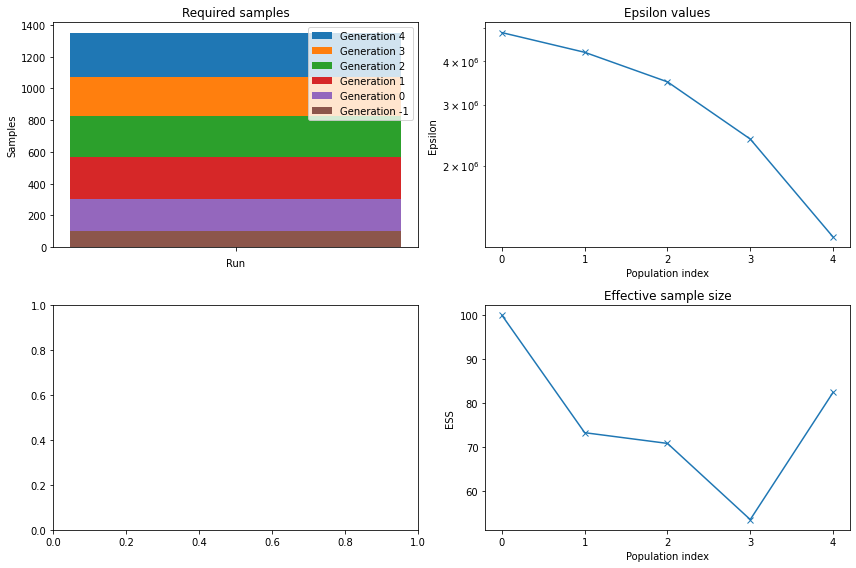

In [45]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

Plot the marginal posteriors

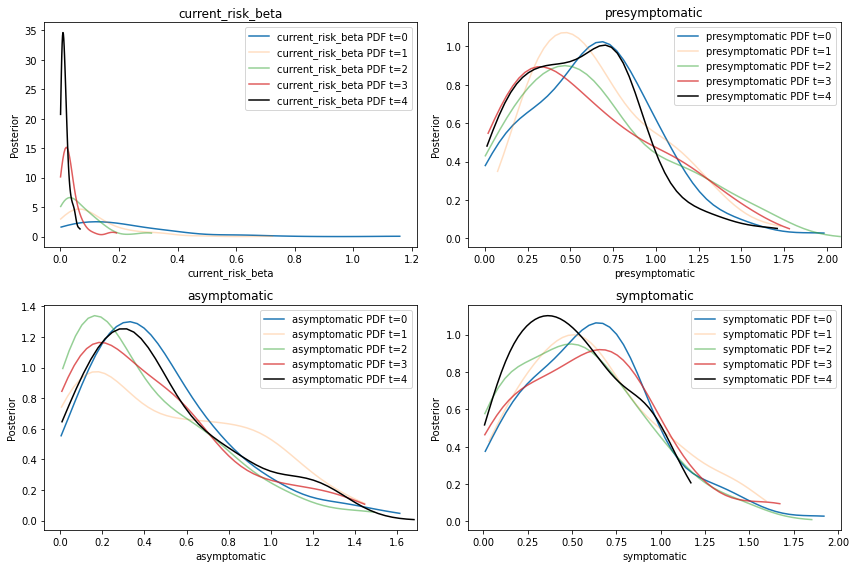

In [46]:
fig, axes = plt.subplots(2,int(len(priors)/2), figsize=(12,8))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        ) 
        ax.legend()
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
fig.tight_layout()

In [ ]:
#As above, but this time do a separate plot for each population

#fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
#for t in range(history.max_t + 1):
#    ax = axes.flat[t]
#    for i, param in enumerate(priors.keys()):
#        df, w = history.get_distribution(m=0, t=t)
#        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
#            label=f"{param}")
#    ax.legend()
#    ax.set_title(f"t={t}")
# fig.tight_layout()


Now look at the 2D correlations (_I'm not sure how to read this_)

array([[<AxesSubplot:ylabel='asymptomatic'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='current_risk_beta'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='presymptomatic'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='asymptomatic', ylabel='symptomatic'>,
        <AxesSubplot:xlabel='current_risk_beta'>,
        <AxesSubplot:xlabel='presymptomatic'>,
        <AxesSubplot:xlabel='symptomatic'>]], dtype=object)

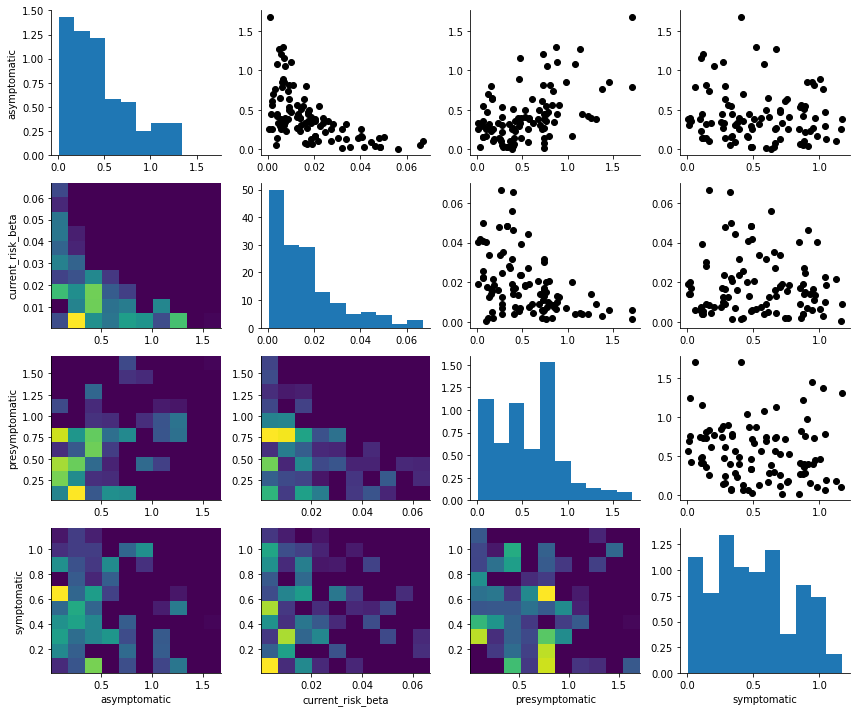

In [43]:
pyabc.visualization.plot_histogram_matrix(history, size=(12,10))

### Analyse the posterior

Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

_Note about the distrubtion returned by `get_distribution`_: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [47]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,current_risk_beta,presymptomatic,symptomatic,weight
0,695,1.303889,0.006404,0.869443,0.518395,0.026804
1,603,1.207728,0.005607,0.730718,0.117910,0.025620
2,636,0.896881,0.006694,0.462462,1.007598,0.024117
3,651,0.085166,0.016121,0.737319,0.667624,0.023296
4,631,0.012533,0.031963,0.741025,0.593557,0.020165
...,...,...,...,...,...,...
95,680,0.223505,0.024835,0.276632,0.891493,0.004460
96,639,1.268020,0.004647,1.134620,0.675885,0.003959
97,644,0.108677,0.021732,0.173602,1.123716,0.003829
98,609,0.127327,0.018551,0.192227,1.046916,0.003657


This code shows how to calculate the fitness associated with each particle (not the correct way to draw from the posterior so not especially useful).

Now we have a posterior over the parameters. There are two ways to find the 'optimal' model:

 - Find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations). This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).
 
 - Sample from the posterior distribution N times (N=100?) to generate a posterior over the model outputs. This better captures the uncertainty in the parameter values and in the associated model outputs.


#### ABC Posterior (A) - Sample

Sample from the distribution of parameter posteriors to generate a distribution over the mode likely model results. Use kernel density approximation to randomly draw some equally weighted samples.

(This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model).

In [ ]:
N_samples = 100
df, w = history.get_distribution(m=0, t=history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

## Instead sample just using the weights (this isn't the best way to do it though, should use KDE)
#df = df.reset_index()  # So that the row index is 0-N (currently it's something else)
#sample_idx = np.random.choice(
#            a=range(history.get_nr_particles_per_population().values[-1]),
#            size=N_samples, replace=True, p=w)
#samples = df.iloc[sample_idx] 

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

for i, sample in samples.iterrows():

    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        print("Found negatives. Resampling")
        sample = kde.rvs()
        
    # Create a dictionary with the parameters and their values for this sample
    param_values = { param:sample[str(param)] for param in priors}
    
    # Run the model
    (_fitness, _sim, _obs, _out_params, _summaries) = \
          OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    #print(f"Fitness: {_fitness}. Sample: {sample}")
    
    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])
    
# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode=="save":
        with open("abc-1-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode=="load":
        with open("abc-1-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return( fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")
pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

Plot the individual results for each sample

In [ ]:
#print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")

# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness-min(_fitness))/(max(_fitness)-min(_fitness))

fig, ax = plt.subplots(1,1, figsize=(12,8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            #label=f"Particle {df.index[sample_idx[i]]}", 
            color="black", alpha = 1-fitness_norm[i]  # (1-x because high fitness is bad)
    )
    
    #ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    #ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
ax.plot(x, obs_l[0], label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
ax.legend()
#plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)

del _fitness, fitness_norm

Plot the kde of the sample results (a bit like the posterior?). See the [pygam documentation](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html) for the GAM code to do this.

_The prediction intervals clearly aren't working_

In [ ]:
# Make two long arrays with every result from every particle
x = list(range(len(sim_l[0])))  # List of iteration numbers
X = []
for _iter in x * len(summaries_l):  # One sequence of iterations (0-100) for each particle
    X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
X = np.array(X)
y = []
for i in range(len(summaries_l)):
    y += list(OpenCLRunner.get_cumulative_new_infections(summaries_l[i]))
y = np.array(y)

# Generate the GAM
gam = LinearGAM( n_splines=250)
#gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
gam.gridsearch(X, y)
#XX = gam.generate_X_grid(term=0, n=len(X))
XX = gam.generate_X_grid(term=0)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(XX, gam.predict(XX), 'r--')
ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

#pdep, confi = gam.partial_dependence(term=0, width=.95)
#ax.plot(XX, pdep)
#ax.plot(XX, confi, c='r', ls='--')

ax.plot(x, obs_l[0], label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('95% prediction interval');

Do a KDE plot with a logarithmic colour scale.

_Looks like the distribution is multi-model_

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5),
         norm=LogNorm())

ax.set_xlabel("Iteration")
ax.set_ylabel("Cumulative cases")

ax.plot(x, obs_l[0], label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
fig.colorbar(h[3], ax=ax)
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('Density plot of results posterior');

#### ABC Posterior (B) - Find the Mode(s)

_I can't work out how to find the modes (basically I think I need the largest value of the `kde`?) so instead just choose the parameter values from the best sample_

Find the 'optimal' parameters

In [ ]:
# Load samples if needed
#fitness_l, sim_l, obs_l, out_params_l, summaries_l = pickle_samples("load")

# Find the best parameters
best_model_idx = np.argmin(fitness_l)
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['presymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[0])
best_params

See how those parameters relate to the marginal posteriors

In [ ]:
fig, axes = plt.subplots(2,int(len(priors)/2), figsize=(12,8))

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    df, w = history.get_distribution(m=0, t=history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        )
    ax.legend()
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

Run the model with those parameters

In [ ]:
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness1, sim1, obs1, out_params1, summaries1) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly (should be same as initial, default model)
np.array_equal(obs0, obs1)

# Print the fitness and plot the different disease counts
print(f"Fitness: {fitness1}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim1))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim0")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries1), label="sim1")
ax.plot(x, obs1, label="obs")
ax.legend()


## Spatial analysis of the posterior

We've seen how the aggregate, cumulative disease count varies, but how do the results vary over space?



Look at the distribtion of explosed people in the optimal model

In [ ]:
N=len(summaries1)
disease_status = "exposed"

fig, axes = plt.subplots(nrows=2, ncols=int(N/2) if (N % 2) == 0 else int(N/2)+1,
                    figsize=(12,8))

for i in range(N):
    #idx = indices[i]
    ax = axes.flat[i]
    plot_msoa_choropleth(devon_msoa_shapes, summaries1[i], disease_status, 99, ax=ax)
    ax.set_title(f"Run {i}")

XXXX HERE there is too much spatial variation? Might need to reduce impact of workplace interactions. Or maybe this is interesting. 